# AFM346 Final Project - Nate's Group Exploratory Data Analysis

***

### Tim Sankey, Callum Stevenson, Joel Palmer, Jake Vanderweyst, Nathan Farquharson

***

#### This project focuses on developing a predictive model using historical stock price data of S&P 500 companies to assist a high-profile client in making informed investment decisions. The goal is to analyze the dataset from multiple perspectives to identify the most effective predictive techniques, construct a robust model, and provide strategic investment recommendations on how to allocate 1 million USD across six target companies (CRM, UBER, CMG, KHC, EL, EXPE). By leveraging advanced feature engineering, exploratory data analysis, and various predictive modeling methods, the project aims to deliver actionable insights and maximize the client's potential returns within a specified timeframe.

#### We aim to predict the stock performance during the week of July 22nd to July 26th, 2024. Specifically, we plan to invest 1 million USD on July 19th at the closing price and sell our investments on July 26th at the closing price. Our model will predict the value of our investments over this week and allocate the portfolio's composition based on the best-performing stocks.

#### For structural purposes, we will be implementing the CRISP-DM model throughout the project. CRISP-DM is a data science life cycle model that provides guidance on the organization of a data science project. The components of the CRISP-DM model are as follows:

* 1) Business Understanding
* 2) Data Understanding
* 3) Data Preparation
* 4) Modelling
* 5) Evaluation
* 6) Deployment

#### For the exploratory data analysis code section of this project, we will focus on steps 2-6 of the CRISP-DM outline.

In [90]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [91]:
# Import relevant Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.tsa.seasonal import seasonal_decompose
import ta
import shap
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    PolynomialFeatures, 
    QuantileTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression, 
    Ridge, 
    Lasso, 
    LassoCV, 
    ElasticNetCV
)
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    IsolationForest
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import (
    GridSearchCV, 
    cross_val_score, 
    cross_val_predict, 
    learning_curve
)
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import PartialDependenceDisplay
import datetime


## Data Preparation and Understanding

* Load data
* Explore descriptive statistics of the data
* Analyze the quality of the data
* Clean the data
* Apply preliminary feature engineering techniques
* Subset the data
* Explore initial patterns

### Load Dataset

In [92]:
# Load data
df = pd.read_csv('/kaggle/input/afm346-stock-value-dataset/stocks.csv')

### Explore Descriptive Statistics of Data

In [93]:
# Data snippet
print("")
print("Snippet of the Dataframe")
print("")
print(df.head())

# Summary info
print("")
print("Summary Information")
print("")
print(df.info())

# Summary statistics
print("")
print("Summary Statistics")
print("")
print(df.describe())

# Observe missing or null values for each variable
print("")
print("Missing or Null Values")
print("")
print(df.isna().sum())


Snippet of the Dataframe

         Date Symbol  Adj Close  Close   High    Low   Open     Volume
0  2020-01-02    MMM     124.28 150.50 150.51 148.11 148.56 4307633.00
1  2020-01-03    MMM     123.21 149.21 149.38 146.85 148.01 2950412.00
2  2020-01-06    MMM     123.33 149.35 149.42 147.45 148.12 2389608.00
3  2020-01-07    MMM     122.83 148.75 149.26 147.84 149.06 2598908.00
4  2020-01-08    MMM     124.72 151.03 151.76 148.54 148.83 3298927.00

Summary Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568390 entries, 0 to 568389
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       568390 non-null  object 
 1   Symbol     568390 non-null  object 
 2   Adj Close  562866 non-null  float64
 3   Close      562866 non-null  float64
 4   High       562866 non-null  float64
 5   Low        562866 non-null  float64
 6   Open       562866 non-null  float64
 7   Volume     562866 non-null  float64
dtype

### Analyze the Quality of the Data

In [94]:
# Create subset of NAs
na_df = df[df.isna().any(axis=1)]

# Create table to sum NA values in subset
na_df.groupby('Symbol').apply(lambda x: x.isna().sum())

Date  Symbol  Adj Close  Close  High   Low  Open  Volume
Symbol                                                          
ABNB       0       0        238    238   238   238   238     238
CARR       0       0         53     53    53    53    53      53
CEG        0       0        516    516   516   516   516     516
GEHC       0       0        745    745   745   745   745     745
GEV        0       0       1067   1067  1067  1067  1067    1067
KVUE       0       0        840    840   840   840   840     840
OTIS       0       0         53     53    53    53    53      53
SOLV       0       0       1067   1067  1067  1067  1067    1067
VLTO       0       0        945    945   945   945   945     945

### Clean the Data

* All of the NA values are companies that were added or dropped from the dataset (S&P500) within a span of time that does not align with the first and last day of the time-period that is being analyzed. Imputation could skew the results of our final model, so we decided to drop all of the NA values from the dataset.

In [95]:
# Drop NA values
df = df.dropna()

In [96]:
# Sort dataframe by date and symbol
df = df.sort_values(by=['Symbol', 'Date'])

# Create datetime formatted 'Date' variable - Data only contains weekdays, so 1 week = 5 days.
df.loc[:, 'Date_dt'] = pd.to_datetime(df['Date'])

### Feature Engineering

#### Creation of Lag Variables

* Lag variables allow us to incorporate past values of a time series into our analysis, enabling the modeling of temporal dependencies, trends, and patterns.

In [97]:
# Create lag variable for df
df['lag1'] = df.groupby('Symbol')['Adj Close'].shift(1)
df['lag5'] = df.groupby('Symbol')['Adj Close'].shift(5)
df['lag10'] = df.groupby('Symbol')['Adj Close'].shift(10)
df['lag20'] = df.groupby('Symbol')['Adj Close'].shift(20)
df.head()

Date Symbol  Adj Close  Close  High   Low  Open     Volume  \
10170  2020-01-02      A      83.50  85.95 86.35 85.20 85.90 1410500.00   
10171  2020-01-03      A      82.16  84.57 85.33 84.50 84.67 1118300.00   
10172  2020-01-06      A      82.40  84.82 84.82 83.60 84.00 1993200.00   
10173  2020-01-07      A      82.66  85.08 85.26 83.94 83.96 1684700.00   
10174  2020-01-08      A      83.47  85.92 86.47 85.20 85.96 1847600.00   

         Date_dt  lag1  lag5  lag10  lag20  
10170 2020-01-02   NaN   NaN    NaN    NaN  
10171 2020-01-03 83.50   NaN    NaN    NaN  
10172 2020-01-06 82.16   NaN    NaN    NaN  
10173 2020-01-07 82.40   NaN    NaN    NaN  
10174 2020-01-08 82.66   NaN    NaN    NaN

#### Creation of Forward Variables

* Forward variables enable us to anticipate future trends and patterns by incorporating expected market movements into our analysis.

In [98]:
# Create lag variable for df
df['forward1'] = df.groupby('Symbol')['Adj Close'].shift(-1)
df['forward5'] = df.groupby('Symbol')['Adj Close'].shift(-5)
df['forward10'] = df.groupby('Symbol')['Adj Close'].shift(-10)
df['forward20'] = df.groupby('Symbol')['Adj Close'].shift(-20)
df['forward21'] = df.groupby('Symbol')['Adj Close'].shift(-21)
df.head()

Date Symbol  Adj Close  Close  High   Low  Open     Volume  \
10170  2020-01-02      A      83.50  85.95 86.35 85.20 85.90 1410500.00   
10171  2020-01-03      A      82.16  84.57 85.33 84.50 84.67 1118300.00   
10172  2020-01-06      A      82.40  84.82 84.82 83.60 84.00 1993200.00   
10173  2020-01-07      A      82.66  85.08 85.26 83.94 83.96 1684700.00   
10174  2020-01-08      A      83.47  85.92 86.47 85.20 85.96 1847600.00   

         Date_dt  lag1  lag5  lag10  lag20  forward1  forward5  forward10  \
10170 2020-01-02   NaN   NaN    NaN    NaN     82.16     84.78      86.91   
10171 2020-01-03 83.50   NaN    NaN    NaN     82.40     85.10      87.55   
10172 2020-01-06 82.16   NaN    NaN    NaN     82.66     84.97      87.06   
10173 2020-01-07 82.40   NaN    NaN    NaN     83.47     85.48      87.56   
10174 2020-01-08 82.66   NaN    NaN    NaN     84.78     86.10      86.53   

       forward20  forward21  
10170      80.21      79.81  
10171      79.81      81.14  
10172      81.14      82.51  
10173      82.51      82.40  
10174      82.40      80.80

#### Moving Average

* Moving average variables allow us to smooth out short-term fluctuations in the stock prices to identify underlying trends over different time periods, making it easier to analyze the general direction of the market.

In [99]:
# Create moving average variable for df
df['MA_5'] = df['Adj Close'].rolling(window=5).mean()
df['MA_10'] = df['Adj Close'].rolling(window=10).mean()
df['MA_20'] = df['Adj Close'].rolling(window=20).mean()
df.sample(n=5)

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
163005  2021-02-19     DE     316.93 330.00 335.21 315.87 320.00 4870100.00   
498607  2021-02-08    TFX     391.54 398.63 402.45 396.42 398.94   93600.00   
292003  2021-11-02   INTU     608.42 618.39 625.66 610.50 612.09 1024500.00   
443683  2022-11-14    DGX     145.74 150.38 153.12 150.38 151.54 1026400.00   
465502  2024-04-08    SLB      53.70  54.04  55.65  53.96  55.44 8975900.00   

          Date_dt   lag1  ...  lag10  lag20  forward1  forward5  forward10  \
163005 2021-02-19 288.36  ... 297.02 293.40    324.14    335.30     335.98   
498607 2021-02-08 391.67  ... 375.34 406.02    393.16    397.30     388.12   
292003 2021-11-02 599.00  ... 563.57 524.09    612.83    602.90     635.35   
443683 2022-11-14 146.37  ... 139.22 123.98    143.37    141.98     144.41   
465502 2024-04-08  54.68  ...  53.65  50.08     53.83     51.34      49.20   

        forward20  forward21   MA_5  MA_10  MA_20  
163005     357.73     356.88 302.03 301.77 293.36  
498607     399.85     411.52 388.31 380.14 382.14  
292003     653.19     661.29 606.41 593.54 563.57  
443683     145.13     146.45 144.43 141.60 137.92  
465502      47.66      47.86  54.23  54.27  53.59  

[5 rows x 21 columns]

#### Moving Standard Deviation

* Moving standard deviation variables enable us to measure the volatility of stock prices over different time periods, providing insights into the stability and risk associated with the stock.

In [100]:
# Create moving std variable
df['Mstd_5'] = df['Adj Close'].rolling(window=5).std()
df['Mstd_10'] = df['Adj Close'].rolling(window=10).std()
df['Mstd_20'] = df['Adj Close'].rolling(window=20).std()
df.sample(n=5)

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
462293  2020-06-29    CRM     183.09 183.33 183.71 180.00 183.32 3972100.00   
240458  2023-07-28   GEHC      77.87  77.87  78.32  76.89  77.24 2910100.00   
163824  2024-05-22     DE     386.01 386.01 388.56 384.25 386.00 1318800.00   
456706  2020-09-28    ROL      34.75  36.44  36.78  36.11  36.11 1075800.00   
536962  2020-11-03      V     183.36 188.34 189.53 185.16 186.83 6467900.00   

          Date_dt   lag1  ...  forward5  forward10  forward20  forward21  \
462293 2020-06-29 182.93  ...    196.12     189.31     189.25     193.36   
240458 2023-07-28  76.86  ...     75.90      71.59      68.59      69.31   
163824 2024-05-22 386.74  ...    368.35     371.27     375.04     378.17   
456706 2020-09-28  34.10  ...     35.39      37.14      37.82      37.69   
536962 2020-11-03 179.86  ...    207.67     205.45     204.93     202.86   

         MA_5  MA_10  MA_20  Mstd_5  Mstd_10  Mstd_20  
462293 185.65 185.52 180.32    2.74     3.60     6.26  
240458  78.60  80.29  80.55    1.71     2.15     1.62  
163824 391.14 400.74 399.22    4.77    10.78     8.68  
456706  33.88  33.89  34.39    0.57     0.57     0.77  
536962 179.24 184.79 190.70    2.88     6.63     7.91  

[5 rows x 24 columns]

#### Return Variables

* Return variables allow us to analyze and compare the stock's performance over different time horizons, identify trends, assess volatility, and make informed decisions based on historical price movements and returns.

In [101]:
# Create daily, weekly, and bi-weekly return variables

# Dollar return variables
df['$_return_daily'] = df['Adj Close'] - df['lag1']
df['$_return_weekly'] = df['Adj Close'] - df['lag5']
df['$_return_biweekly'] = df['Adj Close'] - df['lag10']
df['$_return_monthly'] = df['Adj Close'] - df['lag20']

# Percentage return variables
df['%_return_daily'] = (df['$_return_daily']/df['lag1'])*100
df['%_return_weekly'] = (df['$_return_weekly']/df['lag5'])*100
df['%_return_biweekly'] = (df['$_return_biweekly']/df['lag10'])*100
df['%_return_monthly'] = (df['$_return_monthly']/df['lag20'])*100
df.sample(n=5)

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
47072   2022-12-12   APTV      96.11  96.11  96.44  92.83  93.03 2465900.00   
526405  2023-10-18    UHS     127.55 128.03 129.42 125.84 126.70  394300.00   
444781  2022-09-29     RL      84.20  87.27  88.51  85.50  86.81 1372600.00   
105847  2023-01-04   CBRE      79.72  79.72  80.20  79.19  79.57 1258500.00   
38539   2020-06-23    APH      23.38  24.29  24.90  24.29  24.74 4310800.00   

          Date_dt   lag1  ...  Mstd_10  Mstd_20  $_return_daily  \
47072  2022-12-12  93.28  ...     4.71     5.23            2.83   
526405 2023-10-18 126.85  ...     2.48     2.00            0.70   
444781 2022-09-29  85.14  ...     4.01     3.85           -0.94   
105847 2023-01-04  78.44  ...     1.45     1.47            1.28   
38539  2020-06-23  23.47  ...     0.42     0.79           -0.10   

        $_return_weekly  $_return_biweekly  $_return_monthly  %_return_daily  \
47072             -5.52              -5.91            -15.60            3.03   
526405             1.01               3.92             -1.02            0.55   
444781            -0.36              -4.85             -3.17           -1.10   
105847             3.23               4.71              1.99            1.63   
38539             -0.34              -1.04              0.82           -0.42   

        %_return_weekly  %_return_biweekly  %_return_monthly  
47072             -5.43              -5.79            -13.96  
526405             0.80               3.17             -0.79  
444781            -0.43              -5.45             -3.63  
105847             4.22               6.28              2.56  
38539             -1.44              -4.24              3.63  

[5 rows x 32 columns]

#### Moving Averages of Volume
* These calculations smooth out short-term fluctuations to identify underlying trends in trading activity over different periods, such as 5-day and 10-day periods.

In [102]:
# Calculate the 5-day moving average of the trading volume
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()

# Calculate the 10-day moving average of the trading volume
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

#### Day of Week, Month, and Quarter
* Extracting these attributes captures seasonal and cyclical effects, enabling the analysis of how stock performance varies depending on the time of the week, month, or quarter.

In [103]:
# Extract the day of the week from the 'Date_dt' column (0=Monday, 6=Sunday)
df['Day_Of_Week'] = df['Date_dt'].dt.dayofweek

# Extract the month from the 'Date_dt' column (1=January, 12=December)
df['Month'] = df['Date_dt'].dt.month

# Extract the quarter from the 'Date_dt' column (1=Q1, 4=Q4)
df['Quarter'] = df['Date_dt'].dt.quarter

#### Technical Analysis Library (ta)
* The ta library in this code provides functions for calculating various technical indicators, which are used to analyze stock price movements and trends.

In [104]:
# Create technical variables

# Calculate the Relative Strength Index (RSI) with a 14-day window
df['RSI'] = ta.momentum.rsi(df['Adj Close'], window=14)

# Calculate the upper Bollinger Band with a 20-day window
df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Adj Close'], window=20)

# Calculate the lower Bollinger Band with a 20-day window
df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Adj Close'], window=20)

# Calculate the Moving Average Convergence Divergence (MACD) using a slow window of 26 days and a fast window of 12 days
df['MACD'] = ta.trend.macd(df['Adj Close'], window_slow=26, window_fast=12)

# Calculate the 12-day Exponential Moving Average (EMA)
df['EMA_12'] = ta.trend.ema_indicator(df['Adj Close'], window=12)

# Calculate the 26-day Exponential Moving Average (EMA)
df['EMA_26'] = ta.trend.ema_indicator(df['Adj Close'], window=26)

#advanced feature engineering (continued)

# Create interaction features
# Calculate the product of RSI and Volume
df['RSI*Volume'] = df['RSI'] * df['Volume']

# Calculate the product of MACD and 12-day EMA
df['MACD*EMA_12'] = df['MACD'] * df['EMA_12']

# Calculate the product of Adjusted Close and Volume
df['Adj Close*Volume'] = df['Adj Close'] * df['Volume']

# Calculate the ratio of Adjusted Close to Volume
df['Adj Close/Volume'] = df['Adj Close'] / df['Volume']

# Create additional technical indicators
# Calculate the Stochastic Oscillator with a 14-day window
df['Stoch_Osc'] = ta.momentum.stoch(df['High'], df['Low'], df['Adj Close'], window=14)

# Calculate the Average Directional Index (ADX) with a 14-day window
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Adj Close'], window=14)

# Calculate the Commodity Channel Index (CCI) with a 20-day window
df['CCI'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20)

# Create more interaction features
# Calculate the product of RSI and Adjusted Close
df['RSI*Adj_Close'] = df['RSI'] * df['Adj Close']

# Calculate the product of 12-day EMA and Volume
df['EMA_12*Volume'] = df['EMA_12'] * df['Volume']

# Calculate the product of Stochastic Oscillator and ADX
df['Stoch_Osc*ADX'] = df['Stoch_Osc'] * df['ADX']

# Create seasonality features
# Indicate if the date is at the end of the month
df['is_month_end'] = df['Date_dt'].dt.is_month_end.astype(int)

# Indicate if the date is at the end of the quarter
df['is_quarter_end'] = df['Date_dt'].dt.is_quarter_end.astype(int)

# Indicate if the date is at the end of the year
df['is_year_end'] = df['Date_dt'].dt.is_year_end.astype(int)

# Create volume-based features
# Calculate the Volume Price Trend (VPT)
df['VPT'] = (df['Volume'] * ((df['Adj Close'] - df['lag1']) / df['lag1'])).cumsum()

# Calculate the On-Balance Volume (OBV)
df['OBV'] = ta.volume.on_balance_volume(df['Adj Close'], df['Volume'])

df.sample(n=5)


Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
468259  2021-09-29    NOW     618.02 618.02 623.84 607.18 620.00 1228600.00   
47864   2021-08-10   ACGL      40.78  40.78  41.17  40.46  40.48 1127100.00   
399383  2021-12-15   ORLY     687.21 687.21 689.90 668.13 668.13  424900.00   
533504  2020-07-29   VRTX     278.72 278.72 281.59 278.09 280.28 1091200.00   
309847  2020-11-24    KDP      27.62  29.89  30.10  29.86  30.00 6100900.00   

          Date_dt   lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
468259 2021-09-29 612.52  ... 32.15 -248.18       25649.21   790146538.60   
47864  2021-08-10  40.54  ... 14.10  162.59        2698.83    44660665.20   
399383 2021-12-15 667.36  ... 26.86  118.76       45271.59   283658503.09   
533504 2020-07-29 278.52  ... 13.28 -148.37       12178.90   312010909.32   
309847 2020-11-24  27.57  ... 10.84  108.24        1665.29   165595970.99   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
468259         550.54             0               0            0   
47864         1248.78             0               0            0   
399383        2560.14             0               0            0   
533504         107.18             0               0            0   
309847         183.47             0               0            0   

                 VPT             OBV  
468259 1915650528.39  43189614519.00  
47864   476333069.36   3942291516.00  
399383 4300691128.32  97126187737.00  
533504 5540234589.88 118123640808.00  
309847 1565639654.08  33107354034.00  

[5 rows x 58 columns]

#### That concludes the feature engineering section of our analysis.

#### NA Value Investigation (revisited)

In [105]:
print(df.isna().sum())

Date                     0
Symbol                   0
Adj Close                0
Close                    0
High                     0
Low                      0
Open                     0
Volume                   0
Date_dt                  0
lag1                   503
lag5                  2515
lag10                 5030
lag20                10060
forward1               503
forward5              2515
forward10             5030
forward20            10060
forward21            10563
MA_5                     4
MA_10                    9
MA_20                   19
Mstd_5                   4
Mstd_10                  9
Mstd_20                 19
$_return_daily         503
$_return_weekly       2515
$_return_biweekly     5030
$_return_monthly     10060
%_return_daily         503
%_return_weekly       2515
%_return_biweekly     5030
%_return_monthly     10060
Volume_MA_5              4
Volume_MA_10             9
Day_Of_Week              0
Month                    0
Quarter                  0
R

In [106]:
df_na = df[df.isna().any(axis=1)]
df_na.sample(n=10)

Date Symbol  Adj Close  Close   High    Low   Open      Volume  \
407939  2020-01-15   PCAR      44.43  51.64  52.03  51.50  51.93  2195850.00   
429416  2020-01-27    PFG      44.42  52.91  53.65  52.80  53.10  1150800.00   
235049  2020-01-15    FCX      12.41  12.98  13.13  12.85  13.06 20449800.00   
10189   2020-01-30      A      81.98  84.38  85.03  83.60  84.90  3026700.00   
458773  2024-06-20    ROP     559.22 559.22 563.92 556.06 560.00   548300.00   
242947  2024-06-26    GEN      24.19  24.19  24.32  23.99  24.10  3195200.00   
220363  2020-01-22    FDX     151.57 155.54 158.85 155.47 157.49  1911100.00   
488165  2020-01-09    SYY      75.53  84.63  85.13  84.44  84.74  1914800.00   
452013  2020-01-22    RSG      88.34  94.33  94.61  94.10  94.13   669000.00   
366133  2020-01-22    MOH     137.75 137.75 139.50 137.29 138.79   774500.00   

          Date_dt   lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
407939 2020-01-15  44.86  ... 51.74  -67.41         372.92   130247611.67   
429416 2020-01-27  45.63  ... 54.94   16.34        2828.77    51988722.34   
235049 2020-01-15  12.63  ... 57.86  -66.86          85.59   453805515.07   
10189  2020-01-30  84.76  ...  0.00 -130.75        2814.78   256808982.28   
458773 2024-06-20 560.10  ... 24.33  115.45       35166.63   302596789.85   
242947 2024-06-26  24.17  ... 19.16  -51.94        1261.59    77346592.42   
220363 2020-01-22 153.51  ... 57.29  -47.88        1768.81   341868877.17   
488165 2020-01-09  75.44  ... 38.71 -110.85         377.09   331410832.25   
452013 2020-01-22  87.86  ... 53.96  -40.36        1806.69    61930621.48   
366133 2020-01-22 138.38  ... 56.34   47.77       10812.78   100297089.02   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
407939        -487.59             0               0            0   
429416      -10564.42             0               0            0   
235049         -13.45             0               0            0   
10189           -0.00             0               0            0   
458773        2142.69             0               0            0   
242947         750.24             0               0            0   
220363         559.75             0               0            0   
488165        -114.75             0               0            0   
452013        -394.39             0               0            0   
366133        2682.18             0               0            0   

                 VPT             OBV  
407939 4329599800.14  97352440197.00  
429416 4391250776.68  98306697224.00  
235049 1440024829.80  22359509176.00  
10189      -44669.56     10601600.00  
458773 4395943071.71 100495351314.00  
242947 1483687460.76  24116239731.00  
220363 1481878824.44  22381842653.00  
488165 4407893255.96 101121613889.00  
452013 4392801392.24 100524721995.00  
366133 1576468504.06  37777308511.00  

[10 rows x 58 columns]

#### The NA values for lag and MA variables are expected based on the timing and lack of data to create lag data for these observation.

### Subset the Data
* Create separate subsets of the main dataframe for the selected companies (CRM, UBER, CMG, KHC, EL, EXPE) to help with targeted analysis and modeling for each individual company.
* Create separate subsets of the main dataframe for EACH selected company

In [107]:
# Create subset for selected companies
target_df = df[df['Symbol'].isin(['CRM', 'UBER', 'CMG', 'KHC', 'EL', 'EXPE'])].copy()

# Create subset for CRM
CRM_df = df[df['Symbol'] == 'CRM'].copy()

# Create subset for UBER
UBER_df = df[df['Symbol'] == 'UBER'].copy()

# Create subset for CMG
CMG_df = df[df['Symbol'] == 'CMG'].copy()

# Create subset for KHC
KHC_df = df[df['Symbol'] == 'KHC'].copy()

# Create subset for EL
EL_df = df[df['Symbol'] == 'EL'].copy()

# Create subset for EXPE
EXPE_df = df[df['Symbol'] == 'EXPE'].copy()

#### Create Comparable Company Subsets
* The purpose of this is to create subsets of the main dataframe for companies that are comparable to the target companies (CRM, UBER, CMG, KHC, EL, EXPE). This allows for benchmarking and comparative analysis by grouping each target company with its peers in the industry. By analyzing these subsets, you can gain insights into the relative performance and trends of the target companies against their respective competitive sets.

In [108]:
# Create subset for Salesforce comparables
CRM_compset = ['ADBE','SAP','HUBS','WDAY','INTU','ORCL','DDOG','DOCU','RNG','ASAN']
CRM_comp_df = df[df['Symbol'].isin(CRM_compset)].copy()

# Create subset for Uber comparables
UBER_compset = ['BKNG', 'EXPE', 'AMZN', 'TSLA', 'GOOGL', 'META']
UBER_comp_df = df[df['Symbol'].isin(UBER_compset)].copy()

# Create subset for Chipotle Mexican Grill comparables
CMG_compset = ['MCD', 'DPZ', 'YUM', 'WEN', 'QSR', 'DRI', 'WING', 'SHAK', 'JACK', 'PTLO']
CMG_comp_df = df[df['Symbol'].isin(CMG_compset)].copy()

# Create subset for The Kraft Heinz Company comparables
KHC_compset = ['MDLZ', 'GIS', 'K', 'HSY', 'CAG', 'CPB', 'MKC', 'HRL', 'TSN', 'BN']
KHC_comp_df = df[df['Symbol'].isin(KHC_compset)].copy()

# Create subset for The Estée Lauder Companies comparables
EL_compset = ['KVUE', 'COTY', 'CL', 'ULTA', 'ELF', 'OLPX', 'EPC', 'SKIN', 'PG', 'OR']
EL_comp_df = df[df['Symbol'].isin(EL_compset)].copy()

# Create subset for Expedia Group comparables
EXPE_compset = ['ABNB', 'BKNG', 'H', 'MAR', 'HLT', 'ZG', 'AMZN', 'GOOGL', 'TUI1', 'AC']
EXPE_comp_df = df[df['Symbol'].isin(EXPE_compset)].copy()

#### Initial Pattern Exploration
* Plot the stock price changes over time for the selected companies (CRM, UBER, CMG, KHC, EL, EXPE). This visualization allows for a comparative analysis of the stock price trends and performance of these companies over the specified period.

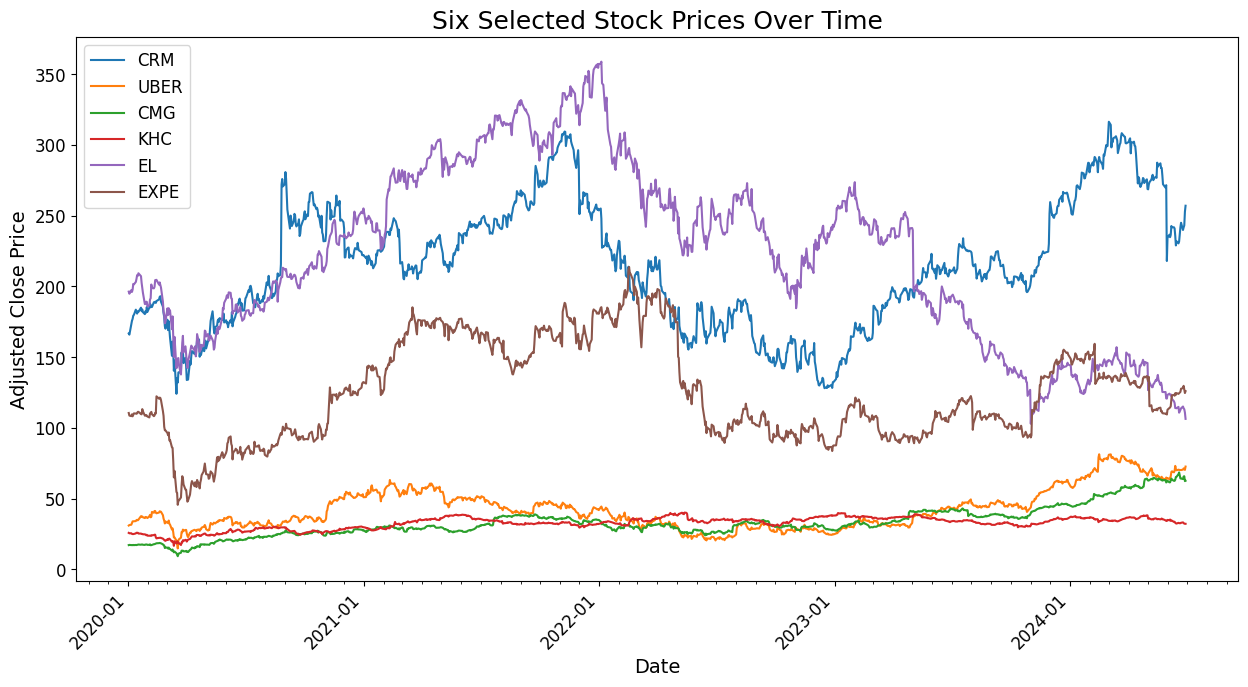

In [109]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the 'Date' column is in datetime format
CRM_df['Date'] = pd.to_datetime(CRM_df['Date'])
UBER_df['Date'] = pd.to_datetime(UBER_df['Date'])
CMG_df['Date'] = pd.to_datetime(CMG_df['Date'])
KHC_df['Date'] = pd.to_datetime(KHC_df['Date'])
EL_df['Date'] = pd.to_datetime(EL_df['Date'])
EXPE_df['Date'] = pd.to_datetime(EXPE_df['Date'])

# Plot stock price changes
plt.figure(figsize=(15, 8))

# Plot selected companies
plt.plot(CRM_df['Date'], CRM_df['Adj Close'], label='CRM')
plt.plot(UBER_df['Date'], UBER_df['Adj Close'], label='UBER')
plt.plot(CMG_df['Date'], CMG_df['Adj Close'], label='CMG')
plt.plot(KHC_df['Date'], KHC_df['Adj Close'], label='KHC')
plt.plot(EL_df['Date'], EL_df['Adj Close'], label='EL')
plt.plot(EXPE_df['Date'], EXPE_df['Adj Close'], label='EXPE')

# Titles and labels
plt.title('Six Selected Stock Prices Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(fontsize=12)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)

# Increase label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()



* Plot the dollar amount change in selected stock prices for each month

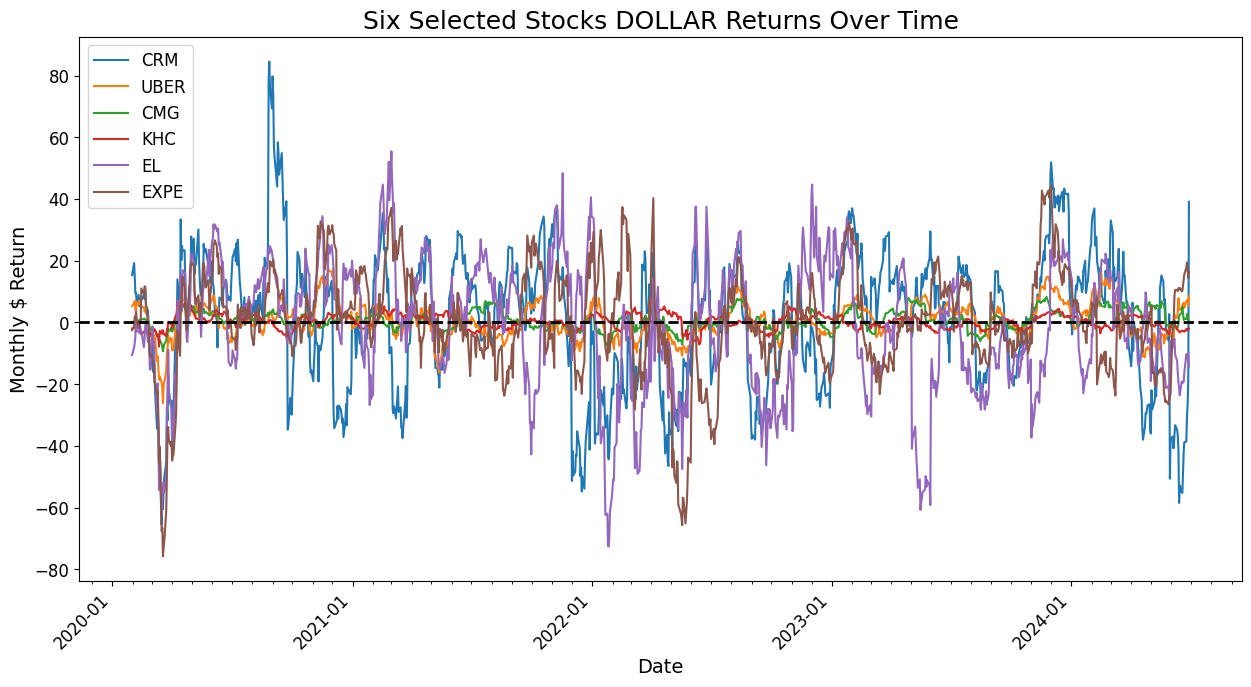

In [110]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the 'Date' column is in datetime format
CRM_df['Date'] = pd.to_datetime(CRM_df['Date'])
UBER_df['Date'] = pd.to_datetime(UBER_df['Date'])
CMG_df['Date'] = pd.to_datetime(CMG_df['Date'])
KHC_df['Date'] = pd.to_datetime(KHC_df['Date'])
EL_df['Date'] = pd.to_datetime(EL_df['Date'])
EXPE_df['Date'] = pd.to_datetime(EXPE_df['Date'])

# Plot the stock price changes
plt.figure(figsize=(15, 8))

# Plot each selected company
plt.plot(CRM_df['Date'], CRM_df['$_return_monthly'], label='CRM')
plt.plot(UBER_df['Date'], UBER_df['$_return_monthly'], label='UBER')
plt.plot(CMG_df['Date'], CMG_df['$_return_monthly'], label='CMG')
plt.plot(KHC_df['Date'], KHC_df['$_return_monthly'], label='KHC')
plt.plot(EL_df['Date'], EL_df['$_return_monthly'], label='EL')
plt.plot(EXPE_df['Date'], EXPE_df['$_return_monthly'], label='EXPE')

# Add titles and labels
plt.title('Six Selected Stocks DOLLAR Returns Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly $ Return', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize=12)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)

# Increase label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

* Plot the percentage change in selected stock prices for each month

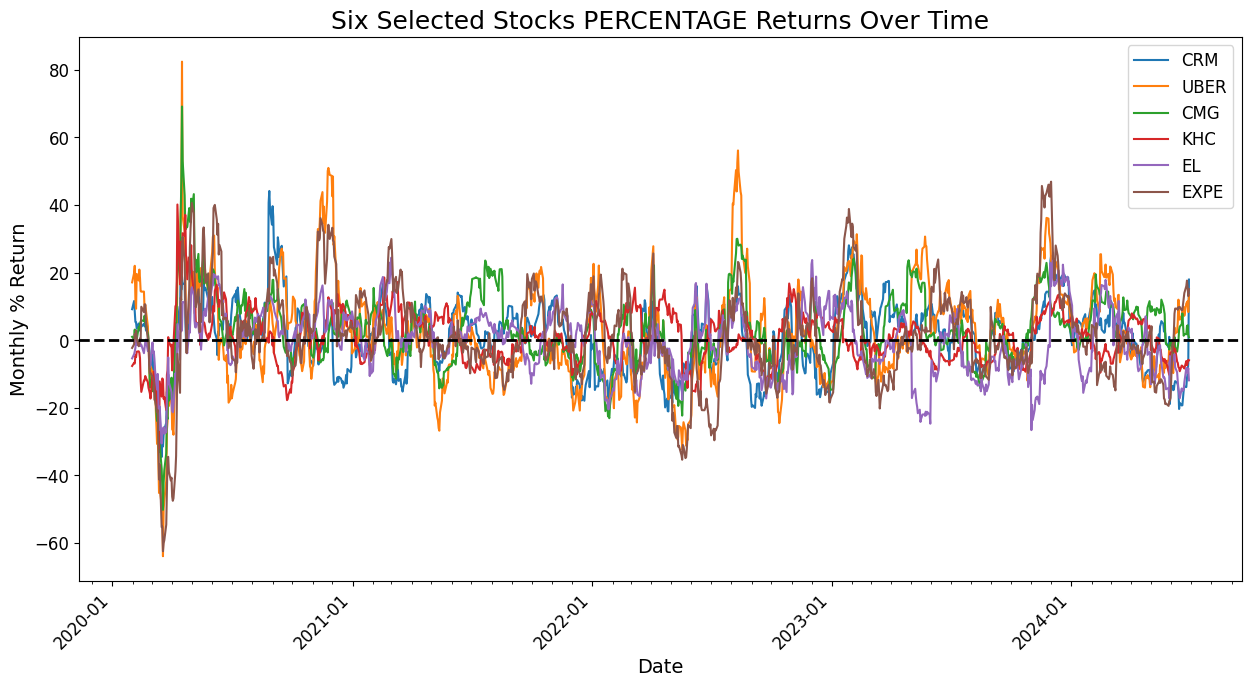

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure the 'Date' column is in datetime format
CRM_df['Date'] = pd.to_datetime(CRM_df['Date'])
UBER_df['Date'] = pd.to_datetime(UBER_df['Date'])
CMG_df['Date'] = pd.to_datetime(CMG_df['Date'])
KHC_df['Date'] = pd.to_datetime(KHC_df['Date'])
EL_df['Date'] = pd.to_datetime(EL_df['Date'])
EXPE_df['Date'] = pd.to_datetime(EXPE_df['Date'])

# Plot the stock price changes
plt.figure(figsize=(15, 8))

# Plot each selected company
plt.plot(CRM_df['Date'], CRM_df['%_return_monthly'], label='CRM')
plt.plot(UBER_df['Date'], UBER_df['%_return_monthly'], label='UBER')
plt.plot(CMG_df['Date'], CMG_df['%_return_monthly'], label='CMG')
plt.plot(KHC_df['Date'], KHC_df['%_return_monthly'], label='KHC')
plt.plot(EL_df['Date'], EL_df['%_return_monthly'], label='EL')
plt.plot(EXPE_df['Date'], EXPE_df['%_return_monthly'], label='EXPE')

# Add titles and labels
plt.title('Six Selected Stocks PERCENTAGE Returns Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Monthly % Return', fontsize=14)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize=12)

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate(rotation=45)

# Increase label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

* For this next section of initial pattern exploration, we are going to focus on looking at the week that we intent to invest for in previous years.

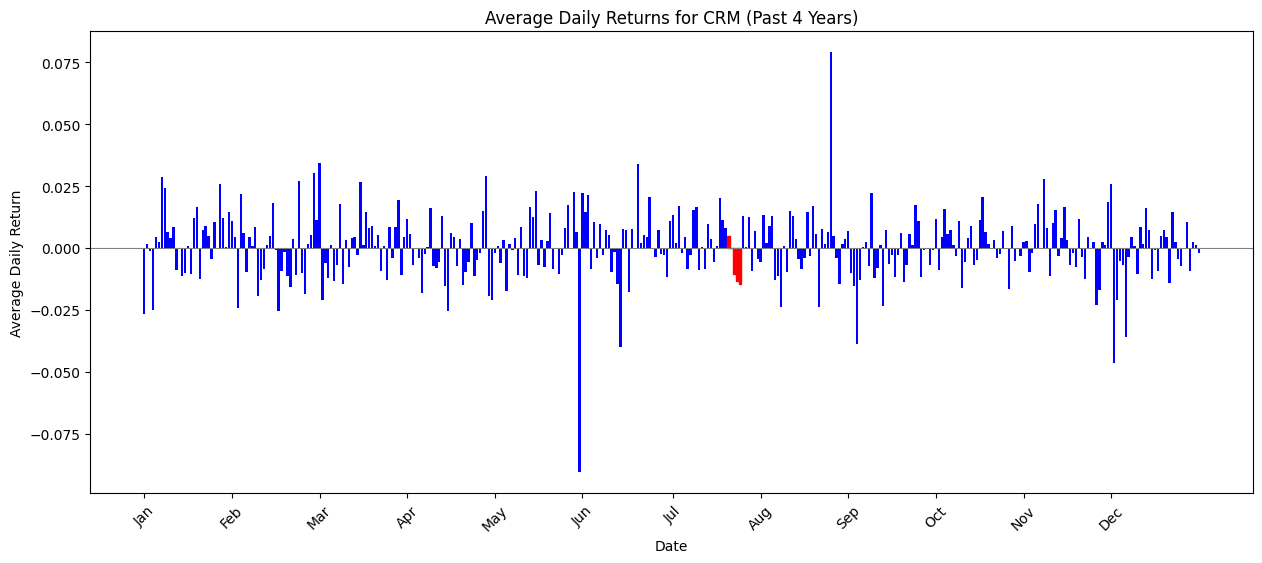

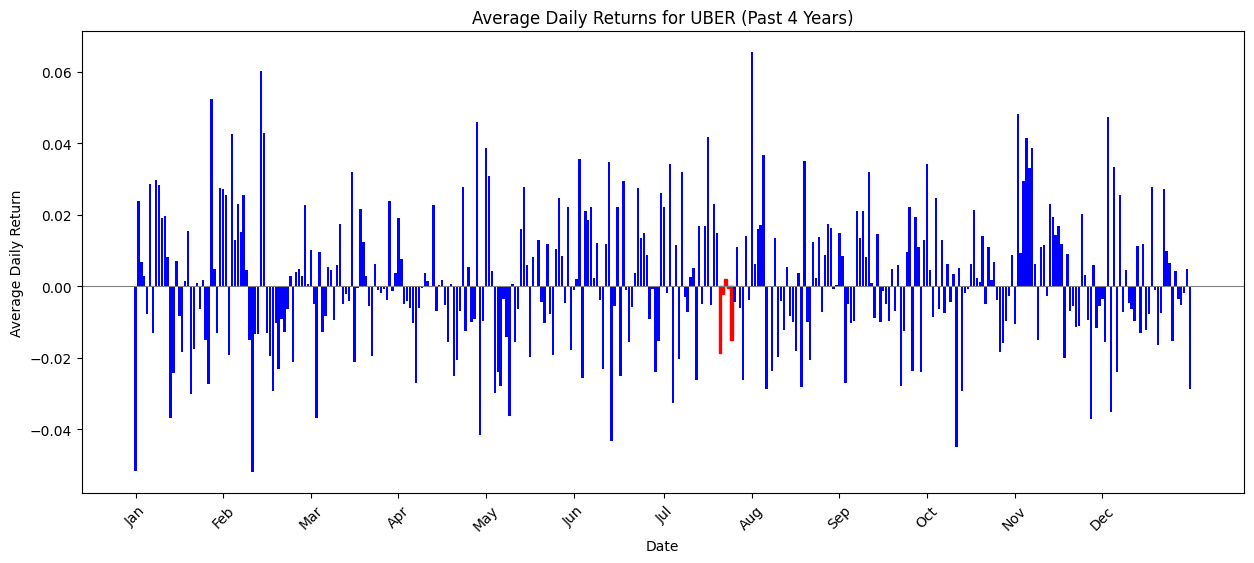

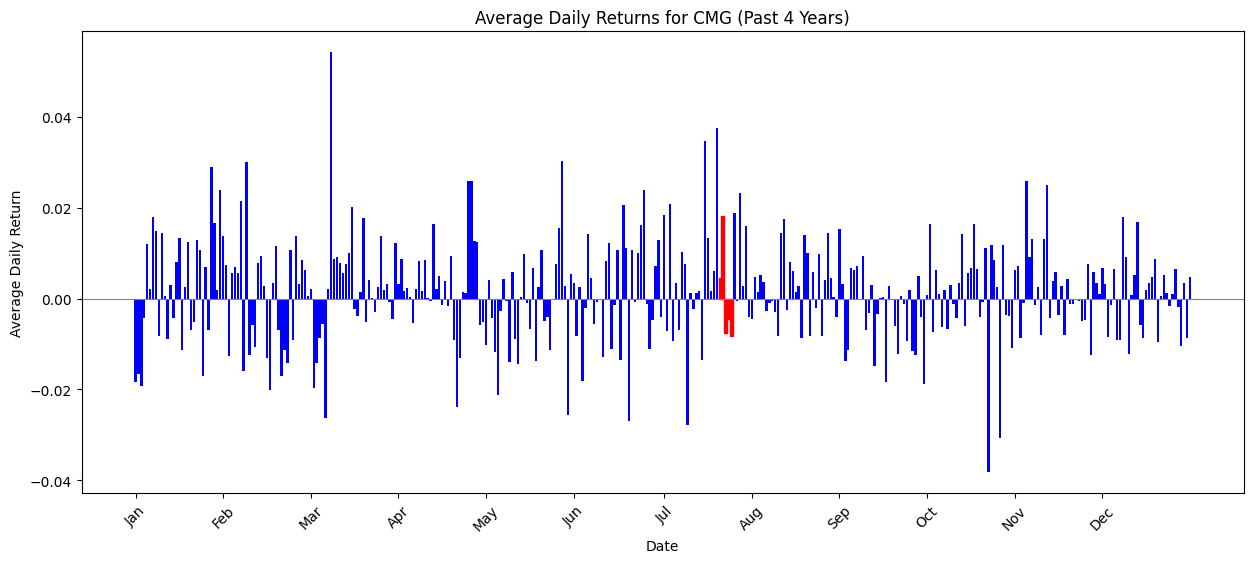

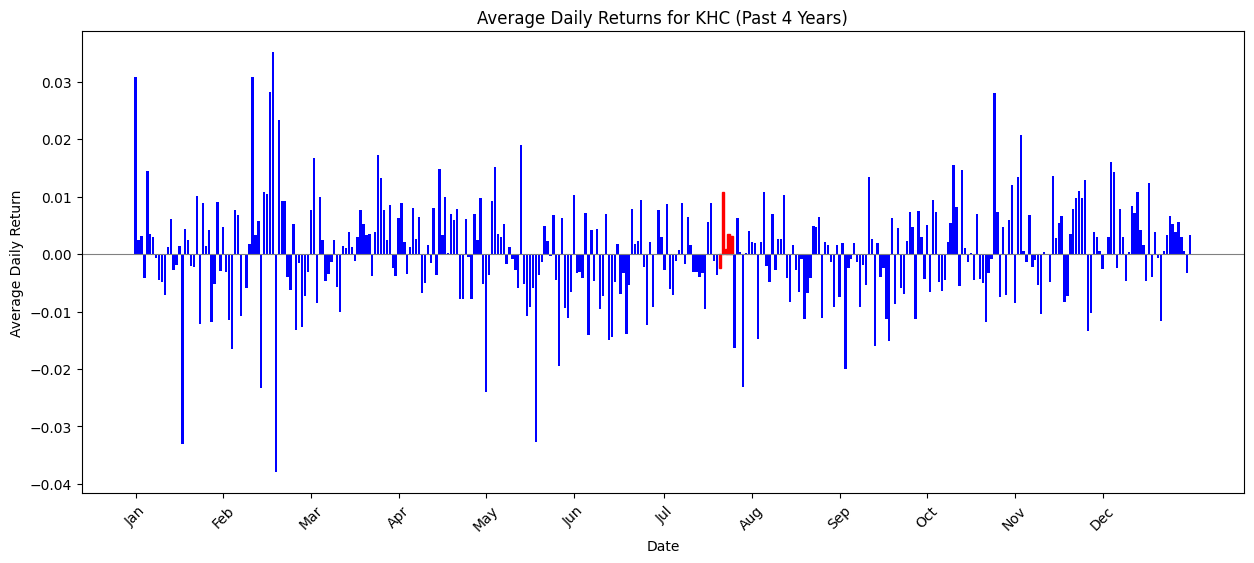

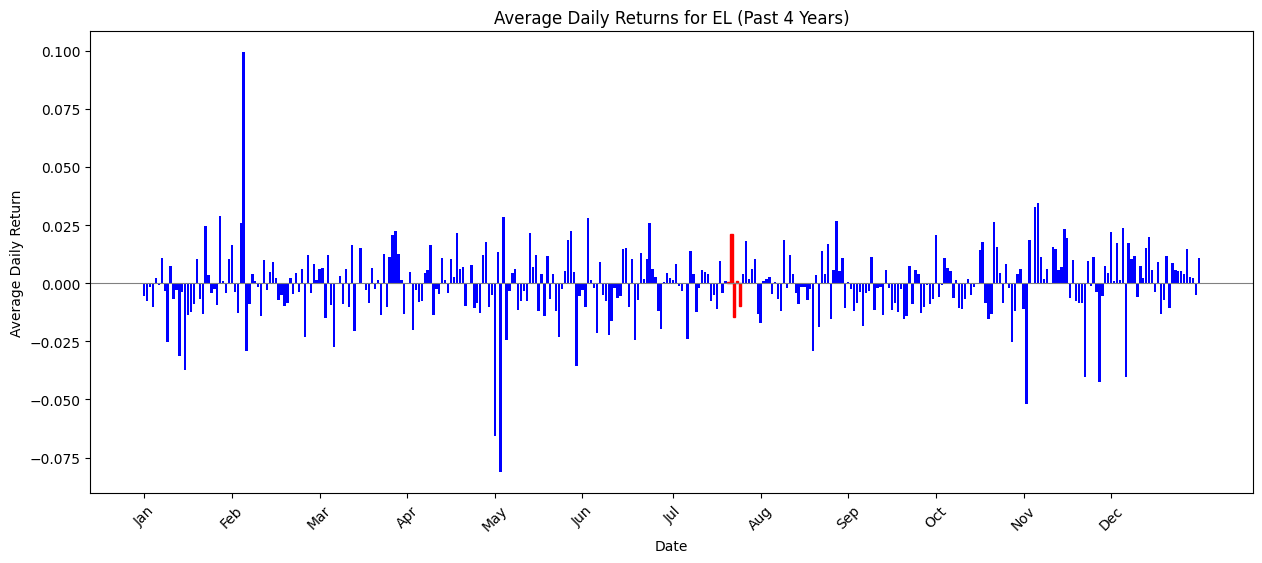

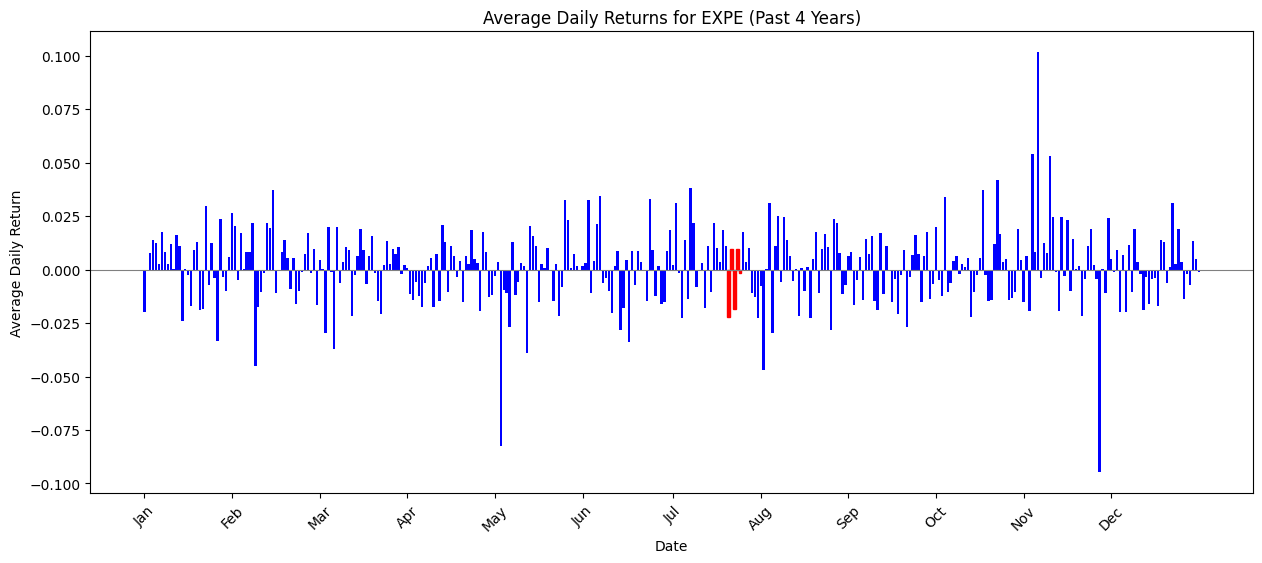

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

target_df = ['CRM', 'UBER', 'CMG', 'KHC', 'EL', 'EXPE']

# Ensure 'Date' is in the DataFrame
if 'Date' not in df.columns:
    print("Date column is missing from the dataset")
else:
    # Convert 'Date' column to datetime if not already done
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter for the past 4 years
    four_years_ago = pd.Timestamp.now() - pd.DateOffset(years=4)
    df_filtered = df[(df['Symbol'].isin(target_df)) & (df['Date'] >= four_years_ago)].copy()

    # Calculate daily returns
    df_filtered['Daily_Return'] = df_filtered.groupby('Symbol')['Adj Close'].pct_change()

    # Drop NaN values resulting from pct_change
    df_filtered.dropna(subset=['Daily_Return'], inplace=True)

    # Define the range of days to highlight (July 22 - July 26)
    highlight_days = ['07-22', '07-23', '07-24', '07-25', '07-26']

    # Seasonality analysis: Average daily return
    for stock in target_df:
        stock_df = df_filtered[df_filtered['Symbol'] == stock].copy()

        # Extract month and day from the Date
        stock_df['Month_Day'] = stock_df['Date'].dt.strftime('%m-%d')

        # Group by Month_Day and calculate the average return
        daily_avg_return = stock_df.groupby('Month_Day')['Daily_Return'].mean()

        # Plot the average daily returns
        plt.figure(figsize=(15, 6))
        bars = plt.bar(daily_avg_return.index, daily_avg_return.values, color='blue')
        
        # Highlight the specified days
        for i, date in enumerate(daily_avg_return.index):
            if date in highlight_days:
                bars[i].set_color('red')
        
        plt.title(f'Average Daily Returns for {stock} (Past 4 Years)')
        plt.xlabel('Date')
        plt.ylabel('Average Daily Return')

        # Create month labels for the x-axis at approximate intervals
        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_positions = [int(i * len(daily_avg_return) / 12) for i in range(12)]

        plt.xticks(ticks=month_positions, labels=month_labels, rotation=45)
        plt.axhline(0, color='gray', linewidth=0.8)
        
        plt.show()


* This next section will analyze each selected stock, and display the actual adjusted closing price over time (Adj Close), the 20-day rolling mean (smoothed trend), and the 20-day rolling standard deviation (volatility). The output from these graphs will is important information for people that intend on investing over a short-term investment period.

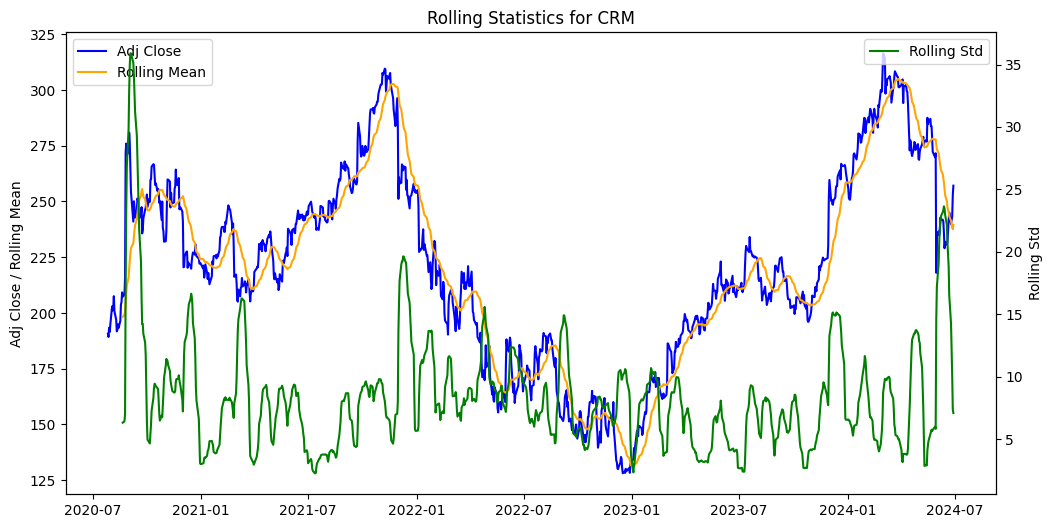

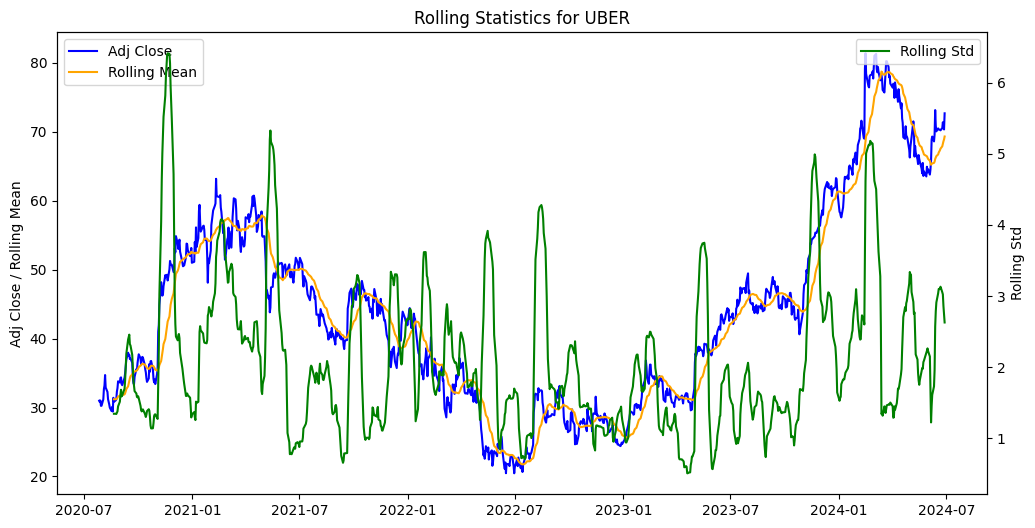

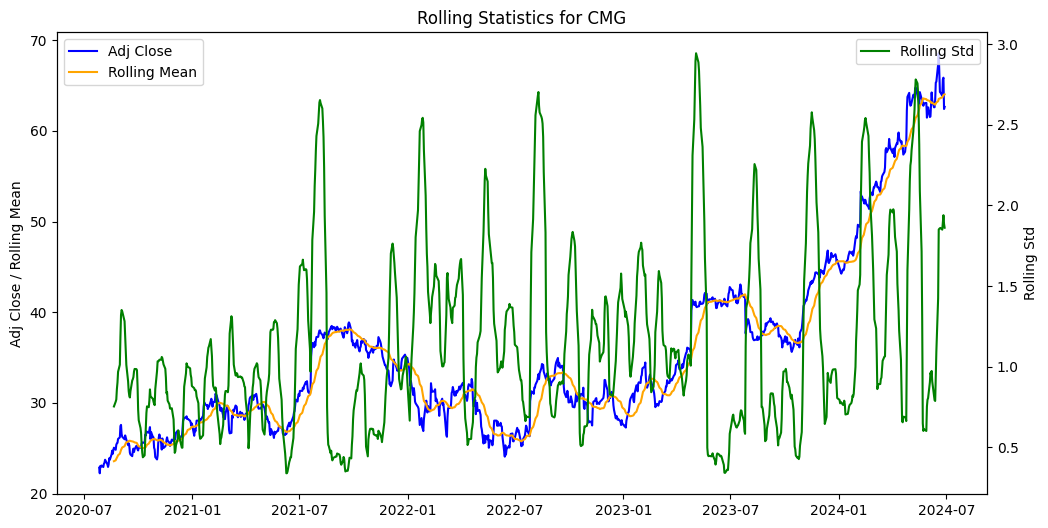

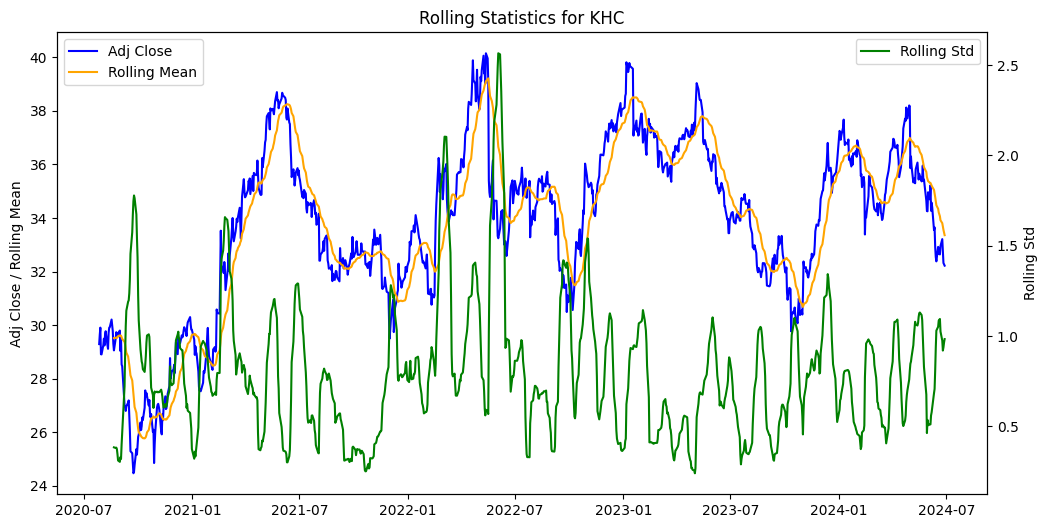

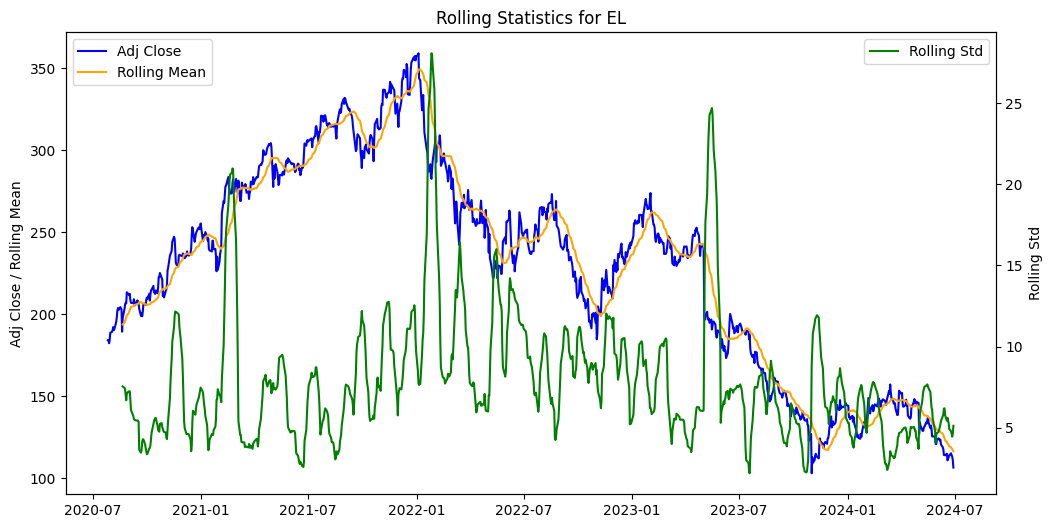

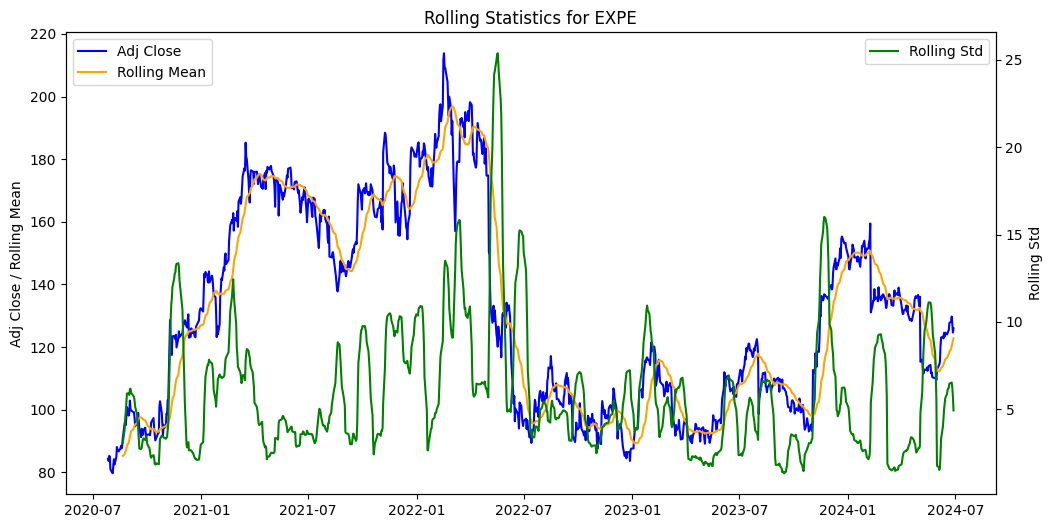

In [113]:
# Rolling Statistics for each stock
import pandas as pd
import matplotlib.pyplot as plt

for stock in target_df:
    stock_df = df_filtered[df_filtered['Symbol'] == stock].copy()

    # Ensure the index is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(stock_df.index):
        stock_df.index = pd.to_datetime(stock_df['Date'])

    # Rolling statistics
    if 'Adj Close' in stock_df.columns:
        stock_df.loc[:, 'Rolling_Mean'] = stock_df['Adj Close'].rolling(window=20).mean()
        stock_df.loc[:, 'Rolling_Std'] = stock_df['Adj Close'].rolling(window=20).std()

        # Plot rolling statistics
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.plot(stock_df['Adj Close'], label='Adj Close', color='blue')
        ax1.plot(stock_df['Rolling_Mean'], label='Rolling Mean', color='orange')
        ax1.set_ylabel('Adj Close / Rolling Mean')
        ax1.set_title(f'Rolling Statistics for {stock}')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(stock_df['Rolling_Std'], label='Rolling Std', color='green')
        ax2.set_ylabel('Rolling Std')
        ax2.legend(loc='upper right')

        plt.show()
    else:
        print(f"'Adj Close' column is not present for {stock}")


## Modelling

#### This section focuses on the creation of models to predict the price of each selected stock for the selected time period. We decided to create many models, and moving forward into the evaluation/deployment section of the project, we will only use the best performing models. The models that we are exploring are as follows:

* Model 1 - Historical Average Method

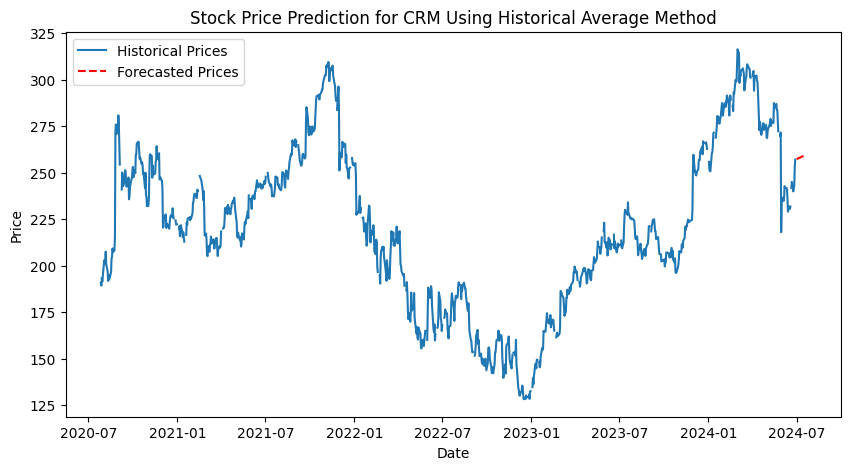

The final predicted closing price for CRM after 15 days is: 259.61


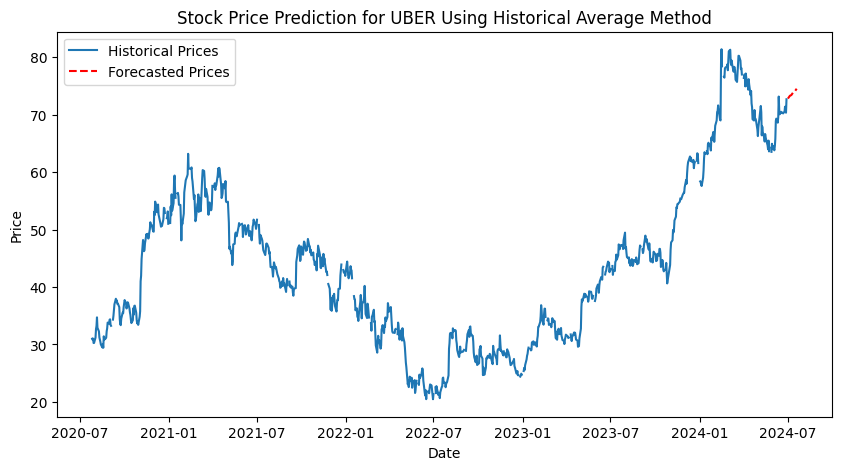

The final predicted closing price for UBER after 15 days is: 74.52


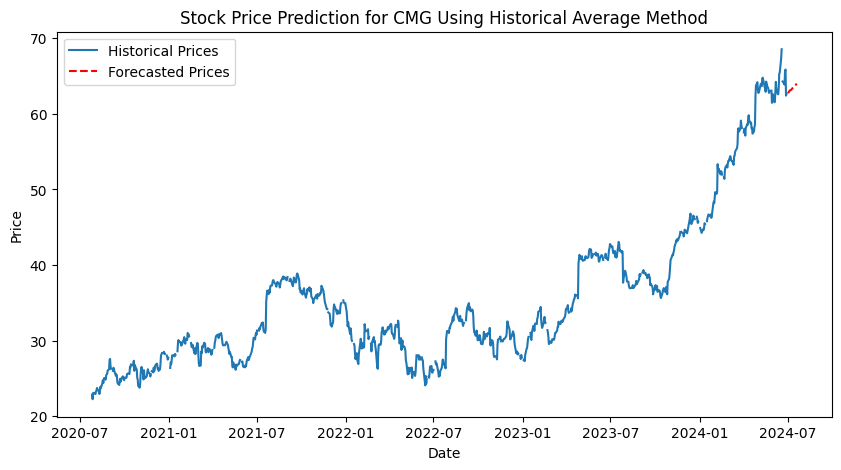

The final predicted closing price for CMG after 15 days is: 64.00


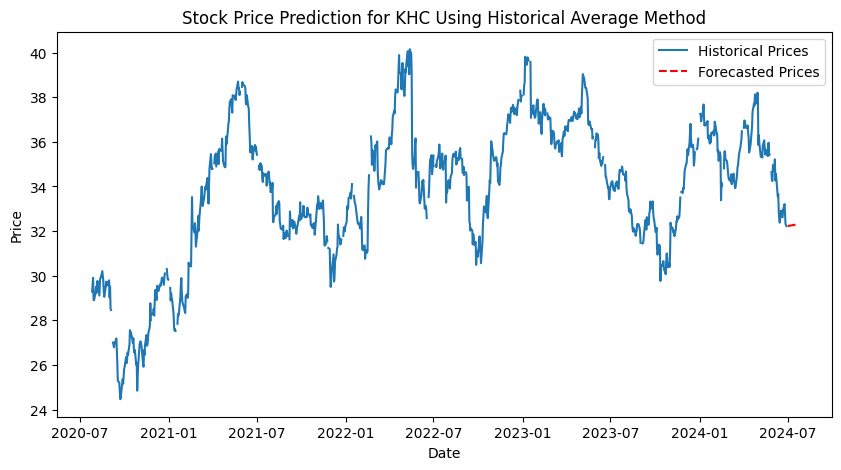

The final predicted closing price for KHC after 15 days is: 32.30


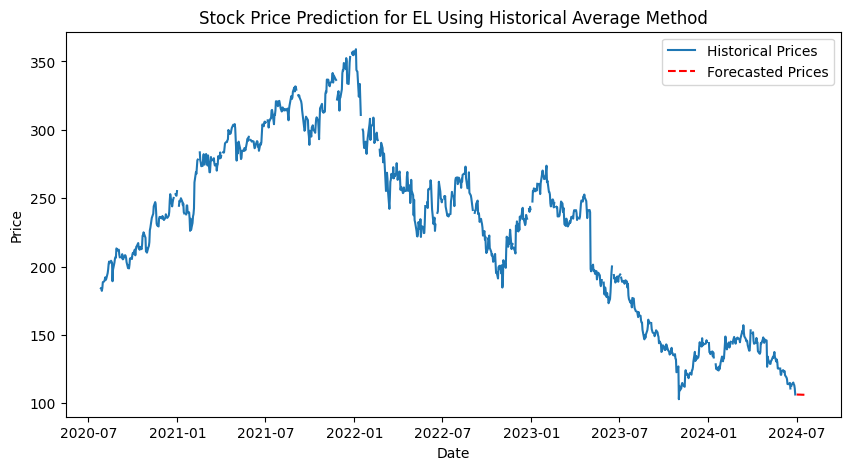

The final predicted closing price for EL after 15 days is: 106.15


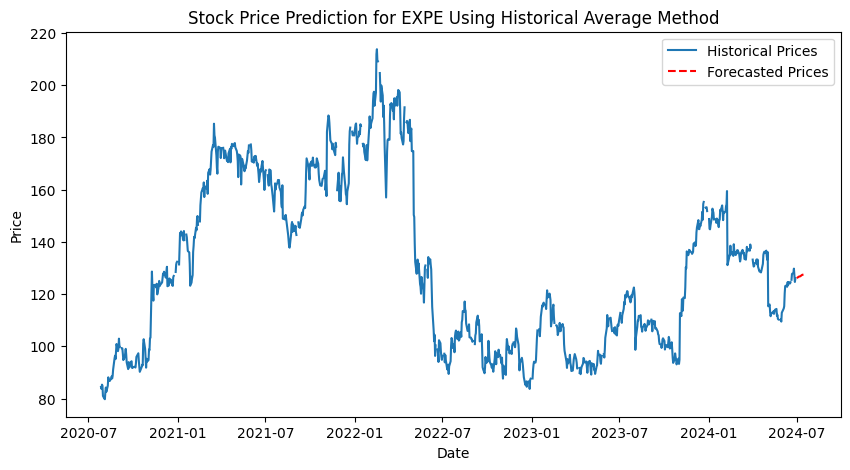

The final predicted closing price for EXPE after 15 days is: 128.07


In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to predict future prices using historical average method
def predict_future_prices(stock_prices, average_daily_return, prediction_days):
    last_price = stock_prices.iloc[-1]
    forecasted_prices = [last_price * (1 + average_daily_return) ** i for i in range(1, prediction_days + 1)]
    return forecasted_prices

# Loop through each selected stock and perform predictions
prediction_days = 15
for selected_stock in target_df:
    stock_df = df_filtered[df_filtered['Symbol'] == selected_stock].copy()
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.set_index('Date', inplace=True)
    stock_df = stock_df.asfreq('B')
    stock_prices = stock_df['Adj Close']
    daily_returns = stock_prices.pct_change(fill_method=None).dropna()
    average_daily_return = daily_returns.mean()
    forecast = predict_future_prices(stock_prices, average_daily_return, prediction_days)
    future_dates = pd.date_range(start=stock_prices.index[-1], periods=prediction_days + 1, freq='B')[1:]
    plt.figure(figsize=(10, 5))
    plt.plot(stock_prices.index, stock_prices, label='Historical Prices')
    plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='--')
    plt.title(f'Stock Price Prediction for {selected_stock} Using Historical Average Method')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    final_predicted_price = forecast[-1]
    print(f"The final predicted closing price for {selected_stock} after {prediction_days} days is: {final_predicted_price:.2f}")

#### This model predicts the future stock prices by calculating the average daily return based on historical prices. It then uses this average return to forecast prices for the next 15 days and plots the historical and forecasted prices for each stock. The model assumes that past performance trends and average returns will continue into the near future, providing a basis for predicting future prices.

#### Since we know the 15-day actual price and predicted price, we can assign a score to each bu dividing the 15-day predicted price by the 15-day actual price (July 19th closing Price). The the close the score is to zero, the better the model is, and we can assume that the model would also be accurate in predicting the 20-day forward price.

* FORMULA: ( (predicted 15 day forward price based on model) / (actual price based on yahoo finance closing price) ) - 1

* CRM - 0.0484
* UBER - 0.1061
* CMG - 0.1950
* KHC - (0.0245)
* EL - 0.0701
* EXPE - (0.0581)

#### Despite the fact that we know this model is not as accurate as we would like, let's run this model with the 20-day forward price.

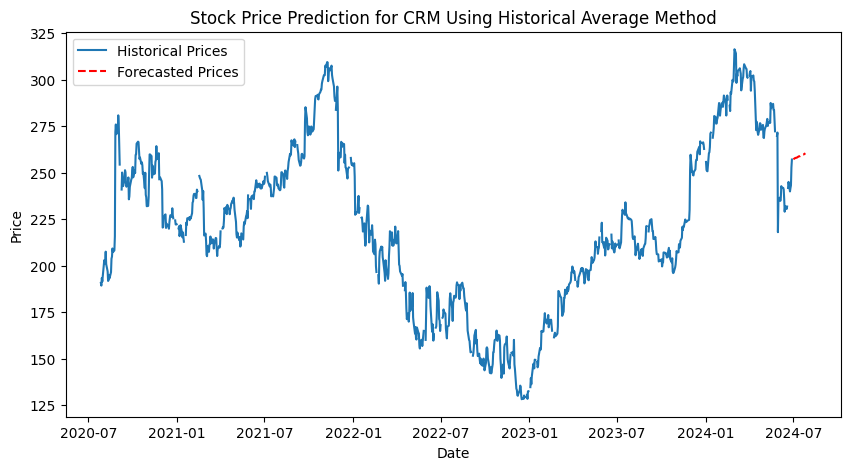

The final predicted closing price for CRM after 20 days is: 260.45


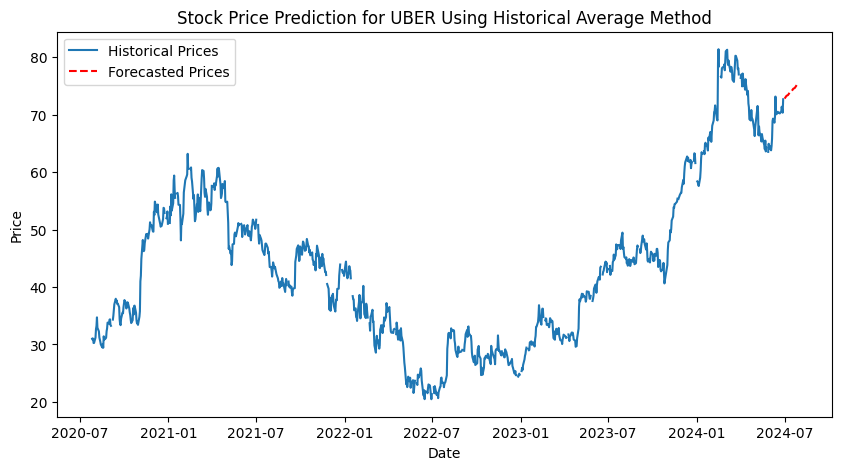

The final predicted closing price for UBER after 20 days is: 75.14


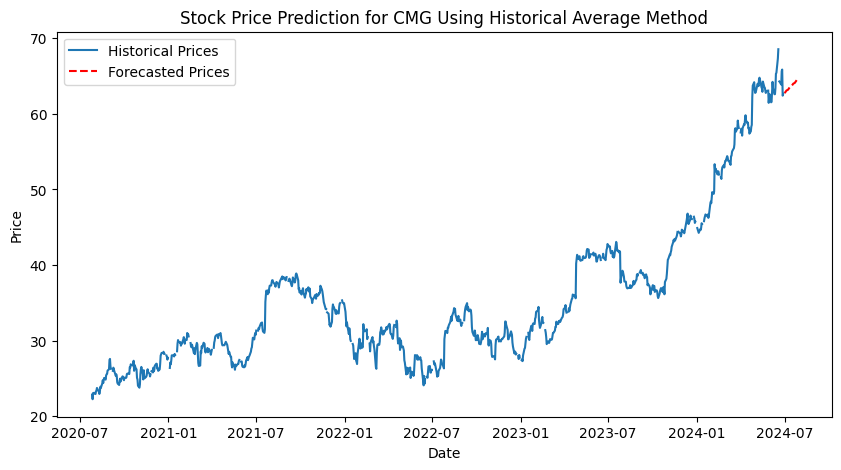

The final predicted closing price for CMG after 20 days is: 64.46


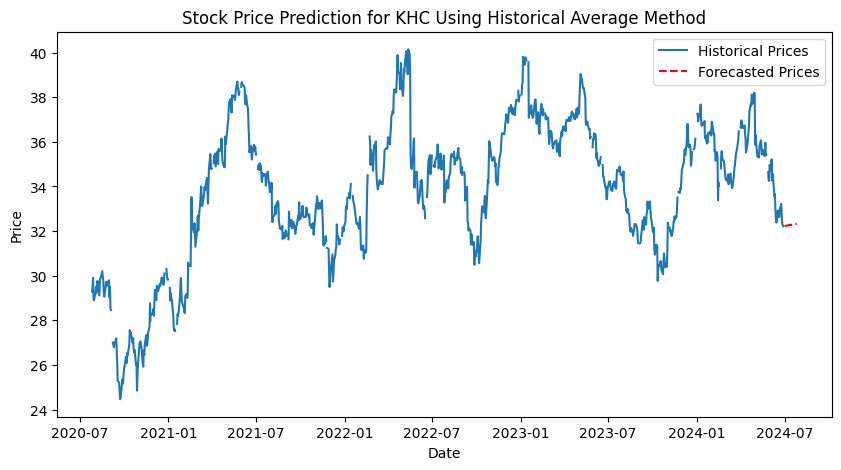

The final predicted closing price for KHC after 20 days is: 32.33


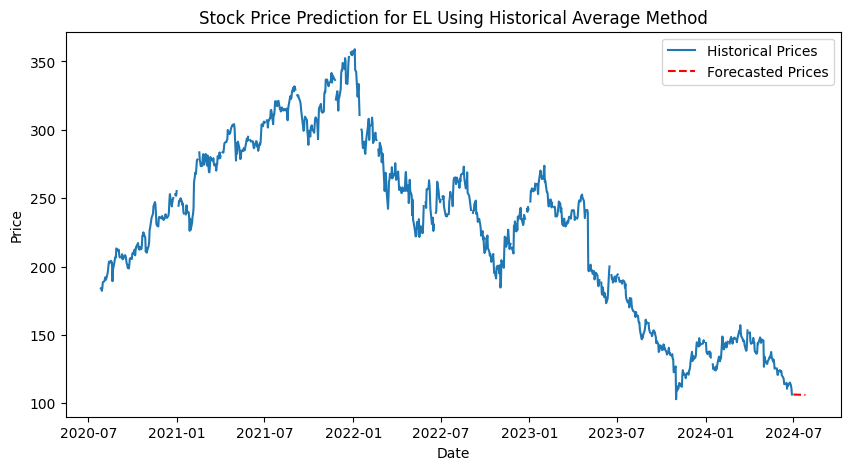

The final predicted closing price for EL after 20 days is: 106.06


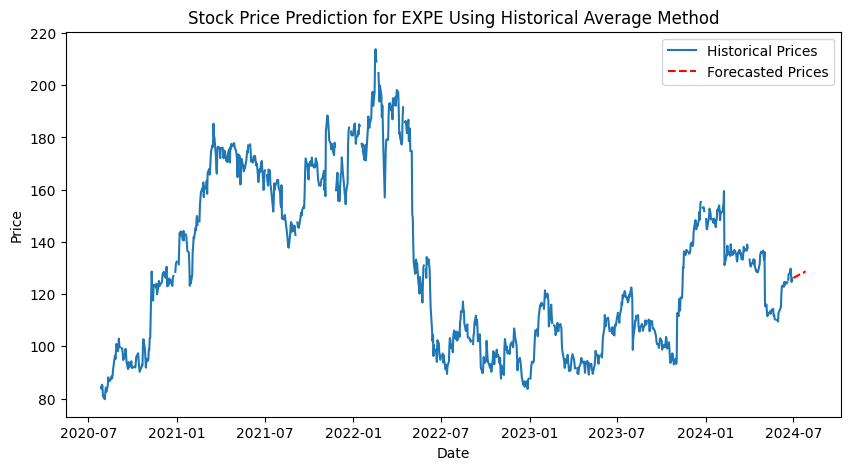

The final predicted closing price for EXPE after 20 days is: 128.78


In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to predict future prices using historical average method
def predict_future_prices(stock_prices, average_daily_return, prediction_days):
    last_price = stock_prices.iloc[-1]
    forecasted_prices = [last_price * (1 + average_daily_return) ** i for i in range(1, prediction_days + 1)]
    return forecasted_prices

# Loop through each selected stock and perform predictions
prediction_days = 20
for selected_stock in target_df:
    stock_df = df_filtered[df_filtered['Symbol'] == selected_stock].copy()
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.set_index('Date', inplace=True)
    stock_df = stock_df.asfreq('B')
    stock_prices = stock_df['Adj Close']
    daily_returns = stock_prices.pct_change(fill_method=None).dropna()
    average_daily_return = daily_returns.mean()
    forecast = predict_future_prices(stock_prices, average_daily_return, prediction_days)
    future_dates = pd.date_range(start=stock_prices.index[-1], periods=prediction_days + 1, freq='B')[1:]
    plt.figure(figsize=(10, 5))
    plt.plot(stock_prices.index, stock_prices, label='Historical Prices')
    plt.plot(future_dates, forecast, label='Forecasted Prices', color='red', linestyle='--')
    plt.title(f'Stock Price Prediction for {selected_stock} Using Historical Average Method')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    final_predicted_price = forecast[-1]
    print(f"The final predicted closing price for {selected_stock} after {prediction_days} days is: {final_predicted_price:.2f}")

#### For reasons discussed among the group, this model was NOT used in the report OR the presentation.

#### Moving on to our second model, we will be testing the fit of all the predictive models covered in-class to determine which fits best. Next we evaluate all the created variables and will use the top 5 in terms of R squared on the Adj Close of each stock to use them in our model. From there we create the model and predict out to 2024-07-19 which is the last trading day before submission (this allows for sensitivity check to compare to real life value if the model is accurate) as well 2024-07-26 as that is the date we will be selling. The goal is to see the return of the stocks as well as the allocation we would perform based on this model alone which can be seen at the end of the section.

Model evaluation results (sorted by MSE):
                    MSE
Linear Regression  0.17
Gradient Boosting  3.25
XGBoost            3.48
Random Forest      3.50
Decision Tree      3.74
SVR               24.71
KNN (Euclidean)     NaN
KNN (Manhattan)     NaN
KNN (Minkowski)     NaN


<Figure size 1400x1400 with 0 Axes>

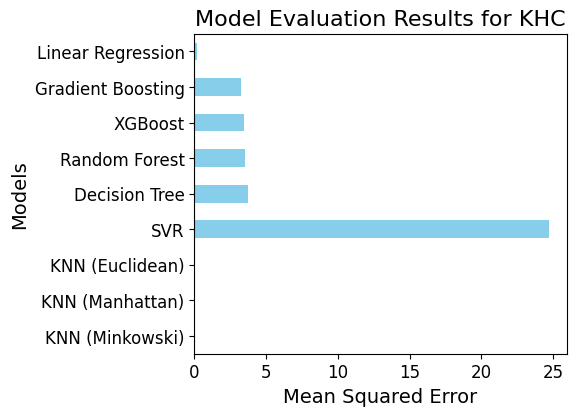

In [116]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

#Deal with NA values
KHC_df.replace([np.inf, -np.inf], np.nan, inplace=True)
KHC_df.dropna(inplace=True)

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = KHC_df[selected_features]
y = KHC_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results
plt.figure(figsize=(14, 14))
ax = results_df.plot(kind='barh', legend=False, color='skyblue')
ax.set_xlabel("Mean Squared Error", fontsize=14)
ax.set_ylabel("Models", fontsize=14)
ax.set_title("Model Evaluation Results for KHC", fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

* The above code evaluates the various predictive models covered in class and evaluates the ability to predict the Adj Close of the stock, in this case KHC. each model is traned and evaluated using 5-fold cross-validation, with the MSE being sored and compared. AS we can see Linear Regression provides the lowest MSE so this is the model we will move forward with.

Feature evaluation results (sorted by R-squared):
                  R-squared
lag1                   0.99
MA_5                   0.99
MA_10                  0.97
EMA_12                 0.97
lag5                   0.94
MA_20                  0.92
Bollinger_Low          0.90
Bollinger_High         0.89
lag10                  0.88
lag20                  0.76
EMA_26                 0.73
OBV                    0.65
RSI*Adj_Close          0.43
VPT                    0.24
MACD                   0.18
MACD*EMA_12            0.17
Adj Close/Volume       0.16
RSI                    0.13
Volume_MA_10           0.06
ADX                    0.06
Stoch_Osc*ADX          0.05
Mstd_5                 0.05
Volume_MA_5            0.05
Mstd_20                0.04
Mstd_10                0.04
Stoch_Osc              0.03
Adj Close*Volume       0.03
CCI                    0.03
EMA_12*Volume          0.03
RSI*Volume             0.02
Month                  0.01
Quarter                0.01
is_quarter_end         0.0

<Figure size 1400x1400 with 0 Axes>

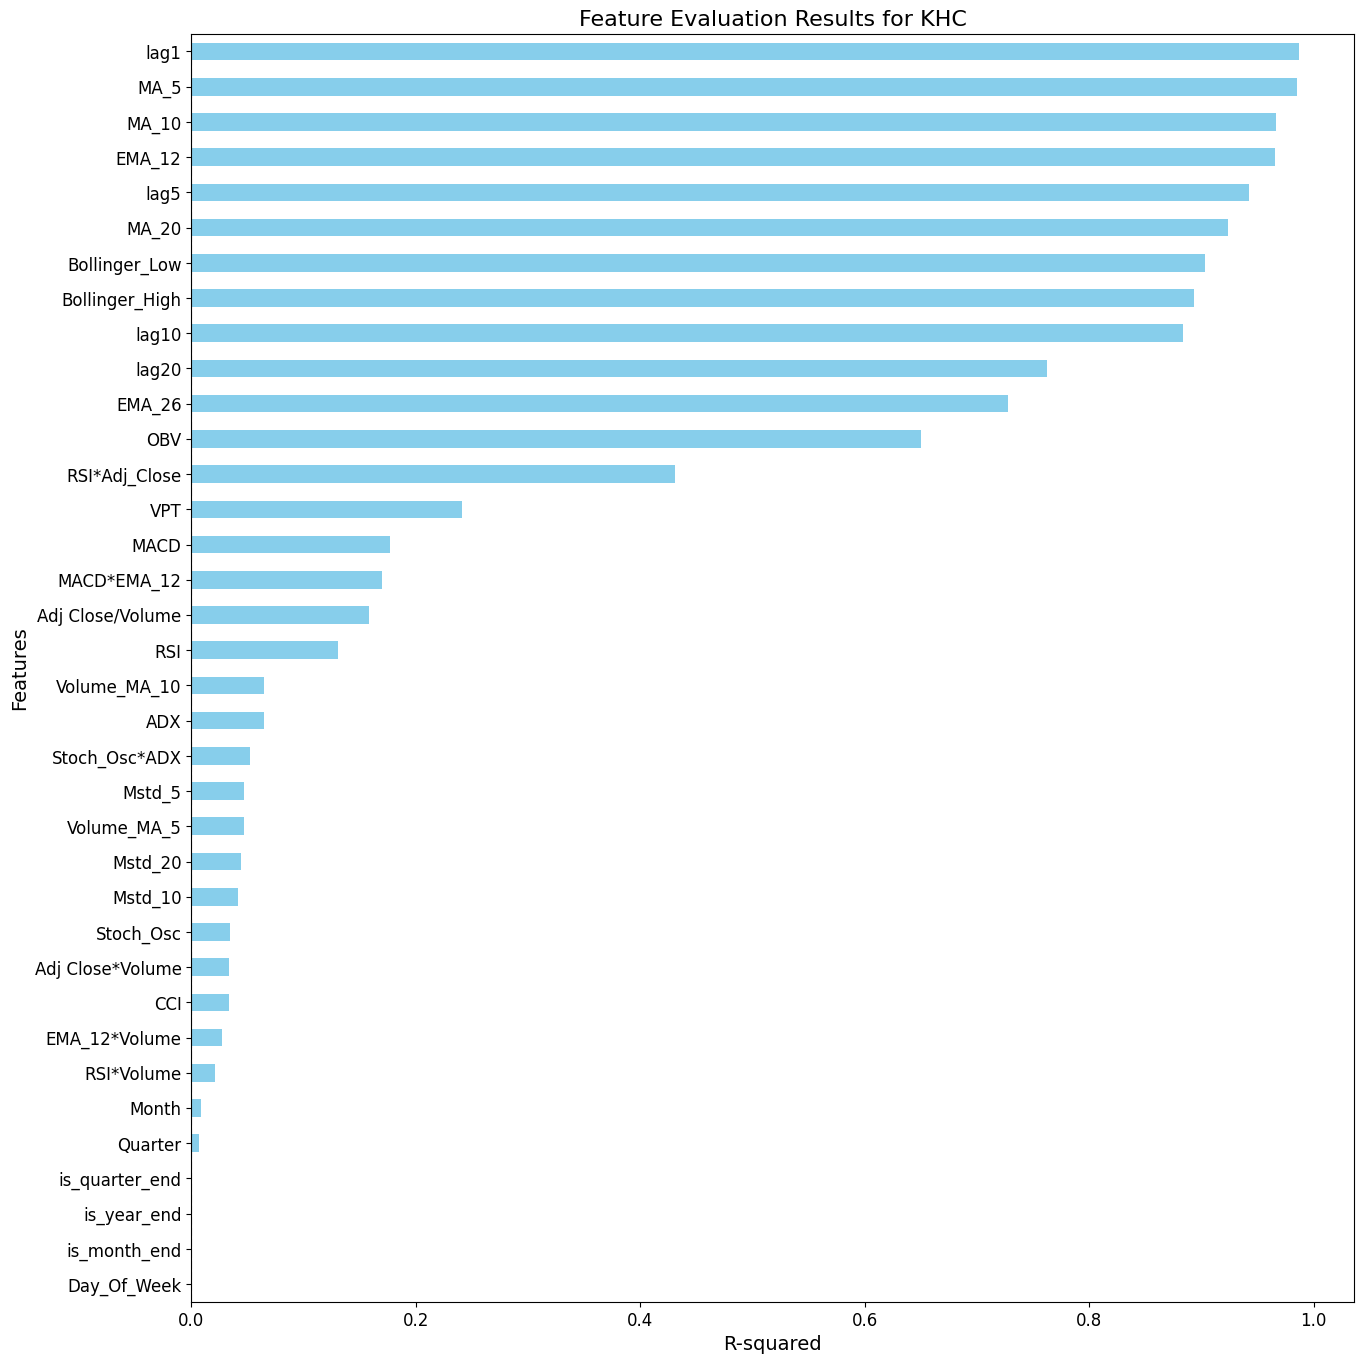

In [117]:
# List of all features
features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

# Initialize a dictionary to hold R-squared values
r2_scores = {}

# Evaluate each feature individually
for feature in features:
    X = KHC_df[[feature]]
    y = KHC_df['Adj Close']
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores[feature] = r2

# Convert the R-squared scores to a DataFrame and sort by R-squared in descending order
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])
r2_df = r2_df.sort_values(by='R-squared', ascending=False)

print("Feature evaluation results (sorted by R-squared):")
print(r2_df)

# Plot the R-squared values
plt.figure(figsize=(14, 14))
ax = r2_df.plot(kind='barh', legend=False, color='skyblue', figsize=(14, 14))
ax.set_xlabel("R-squared", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_title("Feature Evaluation Results for KHC", fontsize=16)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=2.0)
plt.show()

* Above shows the predictive power of each individual variable created during the EDA section on the Adj Close variable through a linear regression model evaluated by R-square. These are sorted in descending order where we will be using the top 5 in our predictive model. lag1, MA_5, MA_10, EMA_12 and lag5 are strong predictors indicating that past prices, moving averages and exponential moving averages are useful to predict todays price

Model Performance Statistics:
R-squared: 0.9894
Mean Absolute Error (MAE): 0.3245
Mean Squared Error (MSE): 0.2039
Root Mean Squared Error (RMSE): 0.4516
Cross-Validation R-squared: 0.9646 ± 0.0119


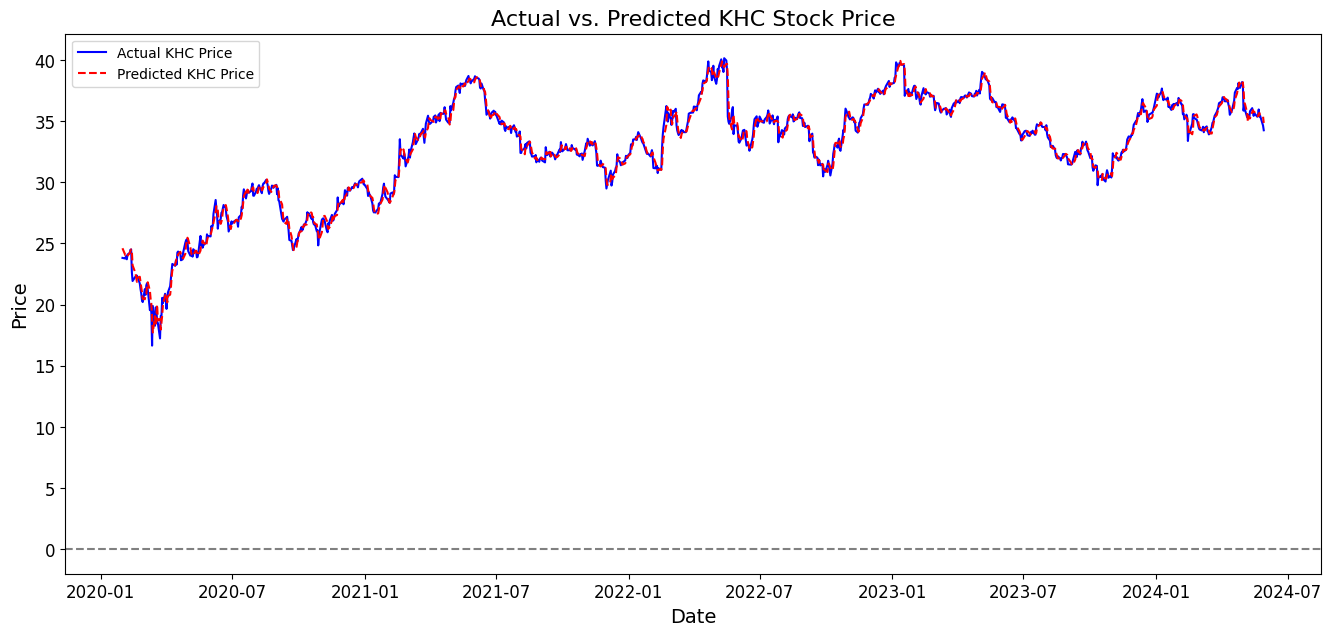

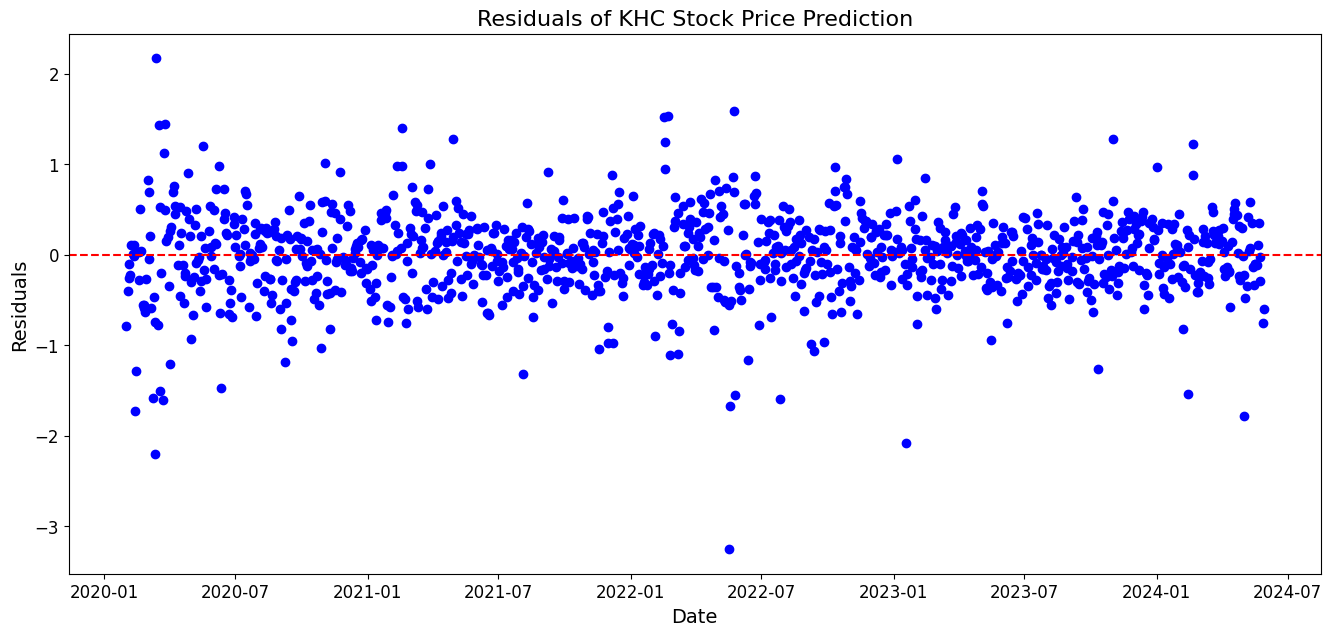

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Assuming KHC_df is the DataFrame containing the data
# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = KHC_df[selected_features]
y = KHC_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
KHC_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, KHC_df['Predicted'])
mae = mean_absolute_error(y, KHC_df['Predicted'])
mse = mean_squared_error(y, KHC_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(KHC_df['Date'], KHC_df['Adj Close'], label='Actual KHC Price', color='blue')
plt.plot(KHC_df['Date'], KHC_df['Predicted'], label='Predicted KHC Price', linestyle='--', color='red')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted KHC Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
KHC_df['Residuals'] = y - KHC_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(KHC_df['Date'], KHC_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of KHC Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

* The code fits a linear regression model to predict KHC's adjusted closing stock prices using the five selected features above. It evaluates the model's performance with impressive results, including a R-squared value of 0.9892 and low errors (MAE: 0.3244, MSE: 0.2030, RMSE: 0.4506). Cross-validation confirms the model's minimal overfitting with a mean R-squared of 0.9641. Visualizations show a close match between actual and predicted prices, indicating the model's effectiveness in capturing stock price trends accurately.

Model Performance Statistics:
R-squared: 0.9894
Mean Absolute Error (MAE): 0.3245
Mean Squared Error (MSE): 0.2039
Root Mean Squared Error (RMSE): 0.4516
Cross-Validation R-squared: 0.9646 ± 0.0119


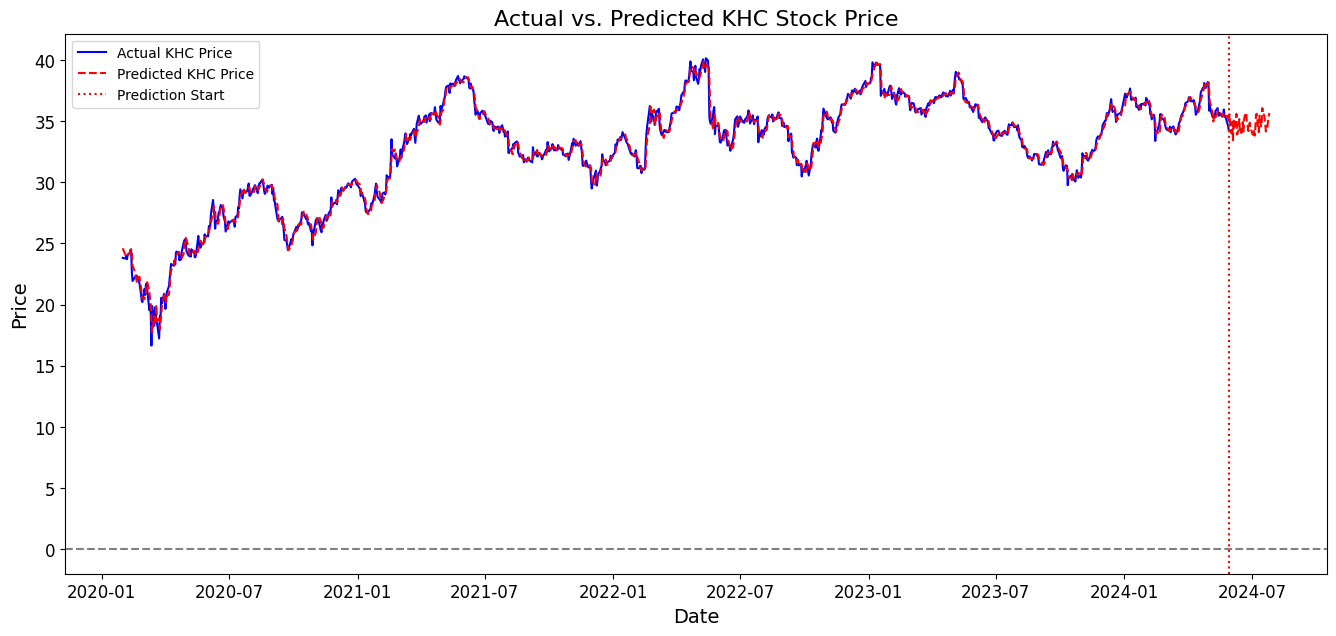

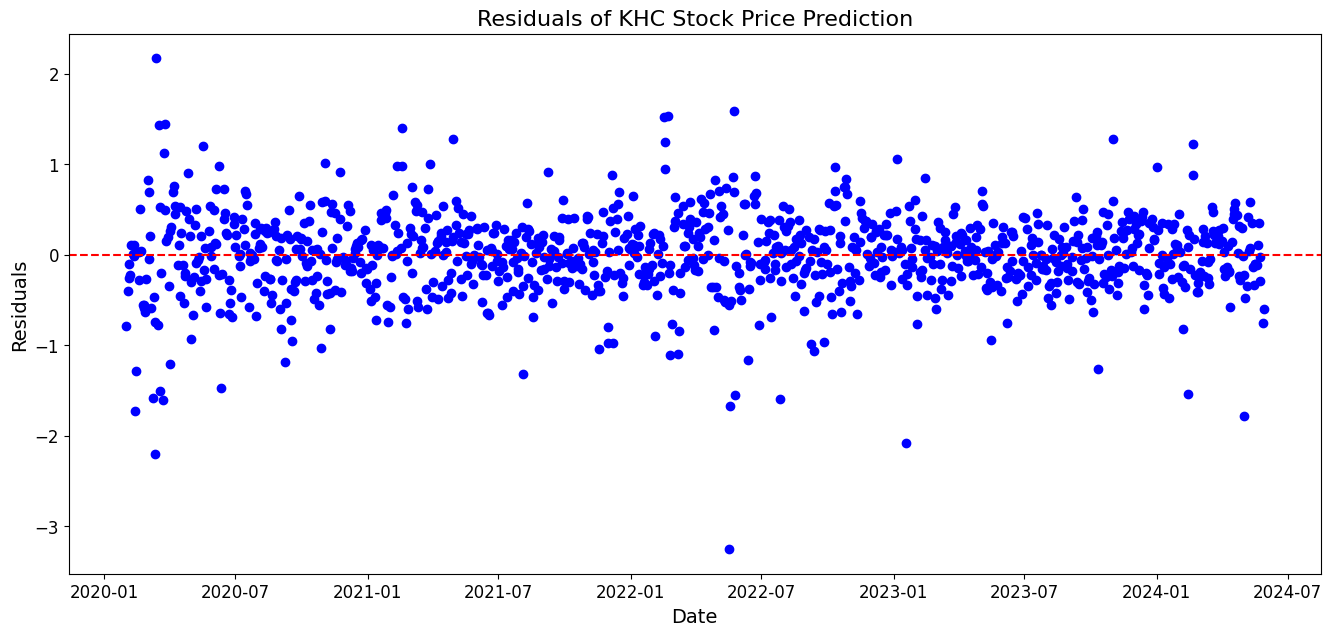

The predicted KHC stock price for 2024-07-19 is: 35.38
The predicted KHC stock price for 2024-07-26 is: 35.67


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Load x and y
X = KHC_df[selected_features]
y = KHC_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
KHC_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, KHC_df['Predicted'])
mae = mean_absolute_error(y, KHC_df['Predicted'])
mse = mean_squared_error(y, KHC_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = KHC_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = KHC_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([KHC_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([KHC_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([KHC_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = KHC_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([KHC_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual KHC Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted KHC Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted KHC Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
KHC_df['Residuals'] = y - KHC_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(KHC_df['Date'], KHC_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of KHC Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19,and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted KHC stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted KHC stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


* Using the model above we predicted out to the last known price before the due date at 2024-07-19, this allowed us to sensitivity test our model with real data to ensure the prices were realistic in a real world setting. The prices were predicted using a rolling window approach which takes into account each day of predicted values into account for the next day. We also added a random shock based on the stocks history to try and create more realistic unpredictability in fluctuations that we observe in the open market

Model Performance Statistics:
R-squared: 0.9894
Mean Absolute Error (MAE): 0.3245
Mean Squared Error (MSE): 0.2039
Root Mean Squared Error (RMSE): 0.4516
Cross-Validation R-squared: 0.9646 ± 0.0119


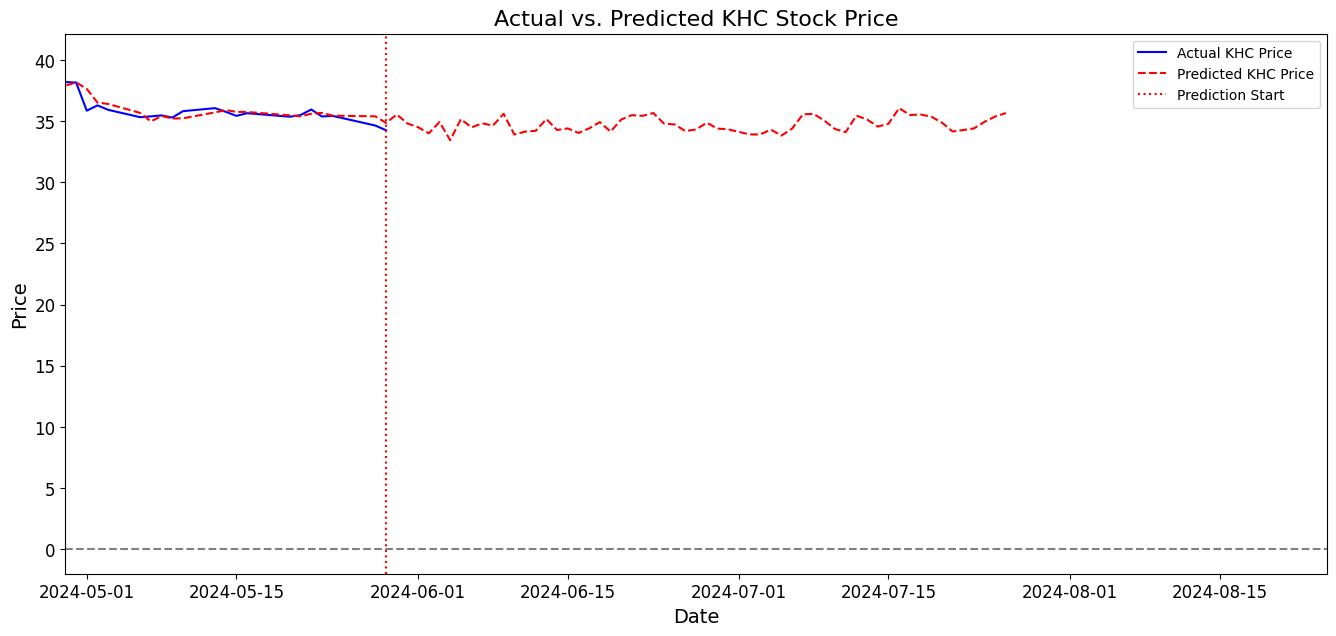

The actual KHC stock price on the last day of the data (2024-05-29) is: 34.26
The predicted KHC stock price for 2024-07-19 is: 35.38
The predicted KHC stock price for 2024-07-26 is: 35.67


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Load x and y
X = KHC_df[selected_features]
y = KHC_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
KHC_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, KHC_df['Predicted'])
mae = mean_absolute_error(y, KHC_df['Predicted'])
mse = mean_squared_error(y, KHC_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = KHC_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Initialize the future features with the last known values
last_known_values = KHC_df.iloc[-1]

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=selected_features + ['Predicted'])

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([KHC_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([KHC_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([KHC_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = KHC_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([KHC_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values with zoom
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual KHC Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted KHC Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted KHC Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = KHC_df.iloc[-1]['Adj Close']
print(f"The actual KHC stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19 and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted KHC stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted KHC stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


* This is a zoomed in photo of the model discussed above where you can see that for each day of the predicting period there is a new price predicted and it emulates the volatility throughout the stocks history.

#### Now, starting UBER. We are not going to thoroughly markdown the remaining companies for model #2

#### Starting Model 2 Application for UBER:

Model evaluation results (sorted by MSE):
                     MSE
Linear Regression   0.26
Gradient Boosting  18.25
Random Forest      18.48
XGBoost            18.83
Decision Tree      20.26
SVR               292.91
KNN (Euclidean)      NaN
KNN (Manhattan)      NaN
KNN (Minkowski)      NaN


<Figure size 1400x1400 with 0 Axes>

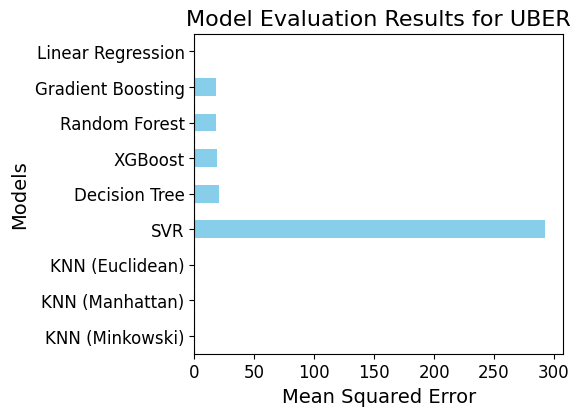

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Filter the dataset for UBER
UBER_df = df[df['Symbol'] == 'UBER'].copy()

# Drop rows with any NaN values
UBER_df = UBER_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = UBER_df[selected_features]
y = UBER_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results with the desired layout
plt.figure(figsize=(14, 14))  # Increased figure height for more space
ax = results_df.plot(kind='barh', legend=False, color='skyblue')
ax.set_xlabel("Mean Squared Error", fontsize=14)
ax.set_ylabel("Models", fontsize=14)
ax.set_title("Model Evaluation Results for UBER", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest MSE at the top
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)  # Adjust padding for more space
plt.show()


Model evaluation results (sorted by MSE):
                     MSE
Linear Regression   0.26
Gradient Boosting  17.96
Random Forest      18.17
XGBoost            18.83
Decision Tree      19.97
SVR               292.91
KNN (Euclidean)      NaN
KNN (Manhattan)      NaN
KNN (Minkowski)      NaN


<Figure size 1400x1400 with 0 Axes>

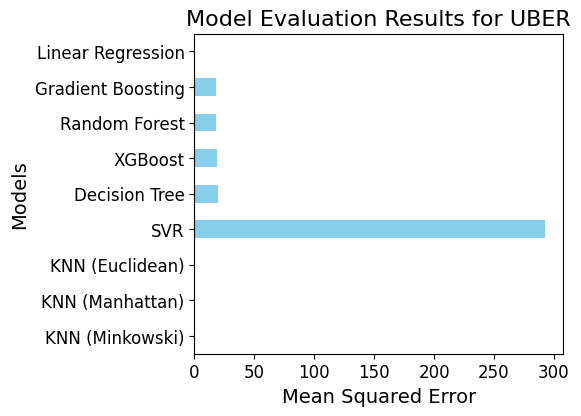

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Filter the dataset for UBER
UBER_df = df[df['Symbol'] == 'UBER'].copy()

# Drop rows with any NaN values
UBER_df = UBER_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = UBER_df[selected_features]
y = UBER_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results with the desired layout
plt.figure(figsize=(14, 14))  # Increased figure height for more space
ax = results_df.plot(kind='barh', legend=False, color='skyblue')
ax.set_xlabel("Mean Squared Error", fontsize=14)
ax.set_ylabel("Models", fontsize=14)
ax.set_title("Model Evaluation Results for UBER", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest MSE at the top
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)  # Adjust padding for more space
plt.show()


Model Performance Statistics:
R-squared: 0.9928
Mean Absolute Error (MAE): 0.8764
Mean Squared Error (MSE): 1.3573
Root Mean Squared Error (RMSE): 1.1650
Cross-Validation R-squared: 0.9724 ± 0.0120


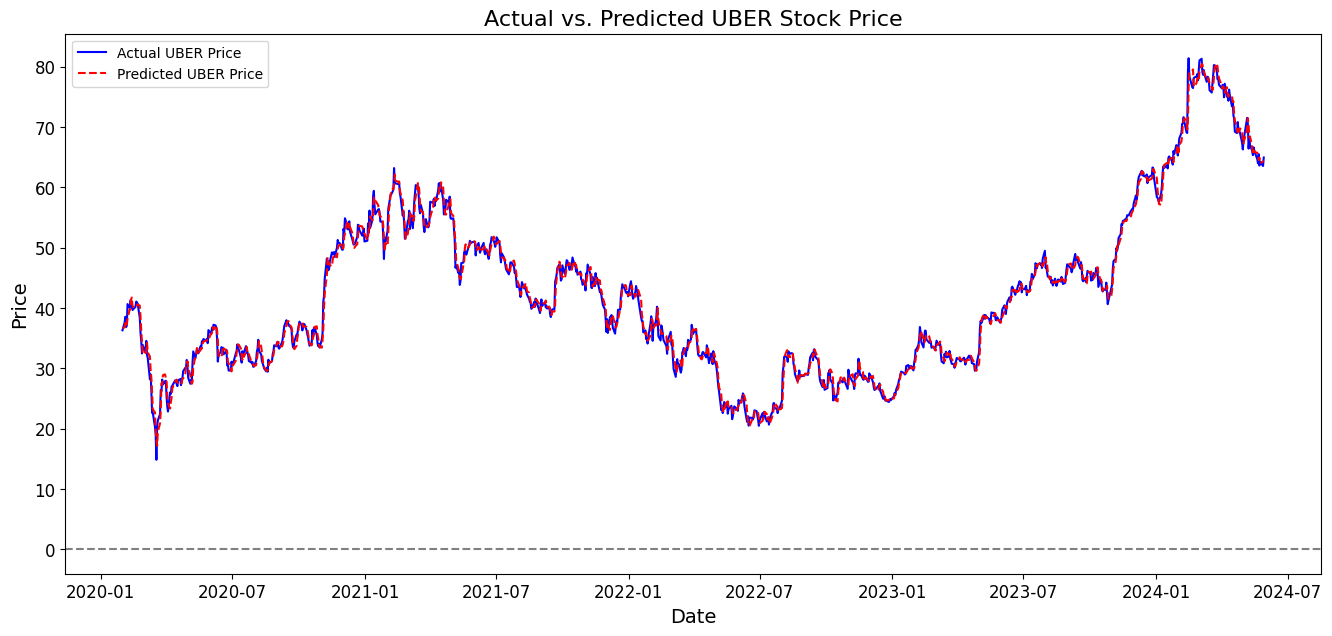

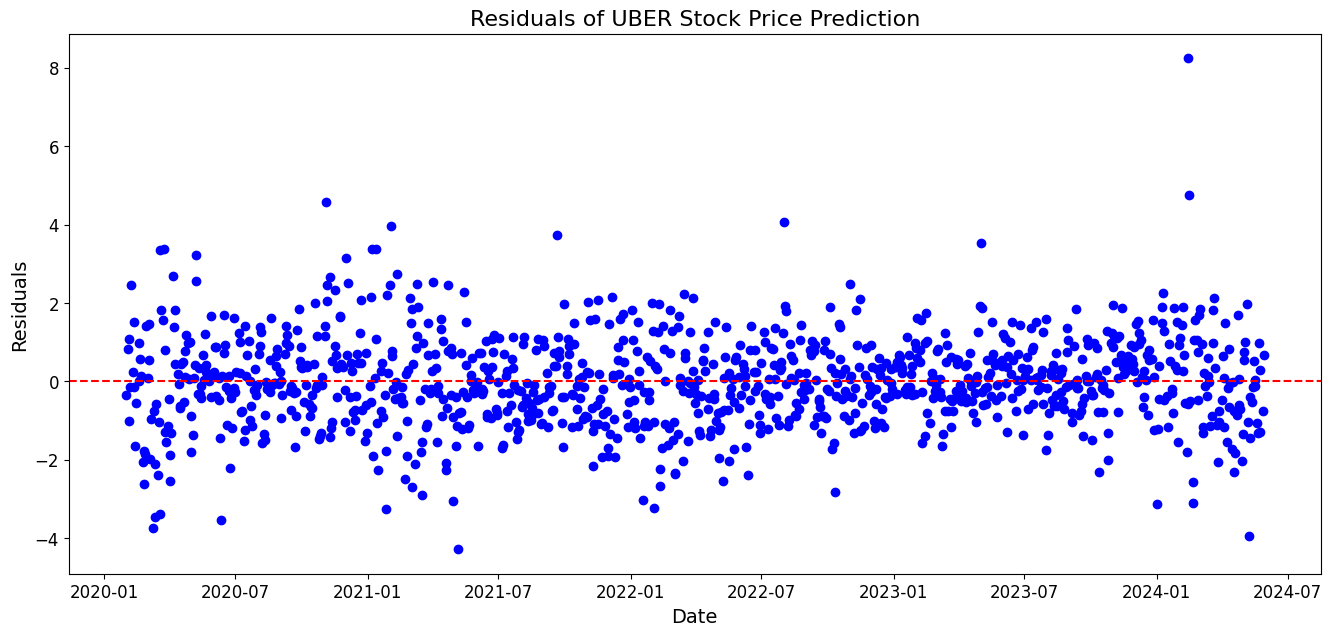

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = UBER_df[selected_features]
y = UBER_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
UBER_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, UBER_df['Predicted'])
mae = mean_absolute_error(y, UBER_df['Predicted'])
mse = mean_squared_error(y, UBER_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(UBER_df['Date'], UBER_df['Adj Close'], label='Actual UBER Price', color='blue')
plt.plot(UBER_df['Date'], UBER_df['Predicted'], label='Predicted UBER Price', linestyle='--', color='red')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted UBER Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
UBER_df['Residuals'] = y - UBER_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(UBER_df['Date'], UBER_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of UBER Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9928
Mean Absolute Error (MAE): 0.8764
Mean Squared Error (MSE): 1.3573
Root Mean Squared Error (RMSE): 1.1650
Cross-Validation R-squared: 0.9724 ± 0.0120


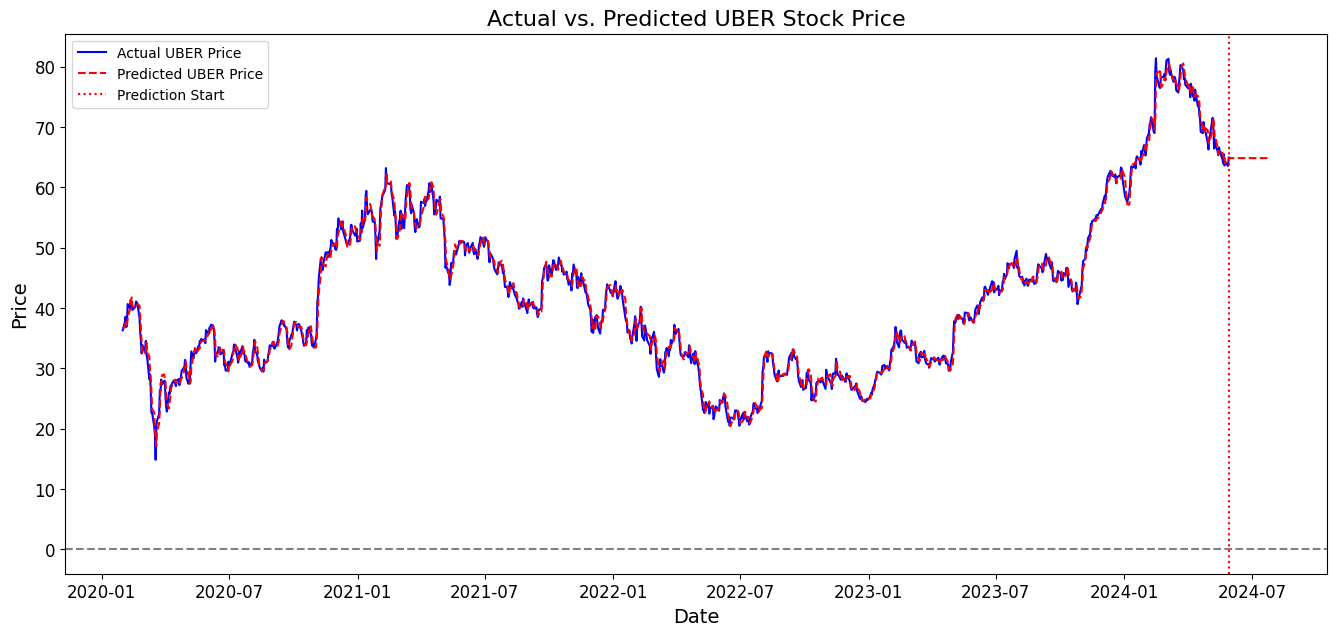

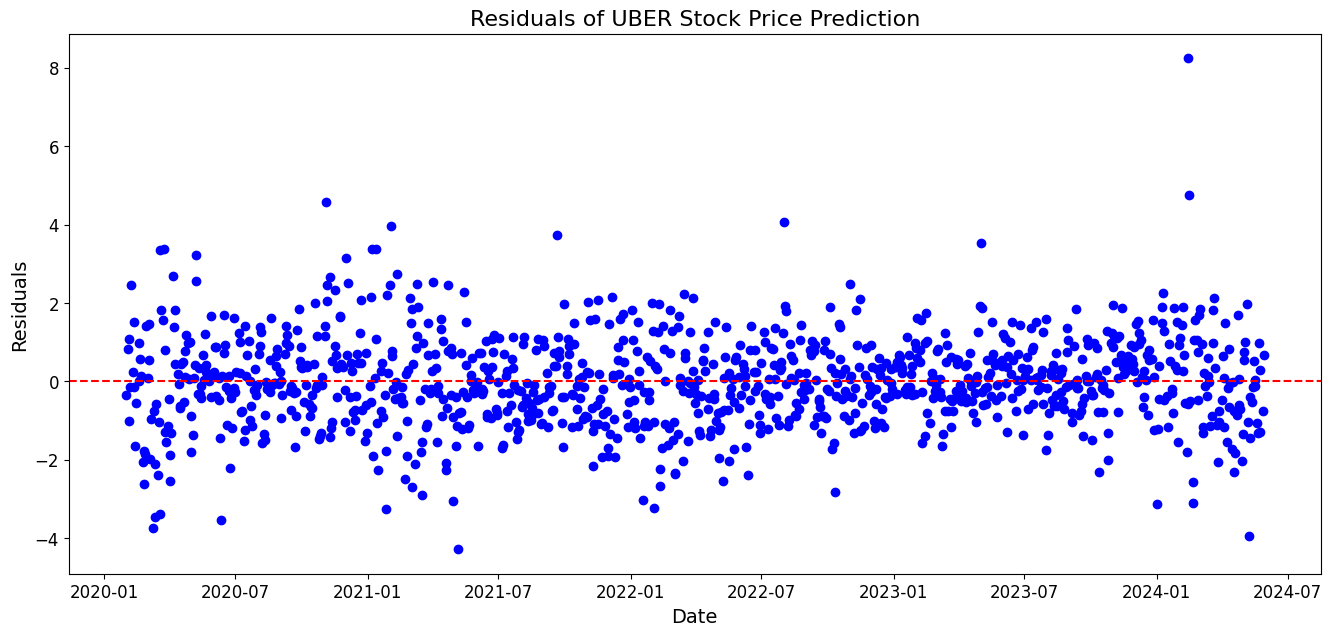

The predicted UBER stock price for 2024-07-19 is: 64.83
The predicted UBER stock price for 2024-07-26 is: 64.83


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Ensure the 'Date' column is in datetime format
UBER_df['Date'] = pd.to_datetime(UBER_df['Date'])

# Load x and y
X = UBER_df[selected_features]
y = UBER_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
UBER_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, UBER_df['Predicted'])
mae = mean_absolute_error(y, UBER_df['Predicted'])
mse = mean_squared_error(y, UBER_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = UBER_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = UBER_df.iloc[-1]

# Predict future prices iteratively
for future_date in future_dates:
    future_features = pd.DataFrame({
        'lag1': [last_known_values['Adj Close']],
        'MA_5': [UBER_df['Adj Close'].rolling(window=5).mean().iloc[-1]],
        'MA_10': [UBER_df['Adj Close'].rolling(window=10).mean().iloc[-1]],
        'EMA_12': [last_known_values['EMA_12']],
        'lag5': [UBER_df['Adj Close'].shift(5).iloc[-1]]
    }, index=[future_date])
    
    future_price = model.predict(future_features)[0]
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values for the next iteration
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12'][0]
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([UBER_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual UBER Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted UBER Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted UBER Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
UBER_df['Residuals'] = y - UBER_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(UBER_df['Date'], UBER_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of UBER Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted UBER stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted UBER stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


Model Performance Statistics:
R-squared: 0.9928
Mean Absolute Error (MAE): 0.8764
Mean Squared Error (MSE): 1.3573
Root Mean Squared Error (RMSE): 1.1650
Cross-Validation R-squared: 0.9724 ± 0.0120


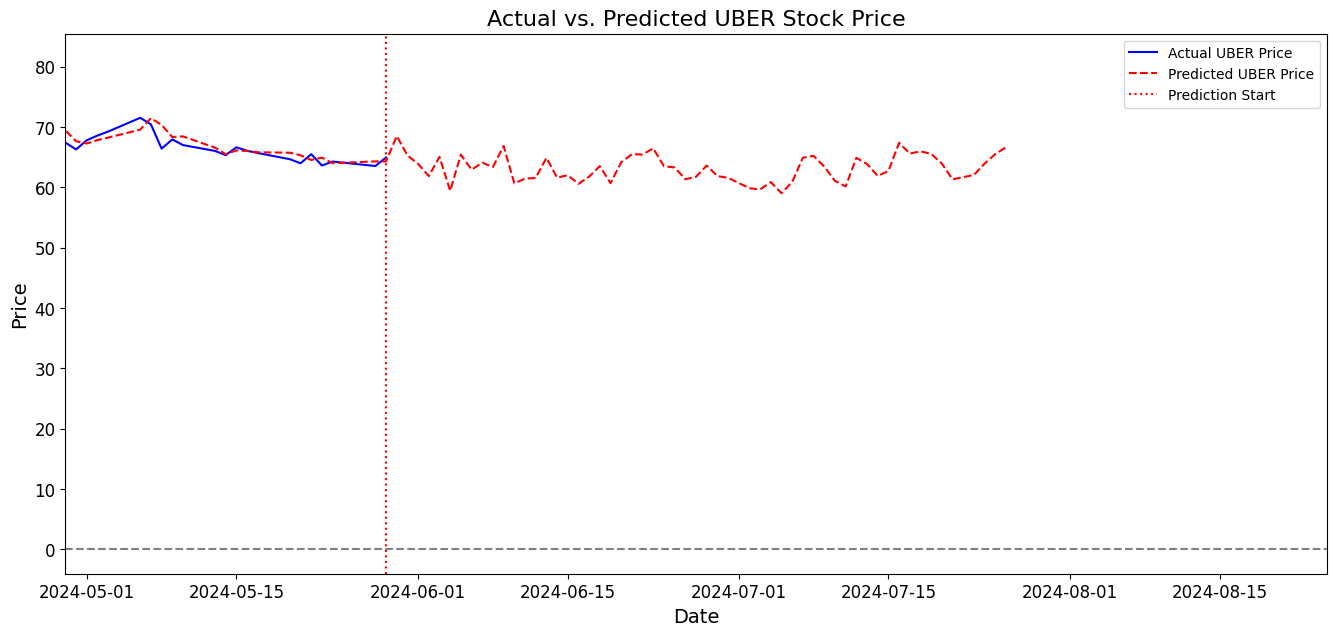

The actual UBER stock price on the last day of the data (2024-05-29) is: 64.93
The predicted UBER stock price for 2024-07-19 is: 65.54
The predicted UBER stock price for 2024-07-26 is: 66.63


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Load x and y
X = UBER_df[selected_features]
y = UBER_df['Adj Close']

# Ensure the 'Date' column is in datetime format
UBER_df['Date'] = pd.to_datetime(UBER_df['Date'])

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
UBER_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, UBER_df['Predicted'])
mae = mean_absolute_error(y, UBER_df['Predicted'])
mse = mean_squared_error(y, UBER_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = UBER_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = UBER_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([UBER_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([UBER_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([UBER_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = UBER_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([UBER_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual UBER Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted UBER Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted UBER Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = UBER_df.iloc[-1]['Adj Close']
print(f"The actual UBER stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted UBER stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted UBER stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


#### Model 2 application of CMG

Model evaluation results (sorted by MSE):
                     MSE
Linear Regression   0.40
Gradient Boosting  28.76
Random Forest      28.99
Decision Tree      31.10
XGBoost            31.66
SVR               117.48
KNN (Euclidean)      NaN
KNN (Manhattan)      NaN
KNN (Minkowski)      NaN


<Figure size 1400x1400 with 0 Axes>

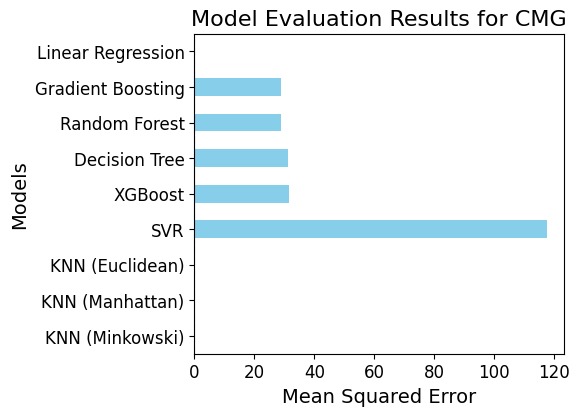

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Filter the dataset for CMG
CMG_df = df[df['Symbol'] == 'CMG'].copy()

# Drop rows with any NaN values
CMG_df = CMG_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = CMG_df[selected_features]
y = CMG_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results with the desired layout
plt.figure(figsize=(14, 14))  # Increased figure height for more space
ax = results_df.plot(kind='barh', legend=False, color='skyblue')
ax.set_xlabel("Mean Squared Error", fontsize=14)
ax.set_ylabel("Models", fontsize=14)
ax.set_title("Model Evaluation Results for CMG", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest MSE at the top
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)  # Adjust padding for more space
plt.show()


Feature evaluation results (sorted by R-squared):
                  R-squared
lag1                   1.00
MA_5                   0.99
EMA_12                 0.99
MA_10                  0.99
lag5                   0.98
MA_20                  0.97
Bollinger_High         0.97
lag10                  0.96
Bollinger_Low          0.95
OBV                    0.94
lag20                  0.91
EMA_26                 0.89
RSI*Adj_Close          0.78
VPT                    0.76
Adj Close/Volume       0.56
Volume_MA_10           0.27
MACD*EMA_12            0.26
Volume_MA_5            0.23
RSI                    0.20
MACD                   0.14
Stoch_Osc*ADX          0.04
Adj Close*Volume       0.03
Mstd_20                0.03
CCI                    0.03
EMA_12*Volume          0.03
RSI*Volume             0.02
ADX                    0.01
Mstd_10                0.01
Stoch_Osc              0.01
Mstd_5                 0.00
is_quarter_end         0.00
Quarter                0.00
Month                  0.0

<Figure size 1400x1400 with 0 Axes>

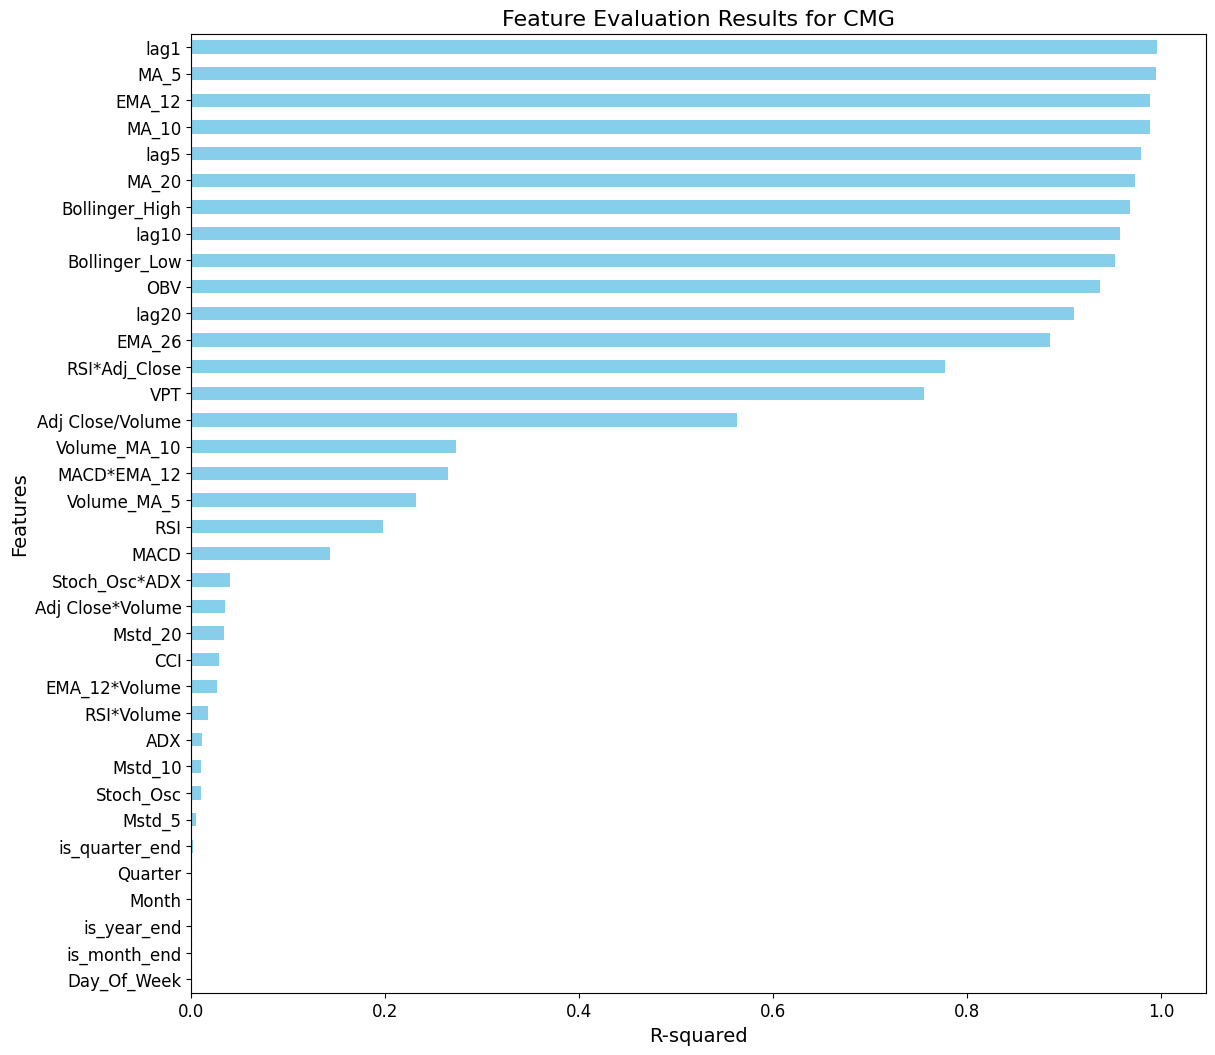

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# List of all features
features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

# Initialize a dictionary to hold R-squared values
r2_scores = {}

# Evaluate each feature individually
for feature in features:
    X = CMG_df[[feature]]
    y = CMG_df['Adj Close']
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores[feature] = r2

# Convert the R-squared scores to a DataFrame and sort by R-squared
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])
r2_df = r2_df.sort_values(by='R-squared', ascending=False)

print("Feature evaluation results (sorted by R-squared):")
print(r2_df)

# Plot the R-squared values with the desired layout
plt.figure(figsize=(14, 14))  # Increased figure height for more space
ax = r2_df.plot(kind='barh', legend=False, color='skyblue')
ax.set_xlabel("R-squared", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_title("Feature Evaluation Results for CMG", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest R-squared at the top
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout(pad=-20.0)  # Adjust padding for more space
plt.show()


Model Performance Statistics:
R-squared: 0.9965
Mean Absolute Error (MAE): 0.4251
Mean Squared Error (MSE): 0.3503
Root Mean Squared Error (RMSE): 0.5918
Cross-Validation R-squared: 0.9810 ± 0.0134


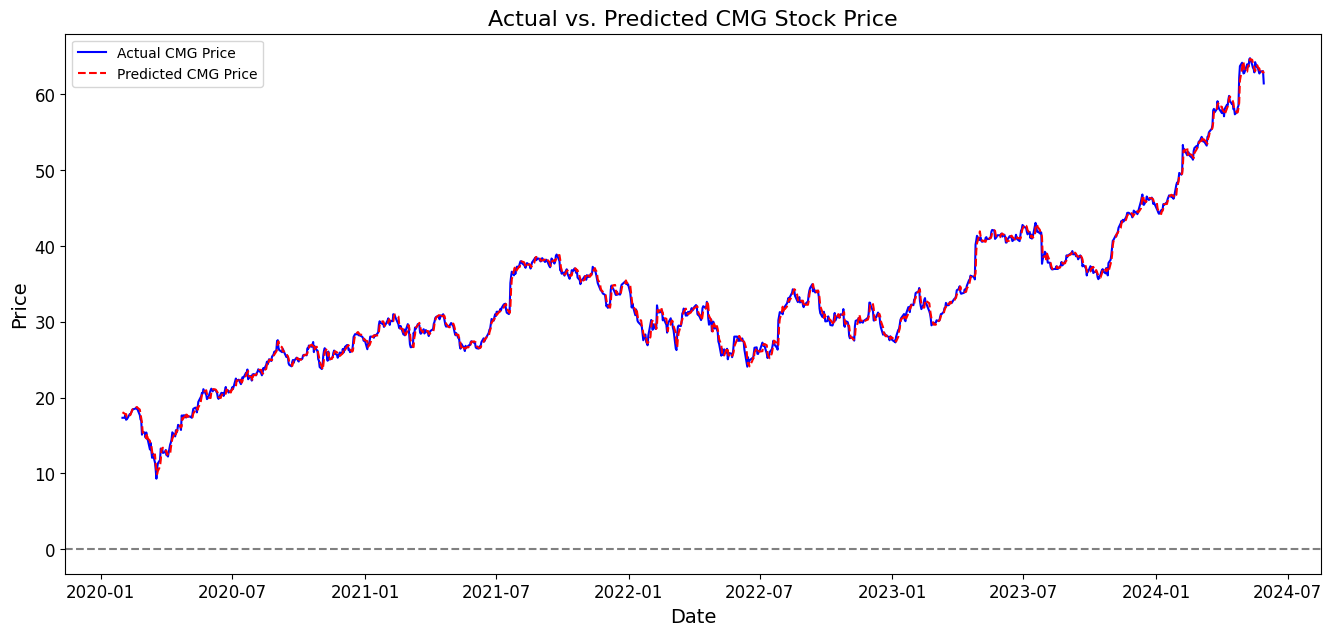

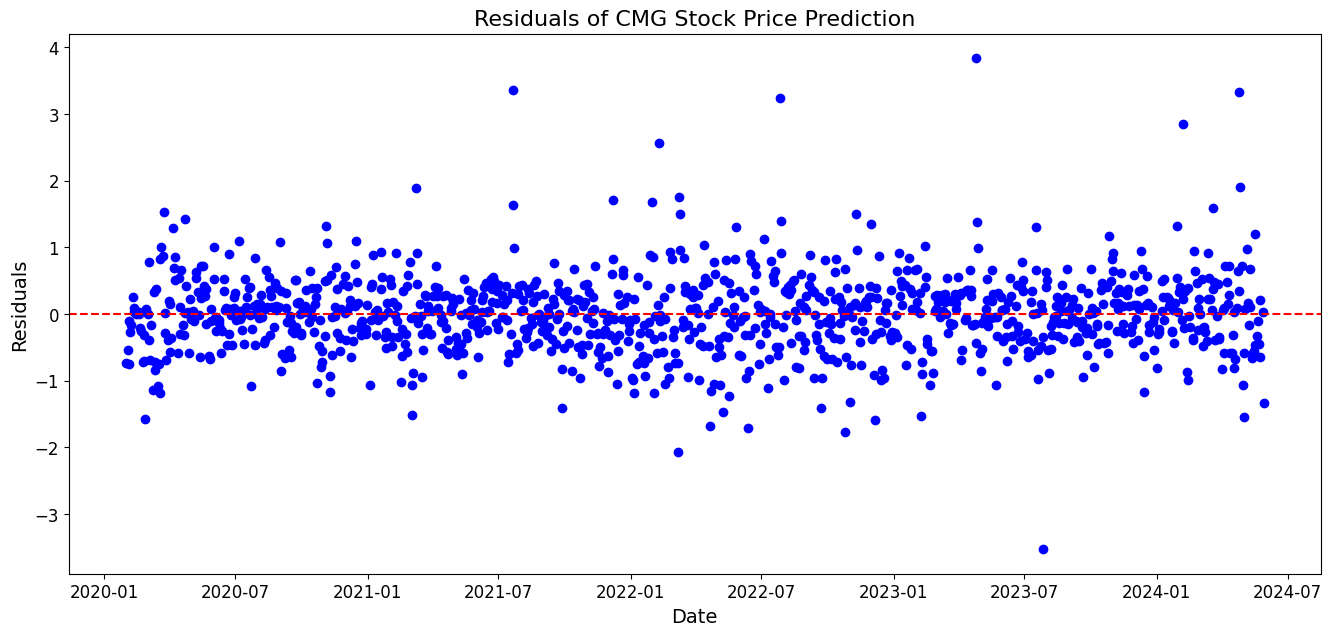

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = CMG_df[selected_features]
y = CMG_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CMG_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CMG_df['Predicted'])
mae = mean_absolute_error(y, CMG_df['Predicted'])
mse = mean_squared_error(y, CMG_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(CMG_df['Date'], CMG_df['Adj Close'], label='Actual CMG Price', color='blue')
plt.plot(CMG_df['Date'], CMG_df['Predicted'], label='Predicted CMG Price', linestyle='--', color='red')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CMG Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
CMG_df['Residuals'] = y - CMG_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(CMG_df['Date'], CMG_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of CMG Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9965
Mean Absolute Error (MAE): 0.4251
Mean Squared Error (MSE): 0.3503
Root Mean Squared Error (RMSE): 0.5918
Cross-Validation R-squared: 0.9810 ± 0.0134


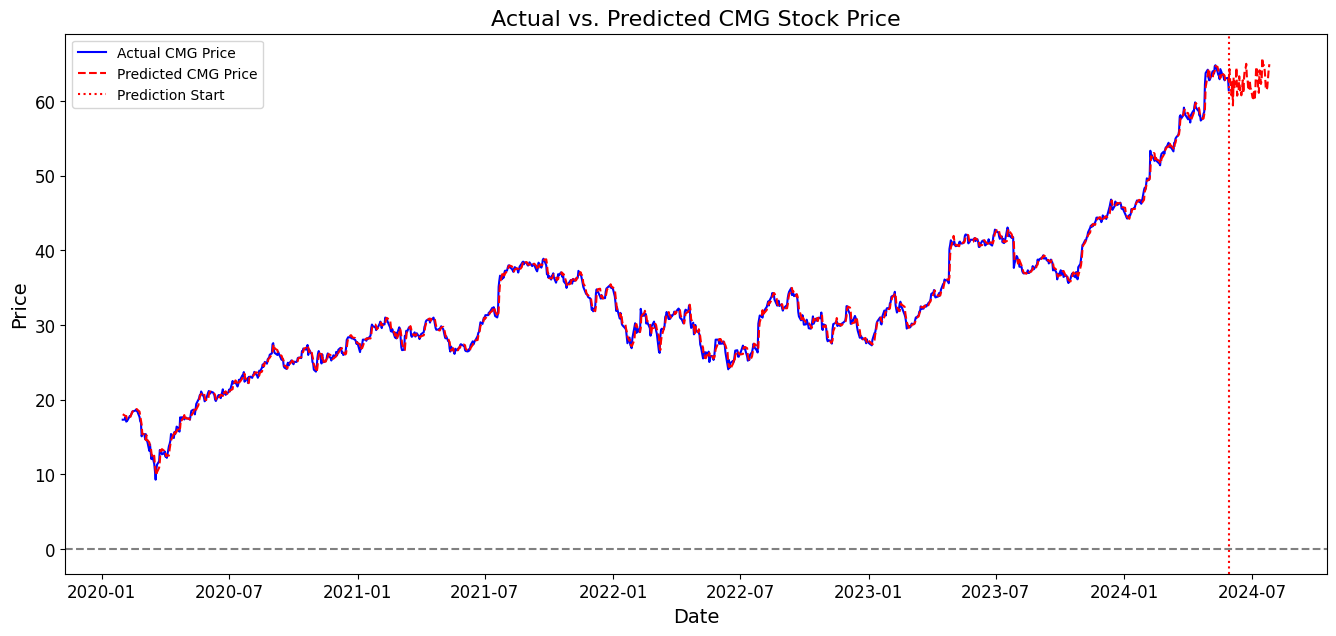

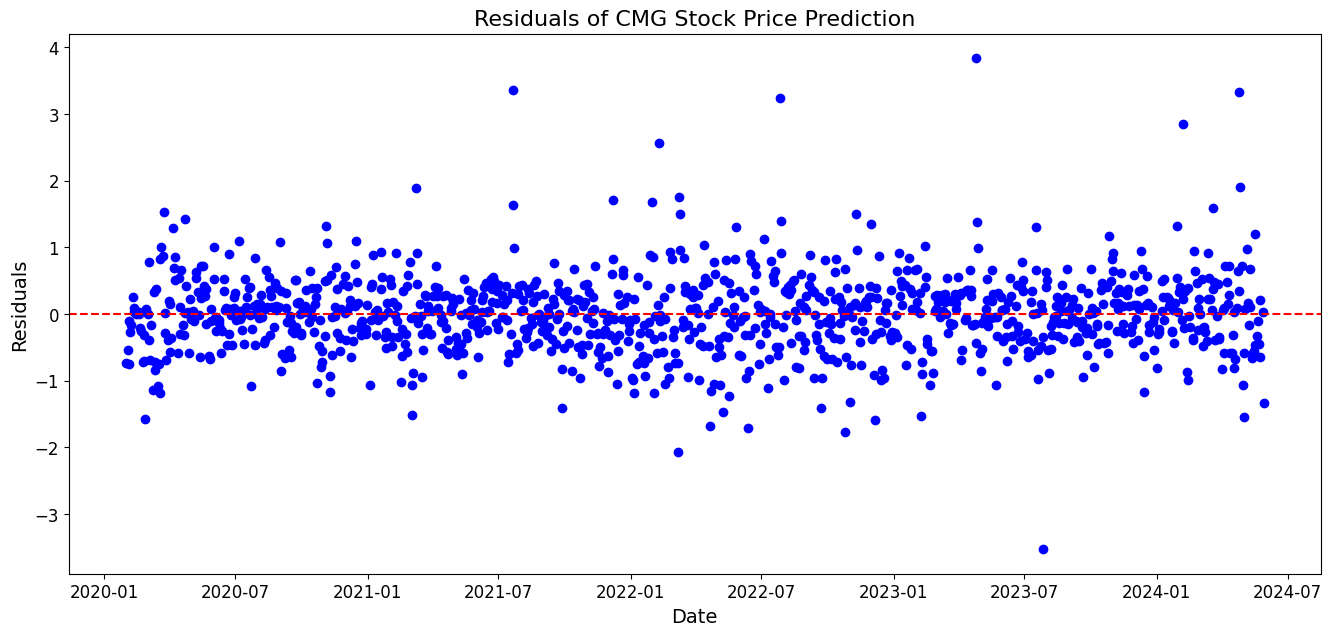

The predicted CMG stock price for 2024-07-19 is: 64.48
The predicted CMG stock price for 2024-07-26 is: 64.92


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Load x and y
X = CMG_df[selected_features]
y = CMG_df['Adj Close']

# Ensure the 'Date' column is in datetime format
CMG_df['Date'] = pd.to_datetime(CMG_df['Date'])

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CMG_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CMG_df['Predicted'])
mae = mean_absolute_error(y, CMG_df['Predicted'])
mse = mean_squared_error(y, CMG_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = CMG_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = CMG_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([CMG_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([CMG_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([CMG_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = CMG_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([CMG_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual CMG Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted CMG Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CMG Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
CMG_df['Residuals'] = y - CMG_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(CMG_df['Date'], CMG_df['Residuals'], color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of CMG Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted CMG stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted CMG stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


Model Performance Statistics:
R-squared: 0.9965
Mean Absolute Error (MAE): 0.4251
Mean Squared Error (MSE): 0.3503
Root Mean Squared Error (RMSE): 0.5918
Cross-Validation R-squared: 0.9810 ± 0.0134


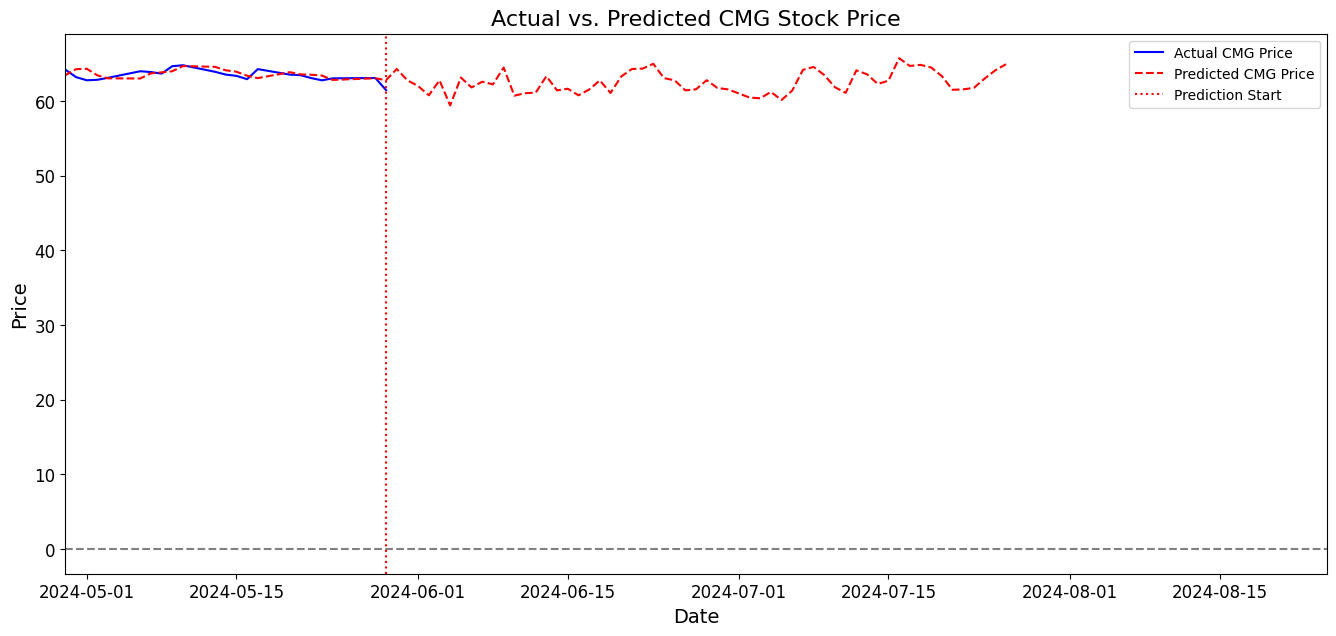

The actual CMG stock price on the last day of the data (2024-05-29) is: 61.46
The predicted CMG stock price for 2024-07-19 is: 64.48
The predicted CMG stock price for 2024-07-26 is: 64.92


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from datetime import timedelta

# Load x and y
X = CMG_df[selected_features]
y = CMG_df['Adj Close']

# Ensure the 'Date' column is in datetime format
CMG_df['Date'] = pd.to_datetime(CMG_df['Date'])

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CMG_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CMG_df['Predicted'])
mae = mean_absolute_error(y, CMG_df['Predicted'])
mse = mean_squared_error(y, CMG_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = CMG_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = CMG_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([CMG_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([CMG_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([CMG_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = CMG_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([CMG_df.set_index('Date'), future_predictions])

# Zoom in on the graph to see the movement happening in the forecasted variables
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual CMG Price', color='blue')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted CMG Price', linestyle='--', color='red')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CMG Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = CMG_df.iloc[-1]['Adj Close']
print(f"The actual CMG stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted CMG stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted CMG stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


#### Model 2 Application of CRM

Model evaluation results (sorted by MSE):
                      MSE
Linear Regression    7.71
Gradient Boosting   67.57
XGBoost             73.29
Random Forest       88.57
Decision Tree      172.16
SVR               2384.88
KNN (Euclidean)       NaN
KNN (Manhattan)       NaN
KNN (Minkowski)       NaN


<Figure size 1400x700 with 0 Axes>

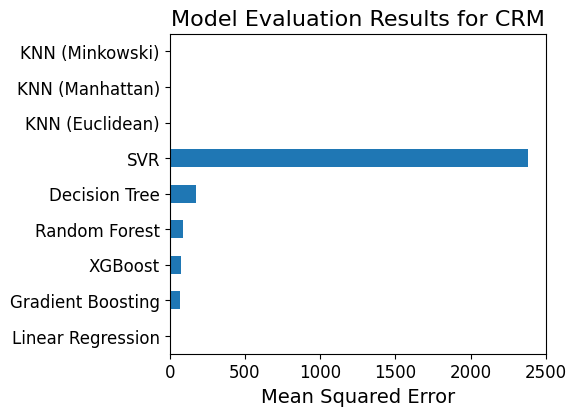

In [131]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Drop rows with any NaN values
CRM_df = CRM_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = CRM_df[selected_features]
y = CRM_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results
plt.figure(figsize=(14, 7))
results_df.plot(kind='barh', legend=False)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.title("Model Evaluation Results for CRM", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Feature evaluation results (sorted by R-squared):
                  R-squared
lag1                   0.99
MA_5                   0.99
EMA_12                 0.97
MA_10                  0.97
lag5                   0.94
EMA_26                 0.93
MA_20                  0.93
Bollinger_Low          0.90
lag10                  0.88
Bollinger_High         0.86
lag20                  0.78
VPT                    0.74
RSI*Adj_Close          0.68
OBV                    0.55
Adj Close/Volume       0.36
MACD                   0.11
MACD*EMA_12            0.11
Adj Close*Volume       0.11
EMA_12*Volume          0.09
RSI                    0.08
Volume_MA_10           0.06
Volume_MA_5            0.04
Stoch_Osc              0.03
Stoch_Osc*ADX          0.03
Quarter                0.02
Month                  0.02
Mstd_5                 0.02
Mstd_10                0.02
CCI                    0.02
Mstd_20                0.01
is_year_end            0.00
RSI*Volume             0.00
ADX                    0.0

<Figure size 1400x700 with 0 Axes>

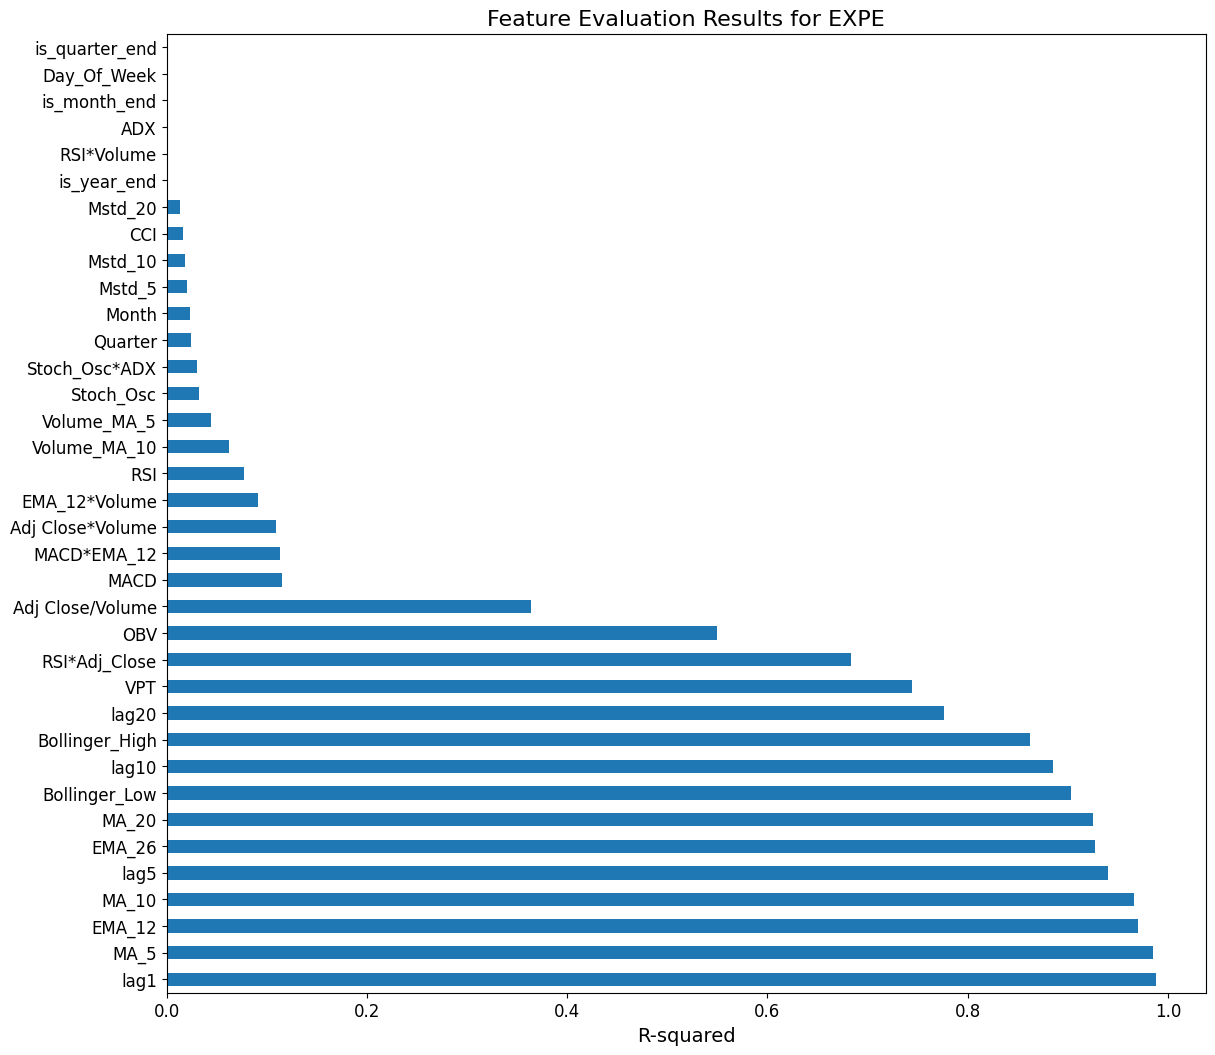

In [132]:
# List of all features
features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

# Remove rows with any NaN values
EXPE_df = EXPE_df.dropna()

# Initialize a dictionary to hold R-squared values
r2_scores = {}

# Evaluate each feature individually
for feature in features:
    X = EXPE_df[[feature]]
    y = EXPE_df['Adj Close']
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores[feature] = r2

# Convert the R-squared scores to a DataFrame and sort by R-squared
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])
r2_df = r2_df.sort_values(by='R-squared', ascending=False)

# Print the R-squared values in a more readable format
pd.options.display.float_format = '{:.2f}'.format
print("Feature evaluation results (sorted by R-squared):")
print(r2_df)

# Plot the R-squared values
plt.figure(figsize=(14, 7))
r2_df.plot(kind='barh', legend=False)
plt.xlabel("R-squared", fontsize=14)
plt.title("Feature Evaluation Results for EXPE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=-20.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9891
Mean Absolute Error (MAE): 3.2830
Mean Squared Error (MSE): 21.4472
Root Mean Squared Error (RMSE): 4.6311
Cross-Validation R-squared: 0.9808 ± 0.0054


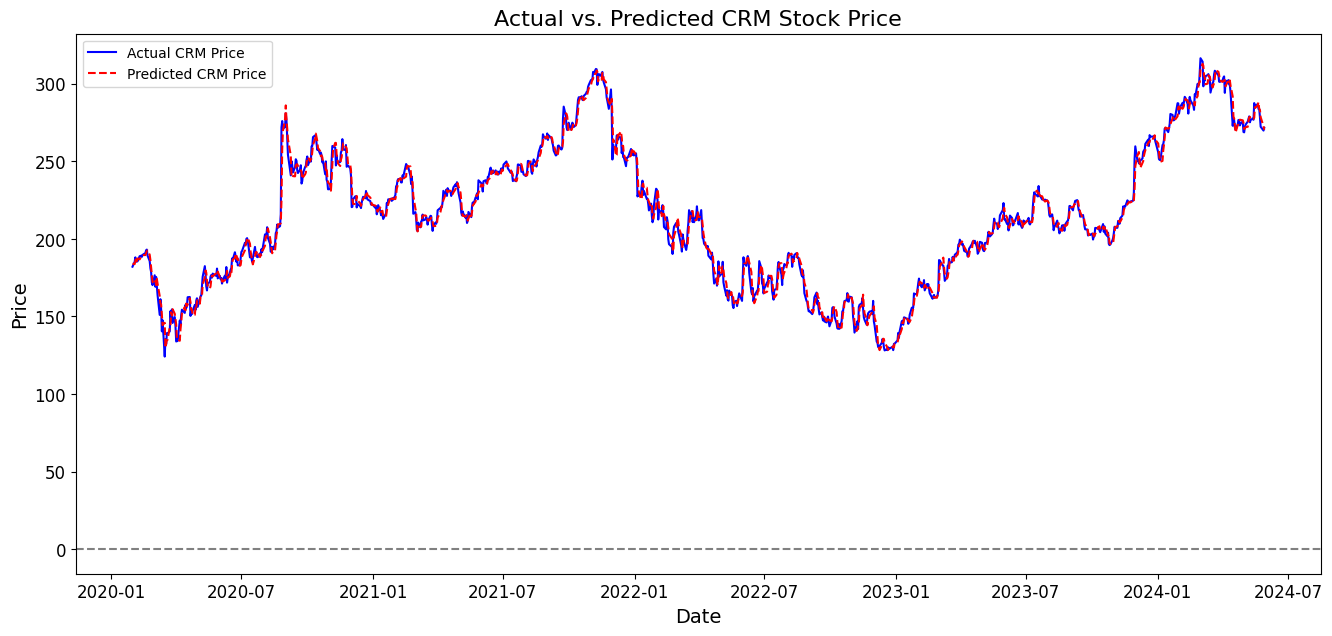

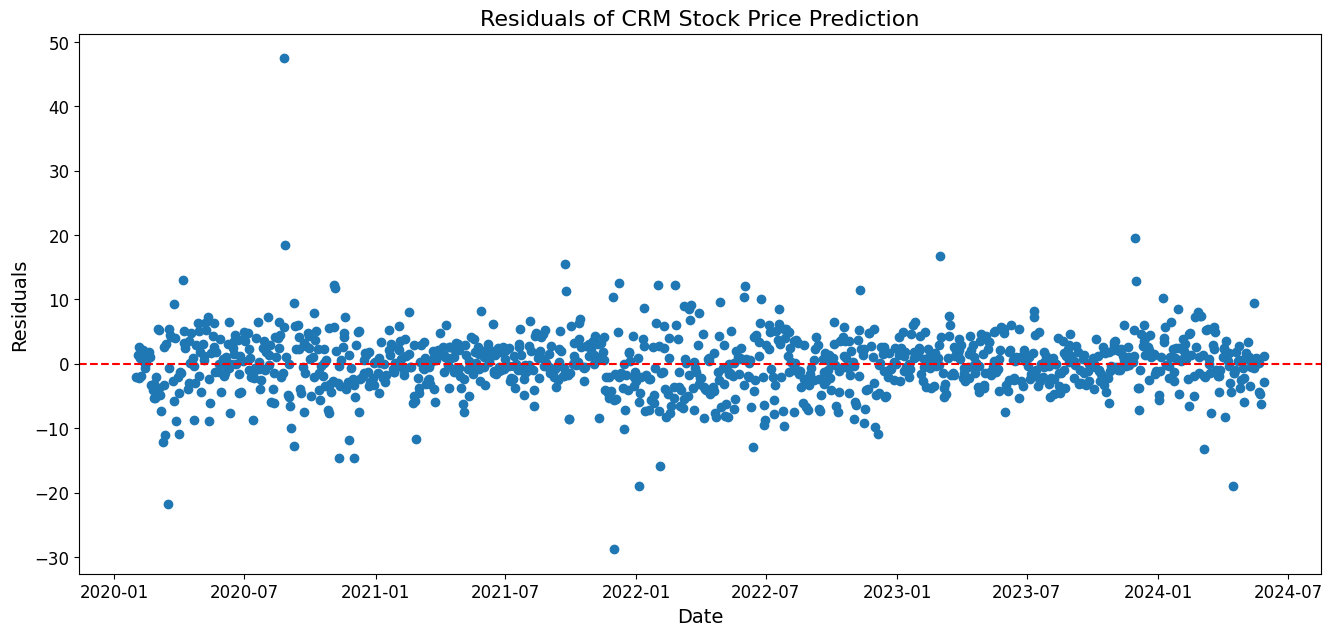

In [133]:
# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = CRM_df[selected_features]
y = CRM_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CRM_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CRM_df['Predicted'])
mae = mean_absolute_error(y, CRM_df['Predicted'])
mse = mean_squared_error(y, CRM_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(CRM_df['Date'], CRM_df['Adj Close'], label='Actual CRM Price', color='blue')
plt.plot(CRM_df['Date'], CRM_df['Predicted'], label='Predicted CRM Price', linestyle='--', color='red')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CRM Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--')
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
CRM_df['Residuals'] = y - CRM_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(CRM_df['Date'], CRM_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of CRM Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9891
Mean Absolute Error (MAE): 3.2830
Mean Squared Error (MSE): 21.4472
Root Mean Squared Error (RMSE): 4.6311
Cross-Validation R-squared: 0.9808 ± 0.0054


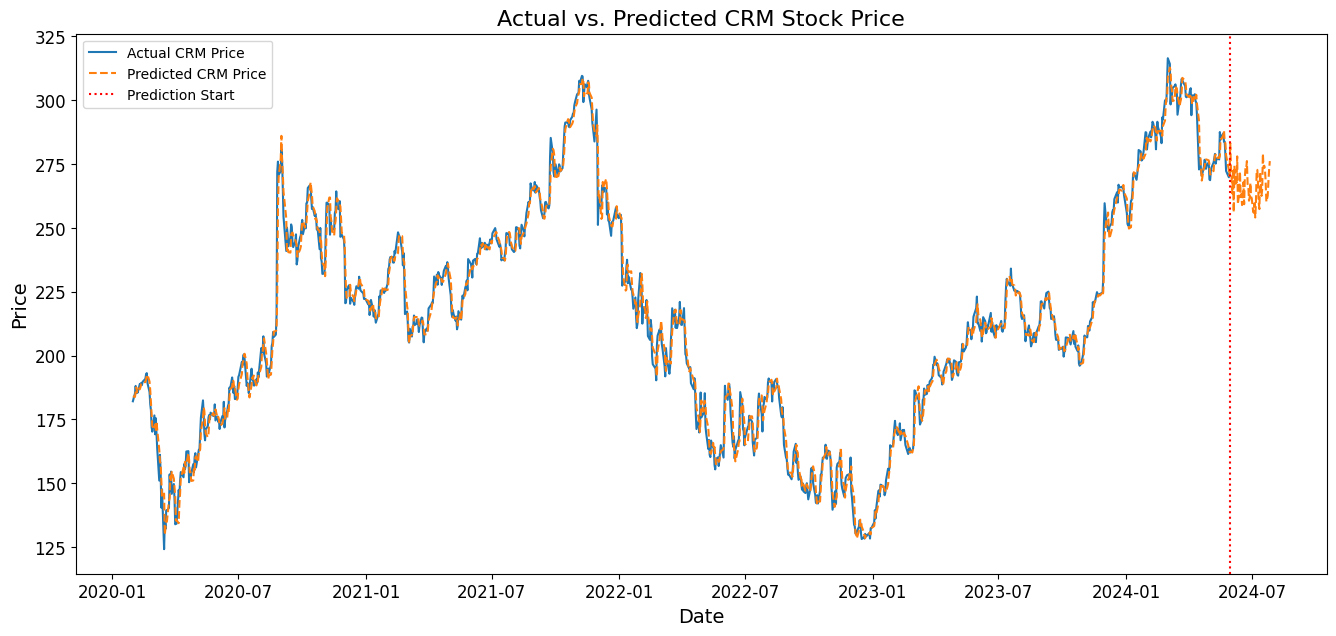

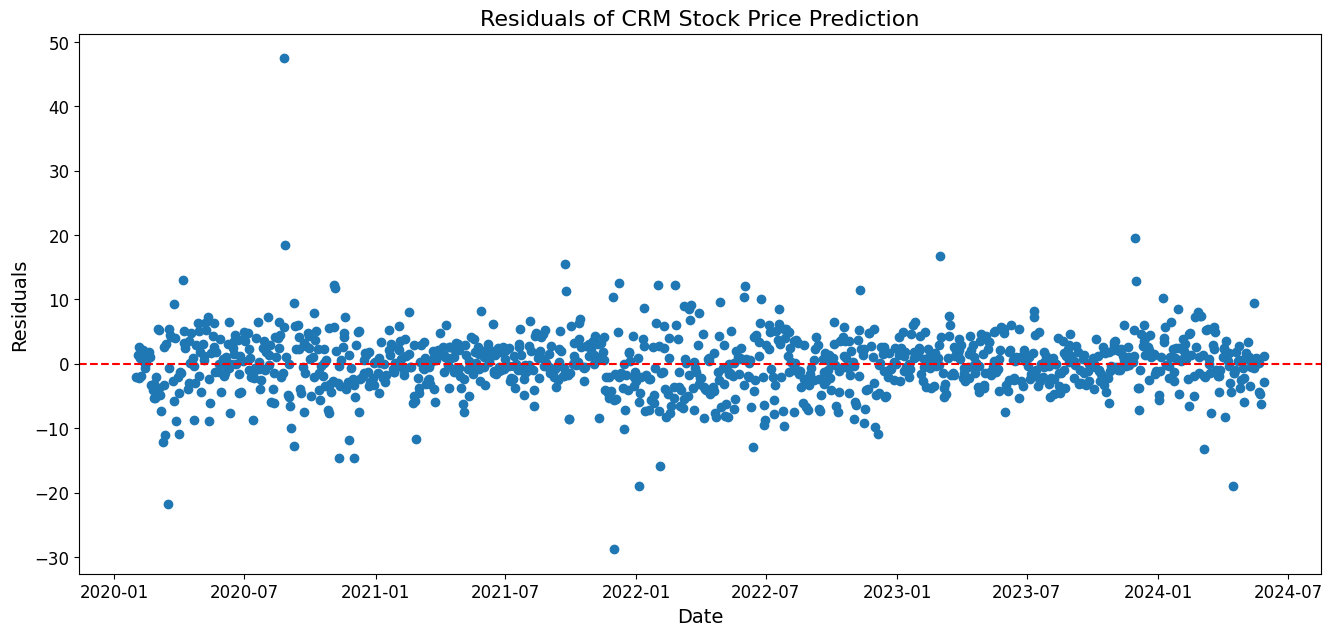

The predicted CRM stock price for 2024-07-19 is: 272.99
The predicted CRM stock price for 2024-07-26 is: 276.16


In [134]:
X = CRM_df[selected_features]
y = CRM_df['Adj Close']

# Ensure the 'Date' column is in datetime format
CRM_df['Date'] = pd.to_datetime(CRM_df['Date'])

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CRM_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CRM_df['Predicted'])
mae = mean_absolute_error(y, CRM_df['Predicted'])
mse = mean_squared_error(y, CRM_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = CRM_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = CRM_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([CRM_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([CRM_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([CRM_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = CRM_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([CRM_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual CRM Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted CRM Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CRM Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
CRM_df['Residuals'] = y - CRM_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(CRM_df['Date'], CRM_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of CRM Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted CRM stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted CRM stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")



Model Performance Statistics:
R-squared: 0.9891
Mean Absolute Error (MAE): 3.2830
Mean Squared Error (MSE): 21.4472
Root Mean Squared Error (RMSE): 4.6311
Cross-Validation R-squared: 0.9808 ± 0.0054


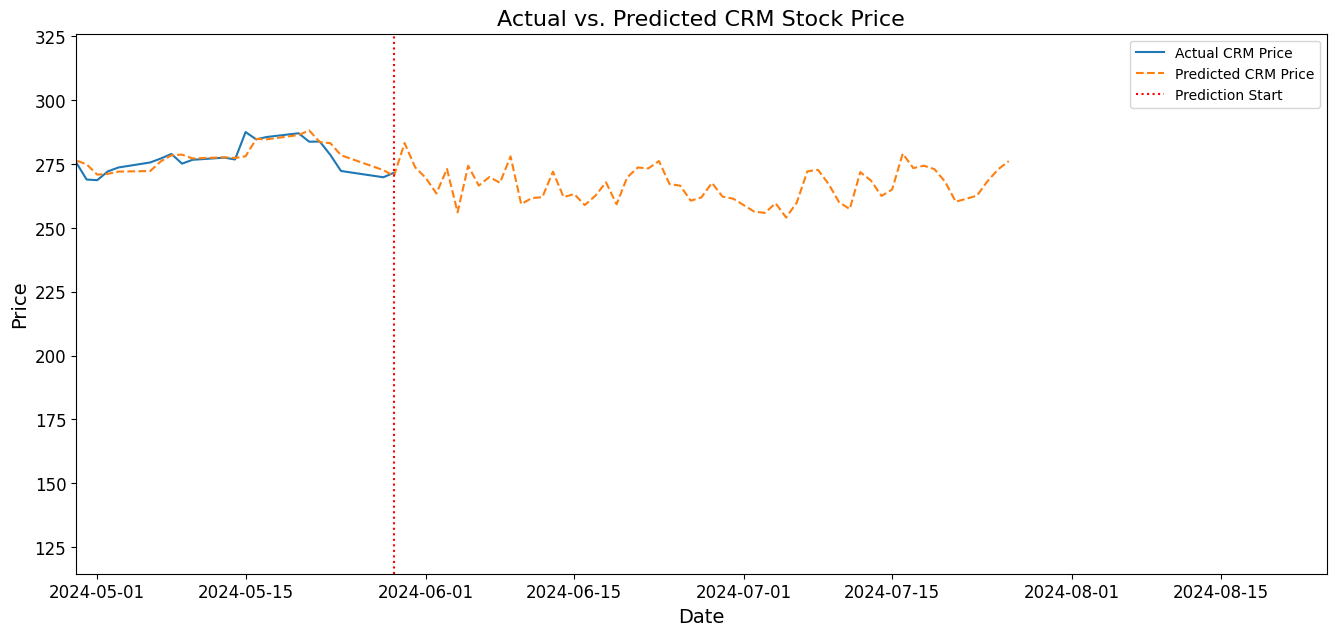

The actual CRM stock price on the last day of the data (2024-05-29) is: 271.62
The predicted CRM stock price for 2024-07-19 is: 272.99
The predicted CRM stock price for 2024-07-26 is: 276.16


In [135]:
X = CRM_df[selected_features]
y = CRM_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
CRM_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, CRM_df['Predicted'])
mae = mean_absolute_error(y, CRM_df['Predicted'])
mse = mean_squared_error(y, CRM_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = CRM_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = CRM_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([CRM_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([CRM_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([CRM_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = CRM_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([CRM_df.set_index('Date'), future_predictions])

# Zoom in on the graph to see the movement happening in the forecasted variables
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual CRM Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted CRM Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted CRM Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = CRM_df.iloc[-1]['Adj Close']
print(f"The actual CRM stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted CRM stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted CRM stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


#### Model 2 application of EL

Model evaluation results (sorted by MSE):
                      MSE
Linear Regression    4.36
Random Forest      122.69
Gradient Boosting  184.15
Decision Tree      193.64
XGBoost            210.10
SVR               5836.89
KNN (Euclidean)       NaN
KNN (Manhattan)       NaN
KNN (Minkowski)       NaN


<Figure size 1000x600 with 0 Axes>

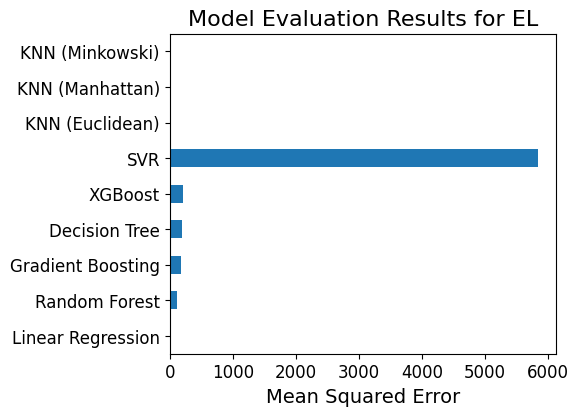

In [136]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Filter the dataset for EL
EL_df = df[df['Symbol'] == 'EL'].copy()

# Drop rows with any NaN values
EL_df = EL_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = EL_df[selected_features]
y = EL_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
results_df.plot(kind='barh', legend=False)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.title("Model Evaluation Results for EL", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Feature evaluation results (sorted by R-squared):
                  R-squared
lag1                   0.99
MA_5                   0.99
EMA_12                 0.98
MA_10                  0.98
lag5                   0.97
EMA_26                 0.97
MA_20                  0.96
Bollinger_Low          0.96
lag10                  0.94
Bollinger_High         0.94
lag20                  0.89
OBV                    0.72
RSI*Adj_Close          0.68
VPT                    0.61
Adj Close/Volume       0.56
Volume_MA_10           0.44
Volume_MA_5            0.35
RSI*Volume             0.14
RSI                    0.09
MACD                   0.07
MACD*EMA_12            0.06
CCI                    0.05
Mstd_20                0.03
Mstd_10                0.03
Mstd_5                 0.02
ADX                    0.01
Stoch_Osc              0.01
Stoch_Osc*ADX          0.01
is_year_end            0.00
is_quarter_end         0.00
EMA_12*Volume          0.00
Month                  0.00
Quarter                0.0

<Figure size 1000x600 with 0 Axes>

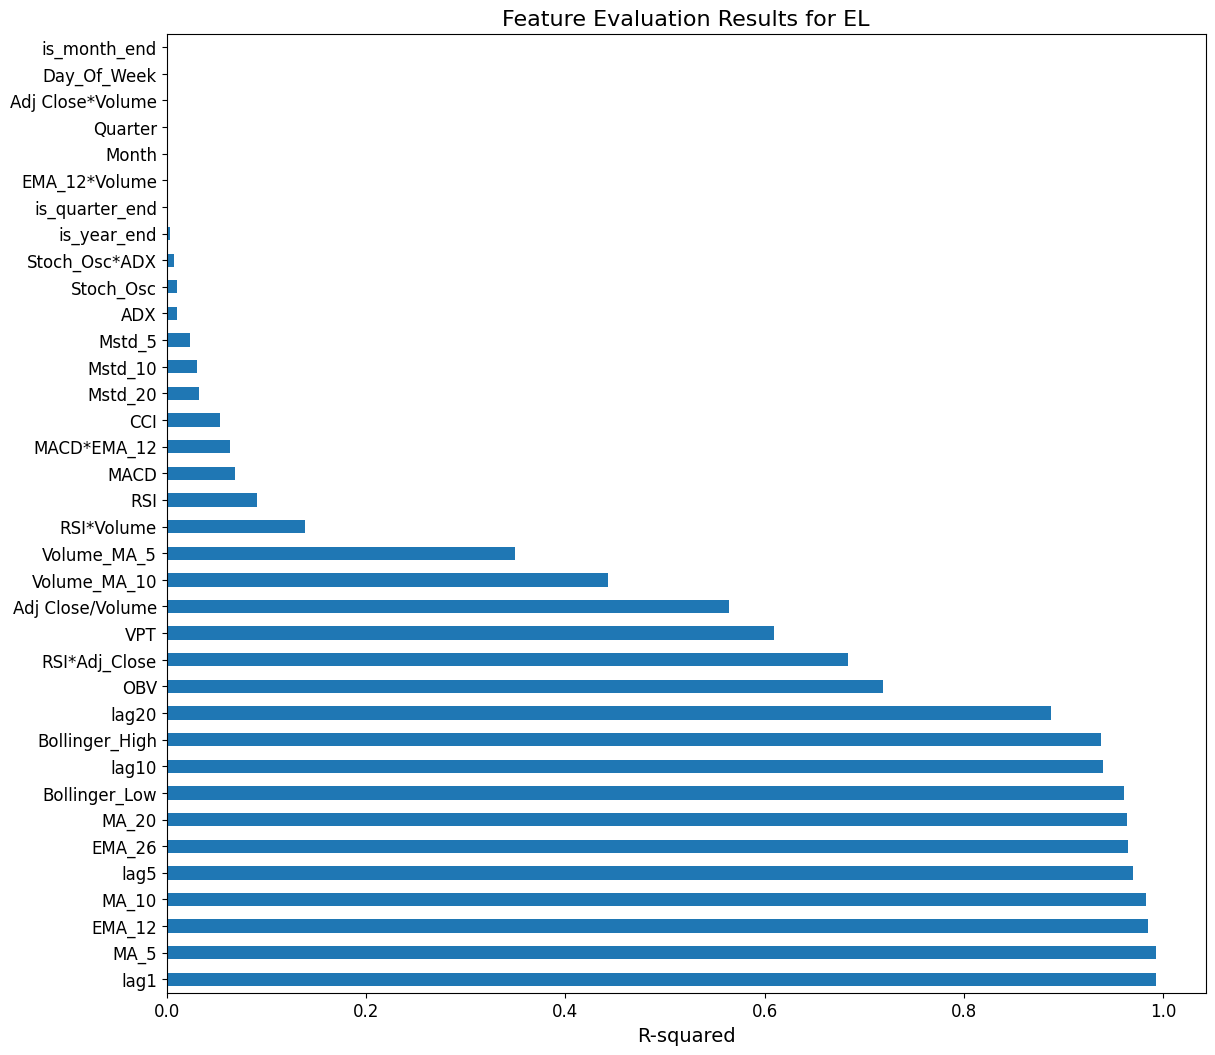

In [137]:
# List of all features
features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

# Initialize a dictionary to hold R-squared values
r2_scores = {}

# Evaluate each feature individually
for feature in features:
    X = EL_df[[feature]]
    y = EL_df['Adj Close']
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores[feature] = r2

# Convert the R-squared scores to a DataFrame and sort by R-squared
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])
r2_df = r2_df.sort_values(by='R-squared', ascending=False)

# Print the R-squared values in a more readable format
pd.options.display.float_format = '{:.2f}'.format
print("Feature evaluation results (sorted by R-squared):")
print(r2_df)

# Plot the R-squared values
plt.figure(figsize=(10, 6))
r2_df.plot(kind='barh', legend=False)
plt.xlabel("R-squared", fontsize=14)
plt.title("Feature Evaluation Results for EL", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=-20.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9946
Mean Absolute Error (MAE): 3.2796
Mean Squared Error (MSE): 20.3059
Root Mean Squared Error (RMSE): 4.5062
Cross-Validation R-squared: 0.9656 ± 0.0130


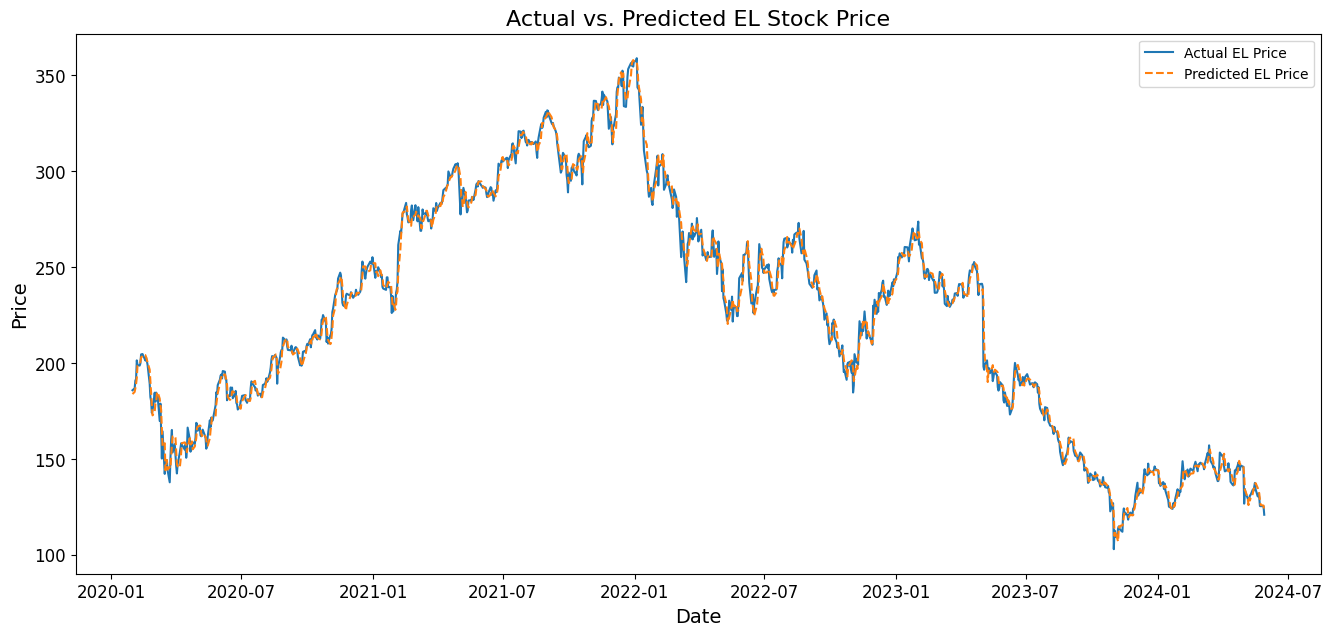

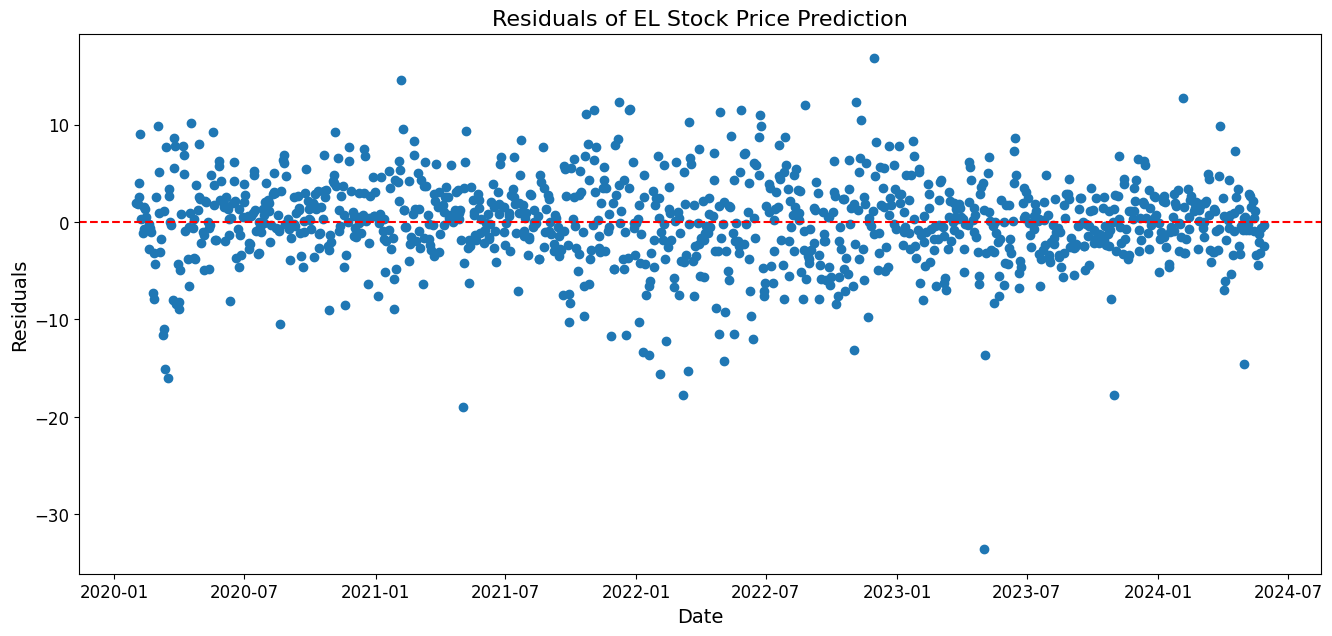

In [138]:
# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = EL_df[selected_features]
y = EL_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EL_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EL_df['Predicted'])
mae = mean_absolute_error(y, EL_df['Predicted'])
mse = mean_squared_error(y, EL_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(EL_df['Date'], EL_df['Adj Close'], label='Actual EL Price')
plt.plot(EL_df['Date'], EL_df['Predicted'], label='Predicted EL Price', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EL Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
EL_df['Residuals'] = y - EL_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(EL_df['Date'], EL_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of EL Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9946
Mean Absolute Error (MAE): 3.2796
Mean Squared Error (MSE): 20.3059
Root Mean Squared Error (RMSE): 4.5062
Cross-Validation R-squared: 0.9656 ± 0.0130


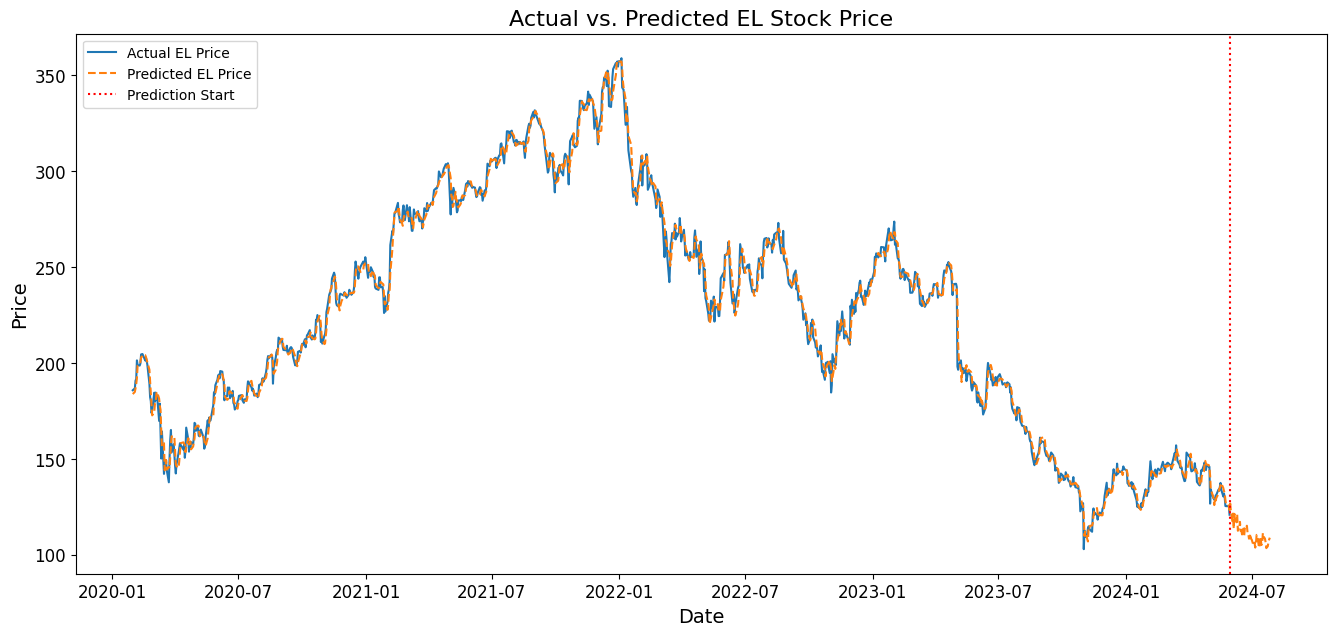

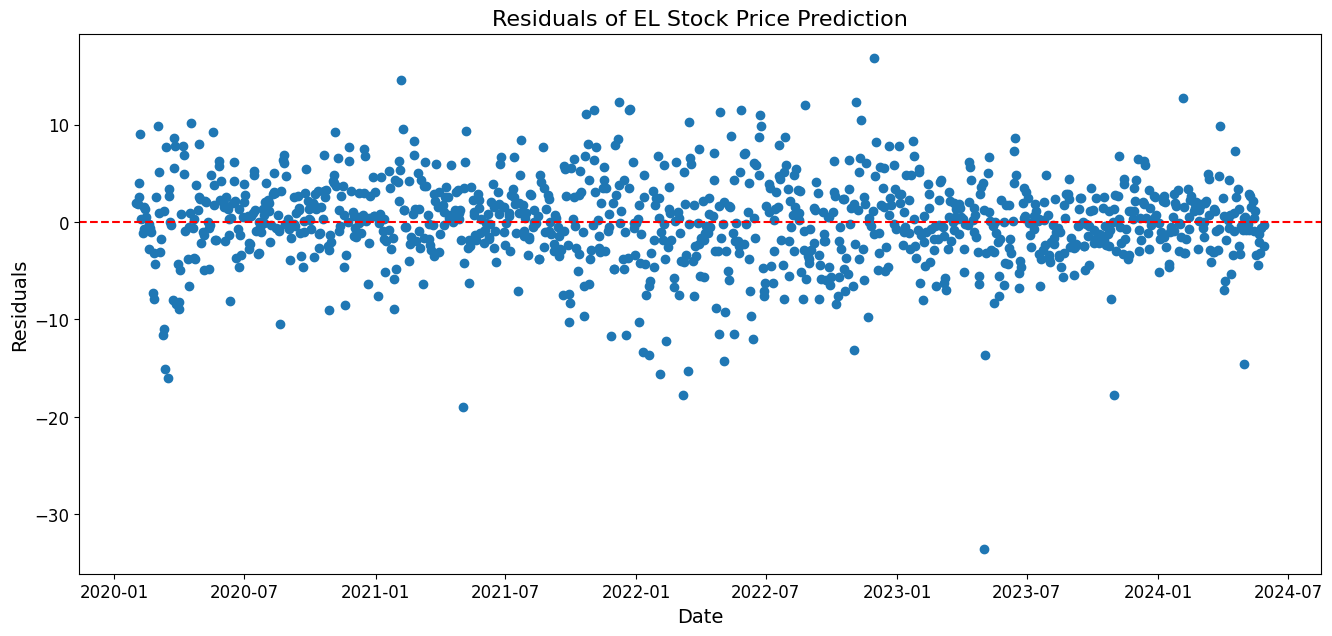

The predicted EL stock price for 2024-07-19 is: 108.40
The predicted EL stock price for 2024-07-26 is: 108.93


In [139]:
X = EL_df[selected_features]
y = EL_df['Adj Close']

# Ensure the 'Date' column is in datetime format
EL_df['Date'] = pd.to_datetime(EL_df['Date'])

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EL_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EL_df['Predicted'])
mae = mean_absolute_error(y, EL_df['Predicted'])
mse = mean_squared_error(y, EL_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = EL_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = EL_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([EL_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([EL_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([EL_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = EL_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([EL_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual EL Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted EL Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EL Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
EL_df['Residuals'] = y - EL_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(EL_df['Date'], EL_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of EL Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted EL stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted EL stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


Model Performance Statistics:
R-squared: 0.9946
Mean Absolute Error (MAE): 3.2796
Mean Squared Error (MSE): 20.3059
Root Mean Squared Error (RMSE): 4.5062
Cross-Validation R-squared: 0.9656 ± 0.0130


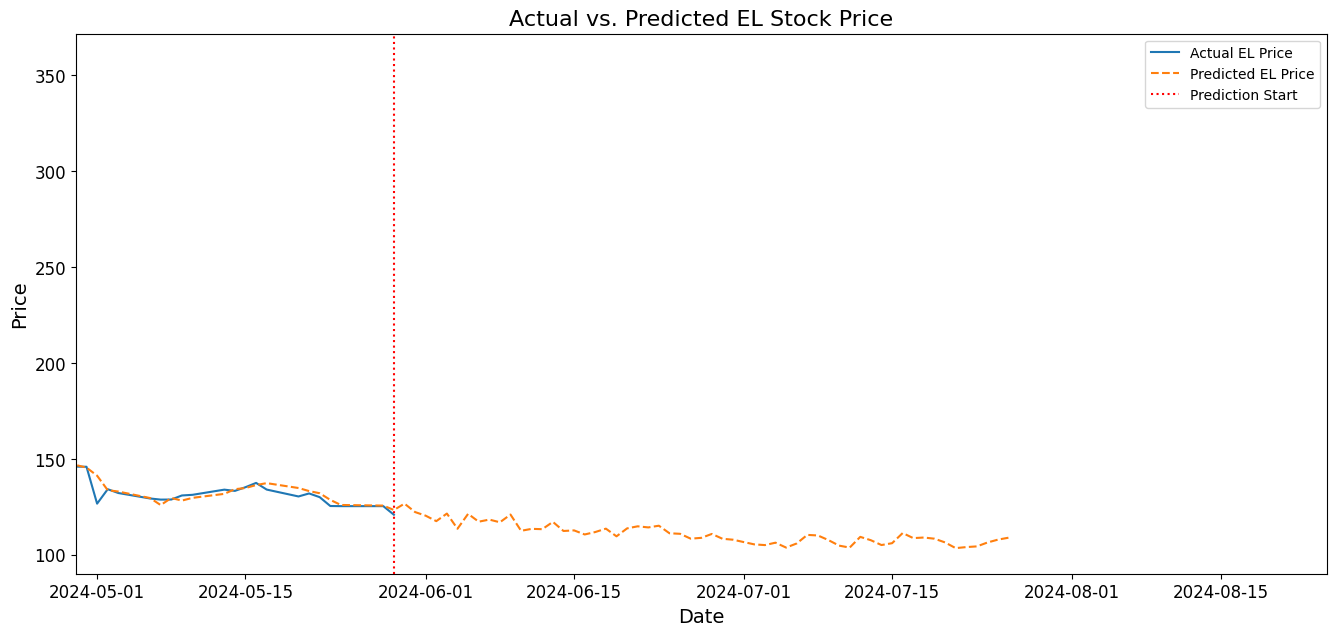

The actual EL stock price on the last day of the data (2024-05-29) is: 120.89
The predicted EL stock price for 2024-07-19 is: 108.40
The predicted EL stock price for 2024-07-26 is: 108.93


In [140]:
X = EL_df[selected_features]
y = EL_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EL_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EL_df['Predicted'])
mae = mean_absolute_error(y, EL_df['Predicted'])
mse = mean_squared_error(y, EL_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = EL_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = EL_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([EL_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([EL_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([EL_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = EL_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([EL_df.set_index('Date'), future_predictions])

# Zoom in on the graph to see the movement happening in the forecasted variables
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual EL Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted EL Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EL Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = EL_df.iloc[-1]['Adj Close']
print(f"The actual EL stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted EL stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted EL stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


#### Model 2 Application of EXPE

Model evaluation results (sorted by MSE):
                      MSE
Linear Regression    2.02
Gradient Boosting   73.82
Random Forest       78.46
Decision Tree       78.66
XGBoost            100.96
SVR               1972.83
KNN (Euclidean)       NaN
KNN (Manhattan)       NaN
KNN (Minkowski)       NaN


<Figure size 1000x600 with 0 Axes>

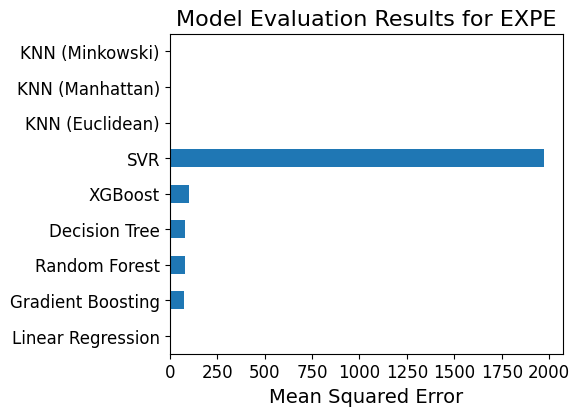

In [141]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Filter the dataset for EXPE
EXPE_df = df[df['Symbol'] == 'EXPE'].copy()

# Drop rows with any NaN values
EXPE_df = EXPE_df.dropna()

# Select the features and target variable
selected_features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

X = EXPE_df[selected_features]
y = EXPE_df['Adj Close']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    'KNN (Minkowski)': KNeighborsRegressor(n_neighbors=5, metric='minkowski')
}

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

# Plot the results
plt.figure(figsize=(10, 6))
results_df.plot(kind='barh', legend=False)
plt.xlabel("Mean Squared Error", fontsize=14)
plt.title("Model Evaluation Results for EXPE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Feature evaluation results (sorted by R-squared):
                  R-squared
lag1                   0.99
MA_5                   0.99
EMA_12                 0.97
MA_10                  0.97
lag5                   0.94
EMA_26                 0.93
MA_20                  0.93
Bollinger_Low          0.90
lag10                  0.88
Bollinger_High         0.86
lag20                  0.78
VPT                    0.74
RSI*Adj_Close          0.68
OBV                    0.55
Adj Close/Volume       0.36
MACD                   0.11
MACD*EMA_12            0.11
Adj Close*Volume       0.11
EMA_12*Volume          0.09
RSI                    0.08
Volume_MA_10           0.06
Volume_MA_5            0.04
Stoch_Osc              0.03
Stoch_Osc*ADX          0.03
Quarter                0.02
Month                  0.02
Mstd_5                 0.02
Mstd_10                0.02
CCI                    0.02
Mstd_20                0.01
is_year_end            0.00
RSI*Volume             0.00
ADX                    0.0

<Figure size 1000x600 with 0 Axes>

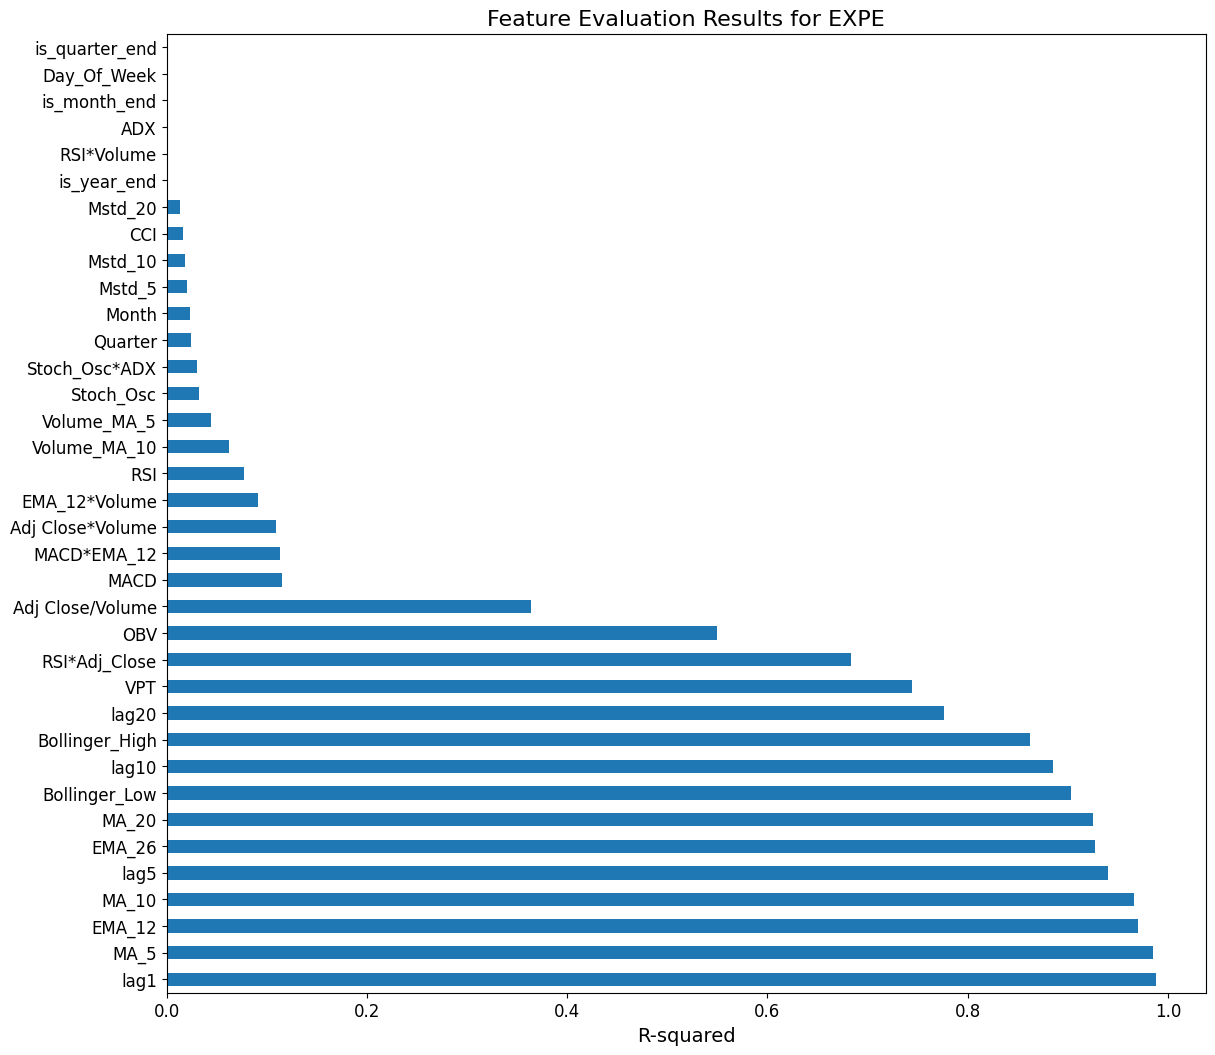

In [142]:
# List of all features
features = [
    'lag1', 'lag5', 'lag10', 'lag20', 
    'MA_5', 'MA_10', 'MA_20', 
    'Mstd_5', 'Mstd_10', 'Mstd_20', 
    'Volume_MA_5', 'Volume_MA_10', 
    'Day_Of_Week', 'Month', 'Quarter', 
    'RSI', 'Bollinger_High', 'Bollinger_Low', 
    'MACD', 'EMA_12', 'EMA_26', 
    'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 
    'Adj Close/Volume', 'Stoch_Osc', 'ADX', 
    'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 
    'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 
    'is_year_end', 'VPT', 'OBV'
]

# Initialize a dictionary to hold R-squared values
r2_scores = {}

# Evaluate each feature individually
for feature in features:
    X = EXPE_df[[feature]]
    y = EXPE_df['Adj Close']
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    r2_scores[feature] = r2

# Convert the R-squared scores to a DataFrame and sort by R-squared
r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R-squared'])
r2_df = r2_df.sort_values(by='R-squared', ascending=False)

# Print the R-squared values in a more readable format
pd.options.display.float_format = '{:.2f}'.format
print("Feature evaluation results (sorted by R-squared):")
print(r2_df)

# Plot the R-squared values
plt.figure(figsize=(10, 6))
r2_df.plot(kind='barh', legend=False)
plt.xlabel("R-squared", fontsize=14)
plt.title("Feature Evaluation Results for EXPE", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=-20.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9901
Mean Absolute Error (MAE): 2.4448
Mean Squared Error (MSE): 12.1789
Root Mean Squared Error (RMSE): 3.4898
Cross-Validation R-squared: 0.9612 ± 0.0182


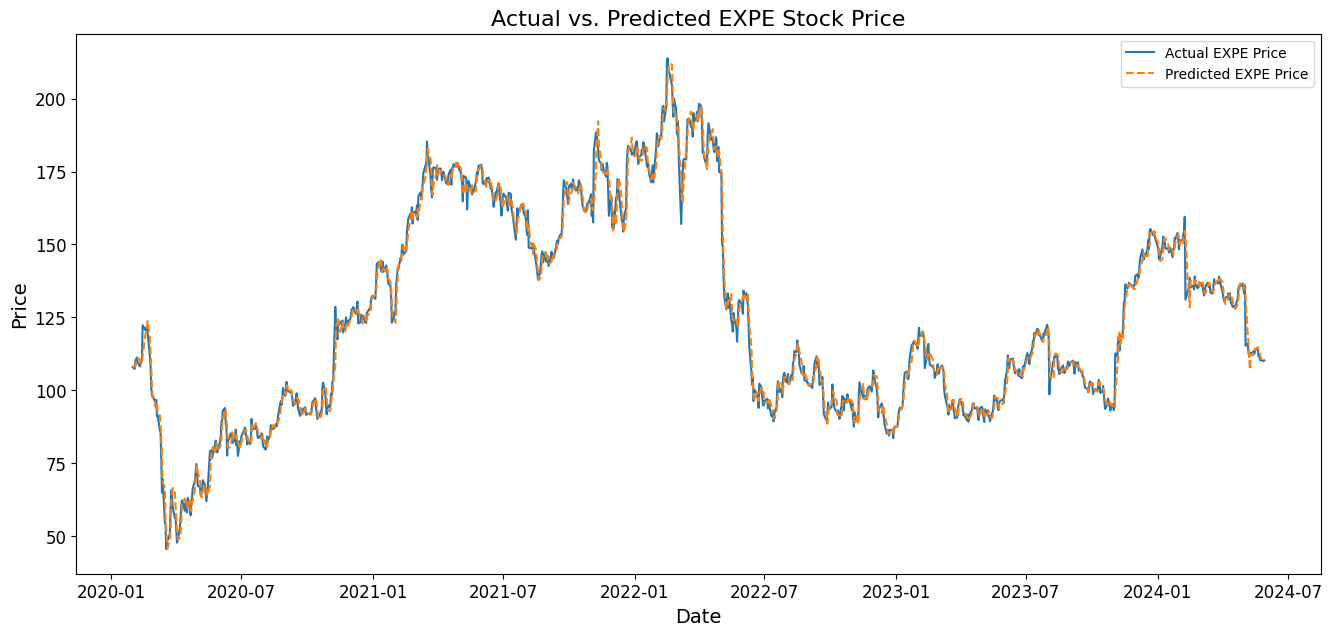

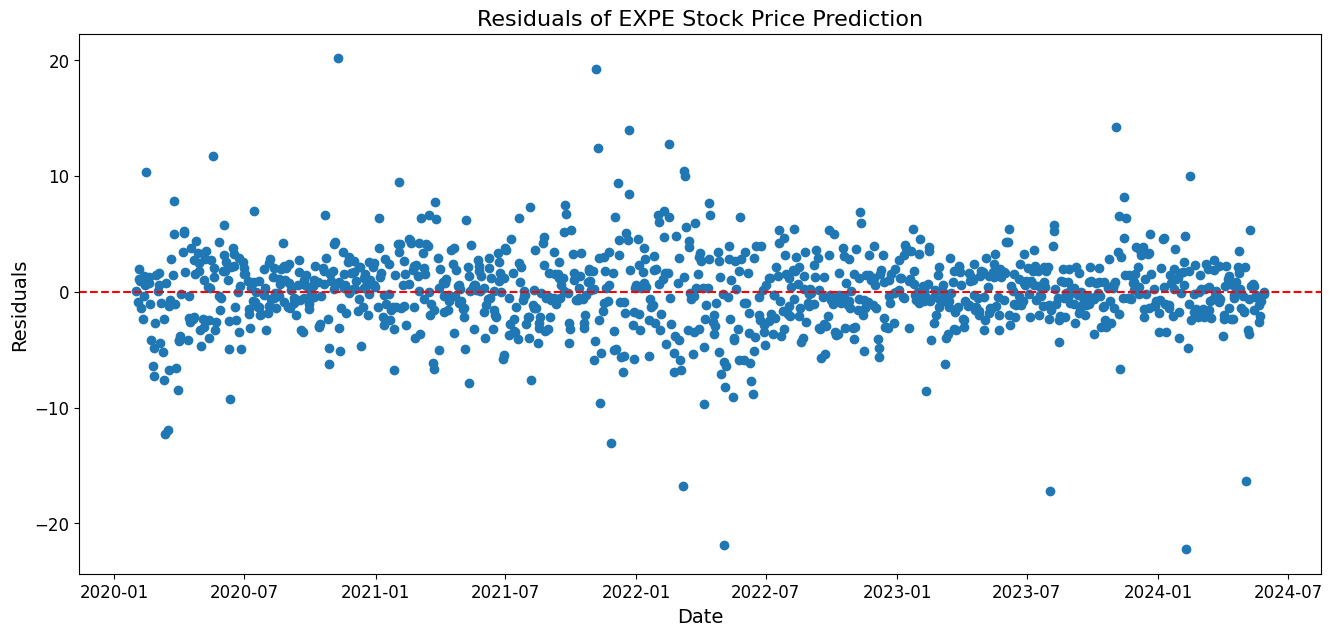

In [143]:
# Select the top 5 features based on previous analysis
selected_features = ['lag1', 'MA_5', 'MA_10', 'EMA_12', 'lag5']
X = EXPE_df[selected_features]
y = EXPE_df['Adj Close']

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EXPE_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EXPE_df['Predicted'])
mae = mean_absolute_error(y, EXPE_df['Predicted'])
mse = mean_squared_error(y, EXPE_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(EXPE_df['Date'], EXPE_df['Adj Close'], label='Actual EXPE Price')
plt.plot(EXPE_df['Date'], EXPE_df['Predicted'], label='Predicted EXPE Price', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EXPE Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
EXPE_df['Residuals'] = y - EXPE_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(EXPE_df['Date'], EXPE_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of EXPE Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()


Model Performance Statistics:
R-squared: 0.9901
Mean Absolute Error (MAE): 2.4448
Mean Squared Error (MSE): 12.1789
Root Mean Squared Error (RMSE): 3.4898
Cross-Validation R-squared: 0.9612 ± 0.0182


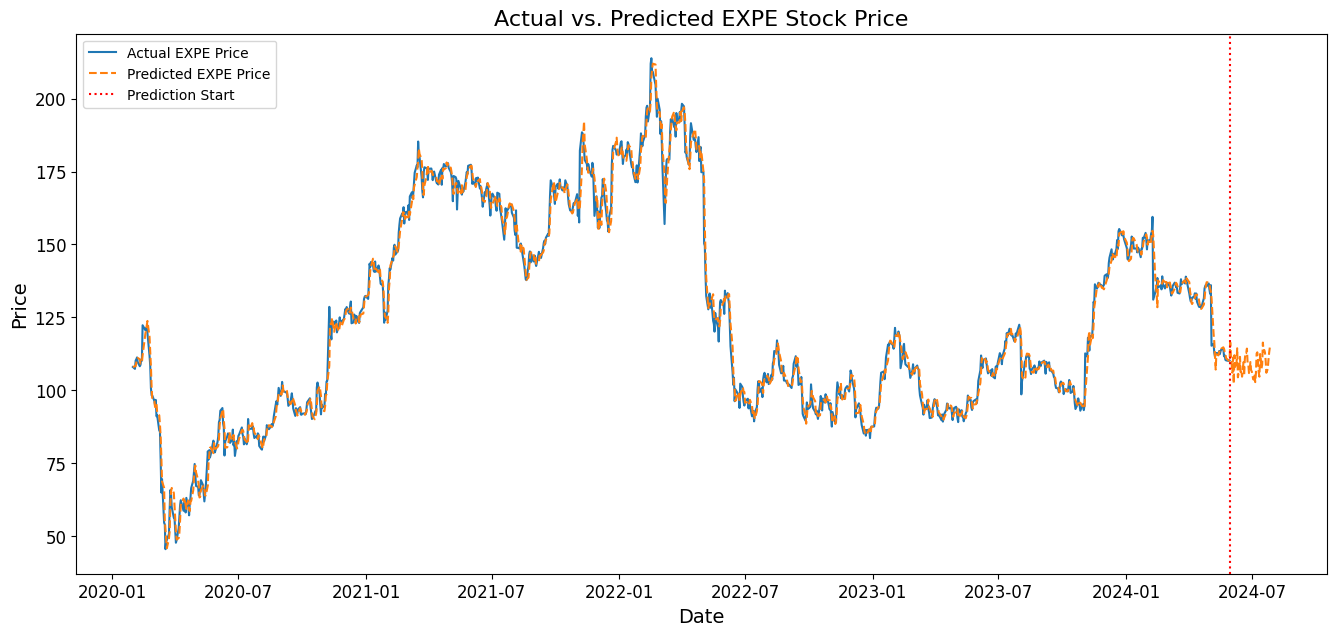

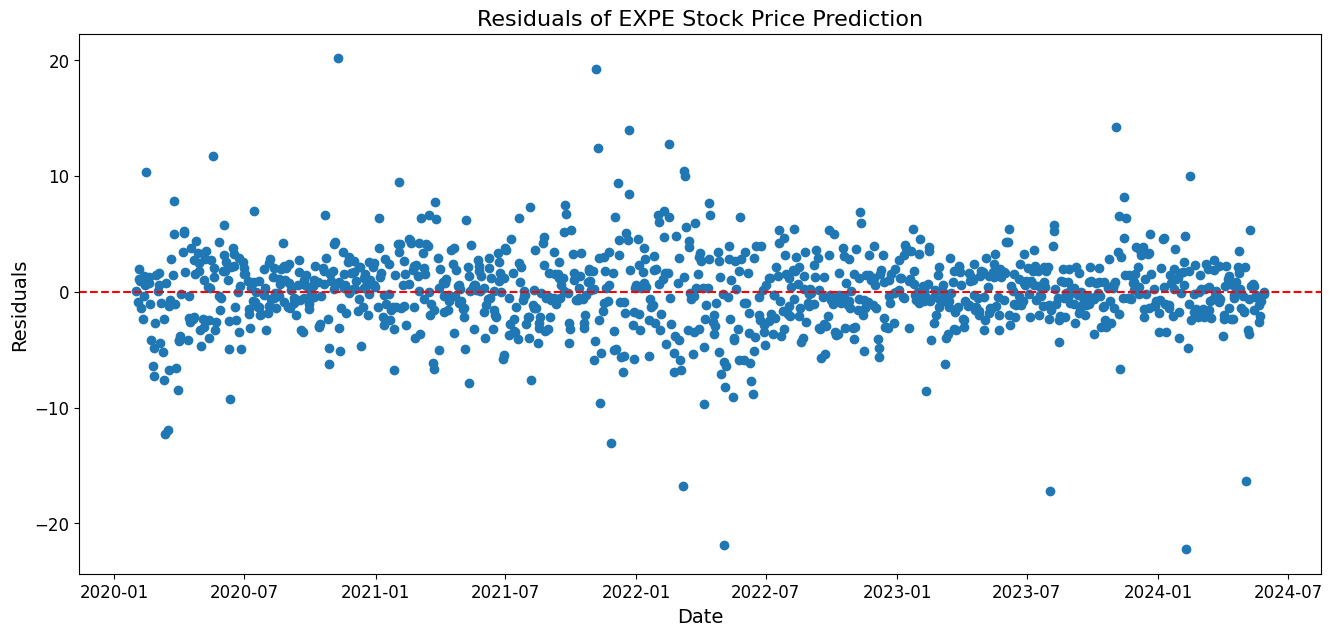

The predicted EXPE stock price for 2024-07-19 is: 113.04
The predicted EXPE stock price for 2024-07-26 is: 114.70


In [144]:
X = EXPE_df[selected_features]
y = EXPE_df['Adj Close']

# Ensure the 'Date' column is in datetime format
EXPE_df['Date'] = pd.to_datetime(EXPE_df['Date'])

# Drop rows with any NaN values
X = X.dropna()
y = y.loc[X.index]

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EXPE_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EXPE_df['Predicted'])
mae = mean_absolute_error(y, EXPE_df['Predicted'])
mse = mean_squared_error(y, EXPE_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = EXPE_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = EXPE_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([EXPE_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([EXPE_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([EXPE_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = EXPE_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([EXPE_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual EXPE Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted EXPE Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EXPE Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
EXPE_df['Residuals'] = y - EXPE_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(EXPE_df['Date'], EXPE_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of EXPE Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted EXPE stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted EXPE stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


Model Performance Statistics:
R-squared: 0.9901
Mean Absolute Error (MAE): 2.4448
Mean Squared Error (MSE): 12.1789
Root Mean Squared Error (RMSE): 3.4898
Cross-Validation R-squared: 0.9612 ± 0.0182


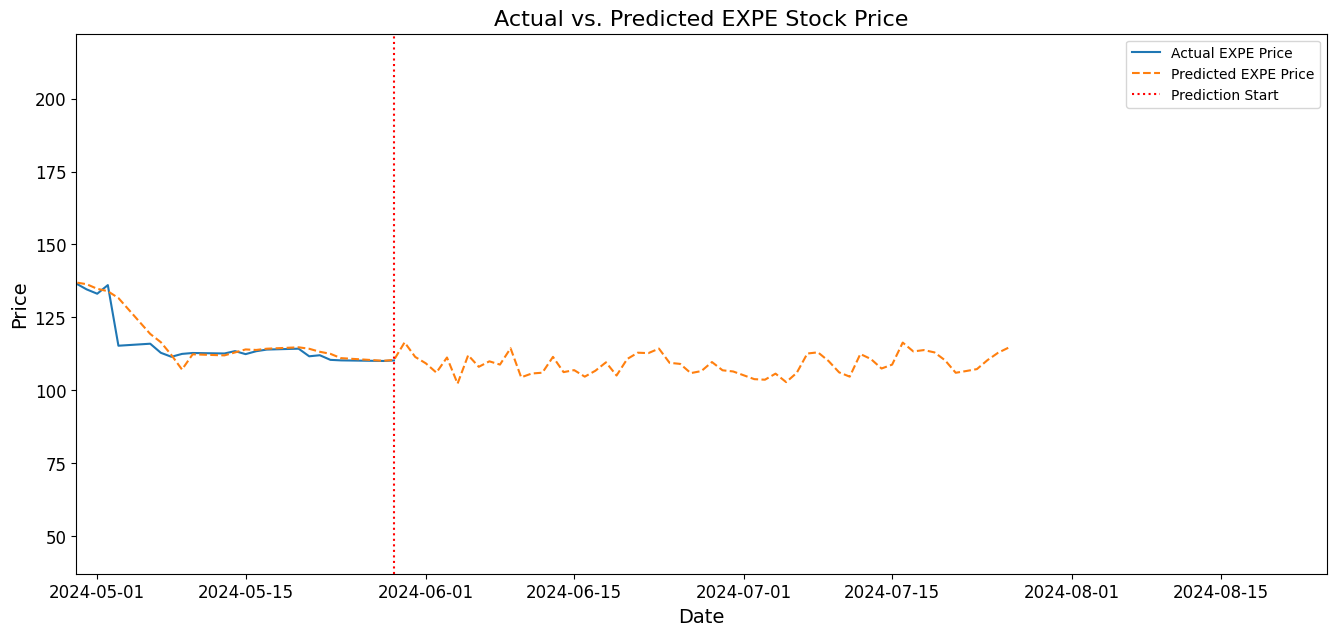

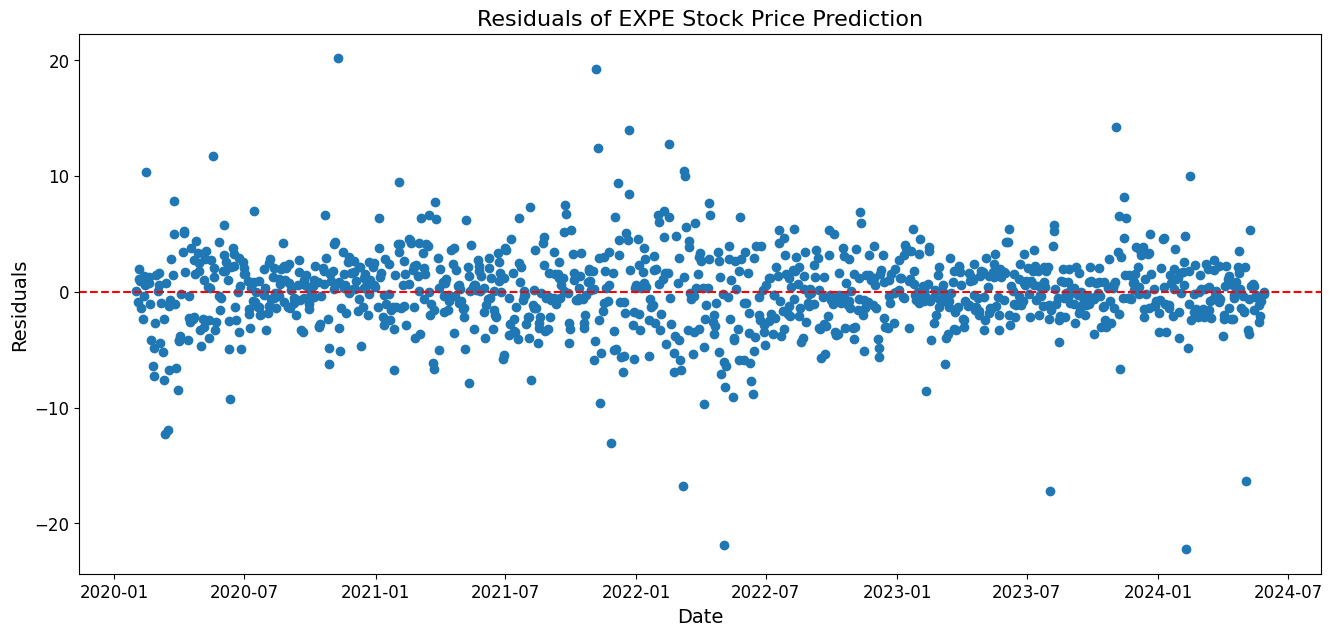

The actual EXPE stock price on the last day of the data (2024-05-29) is: 110.28
The predicted EXPE stock price for 2024-07-19 is: 113.04
The predicted EXPE stock price for 2024-07-26 is: 114.70


In [145]:
X = EXPE_df[selected_features]
y = EXPE_df['Adj Close']

# Drop rows with any NaN values
X = X.dropna()
y = y.loc[X.index]

# Fit the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict the stock prices
EXPE_df['Predicted'] = model.predict(X)

# Calculate model statistics
r2 = r2_score(y, EXPE_df['Predicted'])
mae = mean_absolute_error(y, EXPE_df['Predicted'])
mse = mean_squared_error(y, EXPE_df['Predicted'])
rmse = np.sqrt(mse)

# Cross-validation score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("Model Performance Statistics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Cross-Validation R-squared: {cv_mean:.4f} ± {cv_std:.4f}")

# Predict the price for multiple future dates
last_date = EXPE_df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end='2024-07-26')

# Create a DataFrame to hold future predictions
future_predictions = pd.DataFrame(index=future_dates, columns=['Predicted'])

# Initialize the future features with the last known values
last_known_values = EXPE_df.iloc[-1]

# Set random seed for reproducibility
np.random.seed(1)

# Use a rolling window approach to predict future prices iteratively with added volatility
for future_date in future_dates:
    # Calculate the features for the future date
    future_features = {
        'lag1': last_known_values['Adj Close'],
        'MA_5': pd.concat([EXPE_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
        'MA_10': pd.concat([EXPE_df['Adj Close'].iloc[-9:], pd.Series([last_known_values['Adj Close']])]).rolling(window=10).mean().iloc[-1],
        'EMA_12': (last_known_values['Adj Close'] * (2 / (1 + 12))) + (last_known_values['EMA_12'] * (1 - (2 / (1 + 12)))),
        'lag5': pd.concat([EXPE_df['Adj Close'].iloc[-4:], pd.Series([last_known_values['Adj Close']])]).rolling(window=5).mean().iloc[-1],
    }
    
    future_features_df = pd.DataFrame(future_features, index=[future_date])
    future_price = model.predict(future_features_df[selected_features])[0]
    
    # Add a random shock based on historical volatility
    historical_volatility = EXPE_df['Adj Close'].pct_change().std()
    random_shock = np.random.normal(loc=0, scale=historical_volatility)
    future_price *= (1 + random_shock)
    
    future_predictions.loc[future_date, selected_features] = list(future_features.values())
    future_predictions.loc[future_date, 'Predicted'] = future_price
    
    # Update the last known values
    last_known_values = pd.Series({
        'Adj Close': future_price,
        'EMA_12': future_features['EMA_12']
    })

# Combine the historical and future data for plotting
combined_data = pd.concat([EXPE_df.set_index('Date'), future_predictions])

# Visualize the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Adj Close'], label='Actual EXPE Price')
plt.plot(combined_data.index, combined_data['Predicted'], label='Predicted EXPE Price', linestyle='--')
plt.axvline(x=last_date, color='red', linestyle=':', label='Prediction Start')
plt.xlim([last_date - timedelta(days=30), future_dates[-1] + timedelta(days=30)])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs. Predicted EXPE Stock Price', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Plot residuals to check for overfitting
EXPE_df['Residuals'] = y - EXPE_df['Predicted']

plt.figure(figsize=(14, 7))
plt.scatter(EXPE_df['Date'], EXPE_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals of EXPE Stock Price Prediction', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

# Print the actual price on the last day of the data
actual_last_price = EXPE_df.iloc[-1]['Adj Close']
print(f"The actual EXPE stock price on the last day of the data ({last_date.date()}) is: {actual_last_price:.2f}")

# Print the predicted prices for 2024-07-19, 2024-07-22, and 2024-07-26
predicted_price_2024_07_19 = future_predictions.loc['2024-07-19', 'Predicted']
predicted_price_2024_07_26 = future_predictions.loc['2024-07-26', 'Predicted']

print(f"The predicted EXPE stock price for 2024-07-19 is: {predicted_price_2024_07_19:.2f}")
print(f"The predicted EXPE stock price for 2024-07-26 is: {predicted_price_2024_07_26:.2f}")


### Model #3 Creation

* This model uses regression techniques to predict future stock prices based on selected financial features. Feature importance is evaluated using Recursive Feature Elimination (RFE) with a Random Forest Regressor, and the best-performing features are used to train the final model. Cross-validation is used to assess the model's accuracy, ensuring reliable predictions for future stock prices.
* As with the previous model, we will use markdown to explain the first iteration, and then we will move to the remaining shares without detailed explanation.

* Import libraries and set up the initial dataset for feature selection and model training. Handle missing values and infinite values by converting them to NaN and removing rows with NaN values.
* Initial Data Preparation

In [146]:
# Recreate the selected dataframes to overwrite previously made versions in model 2

# Create subset for CRM
CRM_df = df[df['Symbol'] == 'CRM'].copy()

# Create subset for UBER
UBER_df = df[df['Symbol'] == 'UBER'].copy()

# Create subset for CMG
CMG_df = df[df['Symbol'] == 'CMG'].copy()

# Create subset for KHC
KHC_df = df[df['Symbol'] == 'KHC'].copy()

# Create subset for EL
EL_df = df[df['Symbol'] == 'EL'].copy()

# Create subset for EXPE
EXPE_df = df[df['Symbol'] == 'EXPE'].copy()

In [147]:
#import libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE


#See df columns
print(df.columns)

#Assign those for testing
test_vars = [
    'Volume', 'RSI', 'Bollinger_High', 'Bollinger_Low', 'MACD', 'EMA_12', 'EMA_26', 'Volume_MA_5', 
    'Volume_MA_10', 'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 'Adj Close/Volume', 'Stoch_Osc', 
    'ADX', 'CCI', 'RSI*Adj_Close', 'EMA_12*Volume', 'Stoch_Osc*ADX', 'VPT', 'OBV'
]
print(test_vars)

# Convert inf values to NA
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for NA values
if df.isna().sum().any():
    df_clean = df.dropna()
    print("NA values removed.")
else:
    df_clean = df.copy()  # No NA values to drop, copy the original DataFrame
    print("No NA values found.")
    
# Display the first few rows of the cleaned DataFrame
df_clean.head()

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Date_dt', 'lag1', 'lag5', 'lag10', 'lag20', 'forward1', 'forward5',
       'forward10', 'forward20', 'forward21', 'MA_5', 'MA_10', 'MA_20',
       'Mstd_5', 'Mstd_10', 'Mstd_20', '$_return_daily', '$_return_weekly',
       '$_return_biweekly', '$_return_monthly', '%_return_daily',
       '%_return_weekly', '%_return_biweekly', '%_return_monthly',
       'Volume_MA_5', 'Volume_MA_10', 'Day_Of_Week', 'Month', 'Quarter', 'RSI',
       'Bollinger_High', 'Bollinger_Low', 'MACD', 'EMA_12', 'EMA_26',
       'RSI*Volume', 'MACD*EMA_12', 'Adj Close*Volume', 'Adj Close/Volume',
       'Stoch_Osc', 'ADX', 'CCI', 'RSI*Adj_Close', 'EMA_12*Volume',
       'Stoch_Osc*ADX', 'is_month_end', 'is_quarter_end', 'is_year_end', 'VPT',
       'OBV'],
      dtype='object')
['Volume', 'RSI', 'Bollinger_High', 'Bollinger_Low', 'MACD', 'EMA_12', 'EMA_26', 'Volume_MA_5', 'Volume_MA_10', 'RSI*Volume', 'MACD*EMA_12', 'Adj Close*

Date Symbol  Adj Close  Close  High   Low  Open     Volume  \
10195 2020-02-07      A      80.80  83.17 84.79 82.92 84.61 1447600.00   
10196 2020-02-10      A      82.03  84.43 84.64 82.93 83.04 2066900.00   
10197 2020-02-11      A      82.67  85.09 85.67 84.84 85.03 1543200.00   
10198 2020-02-12      A      83.00  85.43 86.06 85.29 85.40 1464200.00   
10199 2020-02-13      A      83.04  85.47 85.68 84.66 85.10 1596300.00   

         Date_dt  lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
10195 2020-02-07 82.40  ...  0.00 -101.62        3036.27   119568052.79   
10196 2020-02-10 80.80  ...  0.00  -79.57        3612.25   170538727.21   
10197 2020-02-11 82.03  ... 16.73  -38.90        3895.68   127365835.51   
10198 2020-02-12 82.67  ... 16.10  -24.27        4041.58   120950036.46   
10199 2020-02-13 83.00  ... 15.88  -30.13        4059.44   131967947.48   

       Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end       VPT  \
10195          -0.00             0               0            0 -77385.55   
10196          -0.00             0               0            0 -46072.65   
10197         118.31             0               0            0 -34009.93   
10198         194.27             0               0            0 -28158.82   
10199         235.26             0               0            0 -27411.48   

              OBV  
10195  7569400.00  
10196  9636300.00  
10197 11179500.00  
10198 12643700.00  
10199 14240000.00  

[5 rows x 58 columns]

* Feature Selection Function

In [148]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#define feature selection function
def select_best_vars(df_clean, target_variable='Adj Close'):
    # Define variables and target
    X = df_clean[test_vars]
    y = df_clean[target_variable]
    
    # Initialize Linear Regression model
    model = RandomForestRegressor(n_estimators = 3, max_depth = 2, random_state = 0)
    
    # Initialize RFE
    rfe = RFE(model, n_features_to_select = X.shape[1])
    
    # Fit RFE
    rfe.fit(X, y)
    
    # Fit model to get feature importances
    model.fit(X, y)
    vars_importances = model.feature_importances_
    
    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': vars_importances
    })
    
    # Rank features based on importance
    ranked_vars = importance_df.sort_values(by='Importance', ascending=False)
    
    return ranked_vars

# Call the function and get results
ranked_vars = select_best_vars(df_clean)

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5]) #PRINT TOP 5 FEATURES

Top variable based on importance: EMA_12
Feature Rankings:
             Feature  Importance
5             EMA_12        0.93
19               VPT        0.07
0             Volume        0.00
11  Adj Close*Volume        0.00
18     Stoch_Osc*ADX        0.00


* CRM Analysis

In [149]:
#create cleaned CRM subset
CRM_df_clean = df_clean[df_clean['Symbol'] == 'CRM'].copy()
CRM_df_clean.head()

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
462190 2020-01-31    CRM     182.07 182.31 186.03 180.79 184.86 4193300.00   
462191 2020-02-03    CRM     185.18 185.42 185.87 181.85 183.26 4755200.00   
462192 2020-02-04    CRM     188.09 188.34 189.69 186.65 188.00 3983200.00   
462193 2020-02-05    CRM     185.25 185.49 190.55 182.86 190.40 6162700.00   
462194 2020-02-06    CRM     186.49 186.73 187.56 184.24 186.83 4102700.00   

          Date_dt   lag1  ...   ADX    CCI  RSI*Adj_Close  EMA_12*Volume  \
462190 2020-01-31 185.43  ... 20.79  52.94        7607.80   767292334.25   
462191 2020-02-03 182.07  ... 19.81  81.46        8589.08   871716765.93   
462192 2020-02-04 185.18  ... 18.80 202.06        9470.24   733121308.91   
462193 2020-02-05 188.09  ... 17.91 141.58        8654.16  1135398259.20   
462194 2020-02-06 185.25  ... 17.08 130.19        9036.87   757289426.32   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
462190        1085.45             1               0            0   
462191        1707.90             0               0            0   
462192        1637.91             0               0            0   
462193        1074.20             0               0            0   
462194        1184.12             0               0            0   

                 VPT            OBV  
462190 1185678386.69 19312494540.00  
462191 1185759504.94 19317249740.00  
462192 1185822232.67 19321232940.00  
462193 1185728977.38 19315070240.00  
462194 1185756403.71 19319172940.00  

[5 rows x 58 columns]

In [150]:
#perform select_best_vars function on CRM data
ranked_vars = select_best_vars(CRM_df_clean, target_variable = 'forward21')

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: EMA_12
Feature Rankings:
             Feature  Importance
5             EMA_12        0.97
10       MACD*EMA_12        0.02
4               MACD        0.01
12  Adj Close/Volume        0.00
19               VPT        0.00


In [151]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = CRM_df_clean[selected_vars]
y = CRM_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                      MSE
Linear Regression  517.45
Gradient Boosting  675.41
Random Forest      768.84
XGBoost            827.85
Decision Tree      969.59
KNN (Euclidean)   1085.24
KNN (Manhattan)   1098.89
SVR               1990.32


In [152]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = CRM_df_clean[selected_vars]
y = CRM_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = CRM_df[CRM_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22               216.79
1 2024-07-23               219.63
2 2024-07-24               220.81
3 2024-07-25               222.35
4 2024-07-26               224.08


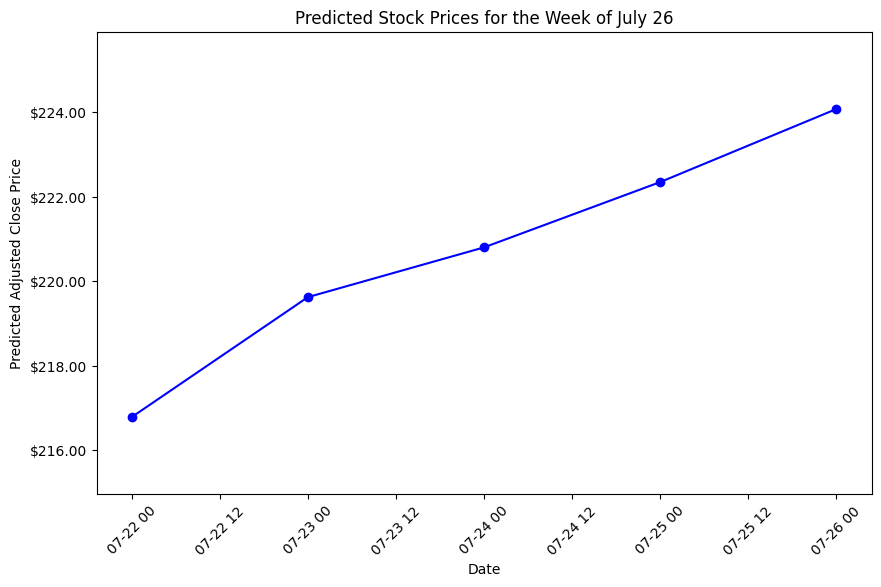

In [153]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [154]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std()) 

Mean cross-validation MSE score: 517.4454343793736
Standard deviation of cross-validation MSE scores: 157.05452885467756

Mean cross-validation R-squared score: 0.5268724430010618
Standard deviation of cross-validation R-squared scores: 0.1729003283467422


* UBER Analysis

In [155]:
UBER_df_clean = df_clean[df_clean['Symbol'] == 'UBER'].copy()
UBER_df_clean.head()

ranked_vars = select_best_vars(UBER_df_clean, target_variable = 'forward21')

print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: Bollinger_High
Feature Rankings:
             Feature  Importance
2     Bollinger_High        0.71
20               OBV        0.19
5             EMA_12        0.09
12  Adj Close/Volume        0.00
19               VPT        0.00


In [156]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = UBER_df_clean[selected_vars]
y = UBER_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                     MSE
Linear Regression  55.03
Gradient Boosting  94.01
Random Forest     102.69
XGBoost           103.18
Decision Tree     128.80
KNN (Euclidean)   140.24
KNN (Manhattan)   140.24
SVR               313.16


In [157]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = UBER_df_clean[selected_vars]
y = UBER_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = UBER_df[UBER_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22                68.27
1 2024-07-23                68.33
2 2024-07-24                68.51
3 2024-07-25                68.79
4 2024-07-26                68.92


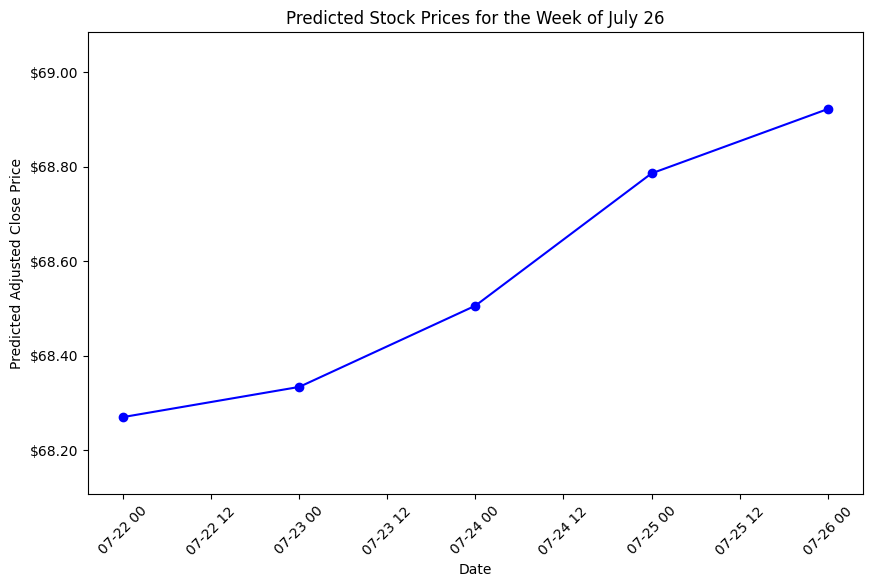

In [158]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [159]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores (misleading)
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std()) 

Mean cross-validation MSE score: 55.03433440694969
Standard deviation of cross-validation MSE scores: 40.114882446105966

Mean cross-validation R-squared score: 0.23463362254835102
Standard deviation of cross-validation R-squared scores: 0.20653046238665598


* CMG Analysis

In [160]:
#create cleaned CRM subset
CMG_df_clean = df_clean[df_clean['Symbol'] == 'CMG'].copy()
CMG_df_clean.head()

Date Symbol  Adj Close  Close  High   Low  Open      Volume  \
118670 2020-01-31    CMG      17.34  17.34 17.70 17.30 17.59 19290000.00   
118671 2020-02-03    CMG      17.35  17.35 17.60 17.33 17.36 22850000.00   
118672 2020-02-04    CMG      17.70  17.70 17.80 17.47 17.52 49110000.00   
118673 2020-02-05    CMG      17.08  17.08 17.86 17.03 17.84 51735000.00   
118674 2020-02-06    CMG      17.14  17.14 17.27 16.94 17.16 34475000.00   

          Date_dt  lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
118670 2020-01-31 17.60  ... 83.09   34.35          90.50   440075924.59   
118671 2020-02-03 17.34  ... 83.72   22.46          91.00   502073735.08   
118672 2020-02-04 17.35  ... 84.25  119.85         107.40  1046765729.84   
118673 2020-02-05 17.70  ... 84.74  -44.22         101.98  1069013367.92   
118674 2020-02-06 17.08  ... 85.20 -140.49         105.06   693678837.38   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
118670        3431.13             1               0            0   
118671        3268.76             0               0            0   
118672        7113.04             0               0            0   
118673         539.04             0               0            0   
118674        1862.98             0               0            0   

                 VPT            OBV  
118670 1121652964.46 17131140645.00  
118671 1121667991.41 17153990645.00  
118672 1122658311.34 17203100645.00  
118673 1120856866.91 17151365645.00  
118674 1120977566.73 17185840645.00  

[5 rows x 58 columns]

In [161]:
#perform select_best_vars function on CMG data
ranked_vars = select_best_vars(CMG_df_clean, target_variable = 'forward21')

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: OBV
Feature Rankings:
             Feature  Importance
20               OBV        0.94
5             EMA_12        0.02
3      Bollinger_Low        0.02
2     Bollinger_High        0.02
12  Adj Close/Volume        0.00


In [162]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = CMG_df_clean[selected_vars]
y = CMG_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                     MSE
Linear Regression  14.51
KNN (Euclidean)    53.41
KNN (Manhattan)    53.41
Gradient Boosting  68.99
XGBoost            70.22
Random Forest      72.20
Decision Tree      72.71
SVR               135.25


In [163]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = CMG_df_clean[selected_vars]
y = CMG_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = CMG_df[CMG_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22                66.24
1 2024-07-23                65.84
2 2024-07-24                65.48
3 2024-07-25                65.93
4 2024-07-26                66.41


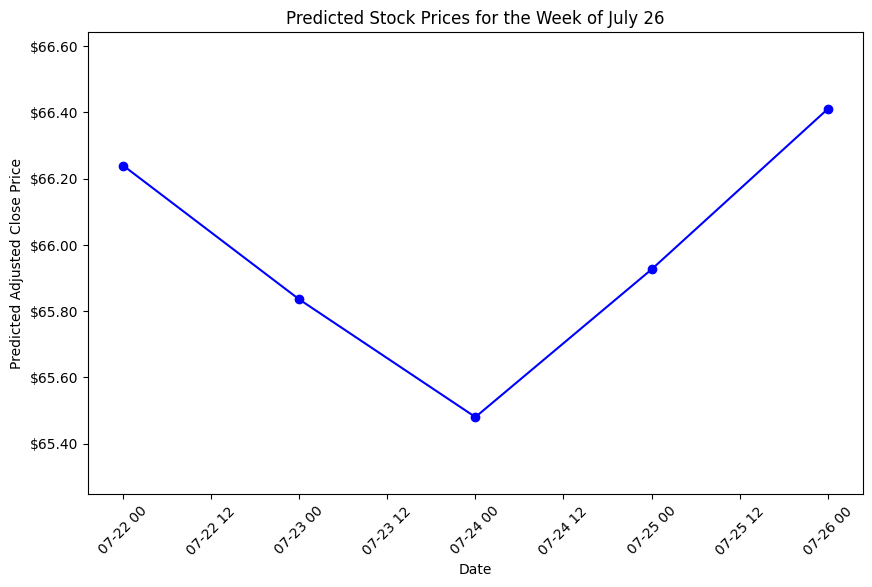

In [164]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [165]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores (misleading)
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std())

Mean cross-validation MSE score: 14.514986200652697
Standard deviation of cross-validation MSE scores: 7.080835171256107

Mean cross-validation R-squared score: 0.3391647799669253
Standard deviation of cross-validation R-squared scores: 0.44132189528455873


* KHC Analysis

In [166]:
#create cleaned KHC subset
KHC_df_clean = df_clean[df_clean['Symbol'] == 'KHC'].copy()
KHC_df_clean.head()

#perform select_best_vars function on KHC data
ranked_vars = select_best_vars(KHC_df_clean, target_variable = 'forward21')

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: EMA_12
Feature Rankings:
             Feature  Importance
5             EMA_12        0.80
4               MACD        0.13
14               ADX        0.04
10       MACD*EMA_12        0.03
12  Adj Close/Volume        0.00


In [167]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = KHC_df_clean[selected_vars]
y = KHC_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                    MSE
Linear Regression  9.71
Random Forest     12.93
Gradient Boosting 12.99
XGBoost           14.05
KNN (Euclidean)   15.16
KNN (Manhattan)   16.39
SVR               17.28
Decision Tree     18.24


In [168]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = KHC_df_clean[selected_vars]
y = KHC_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = KHC_df[KHC_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22                33.20
1 2024-07-23                33.17
2 2024-07-24                33.18
3 2024-07-25                33.12
4 2024-07-26                33.02


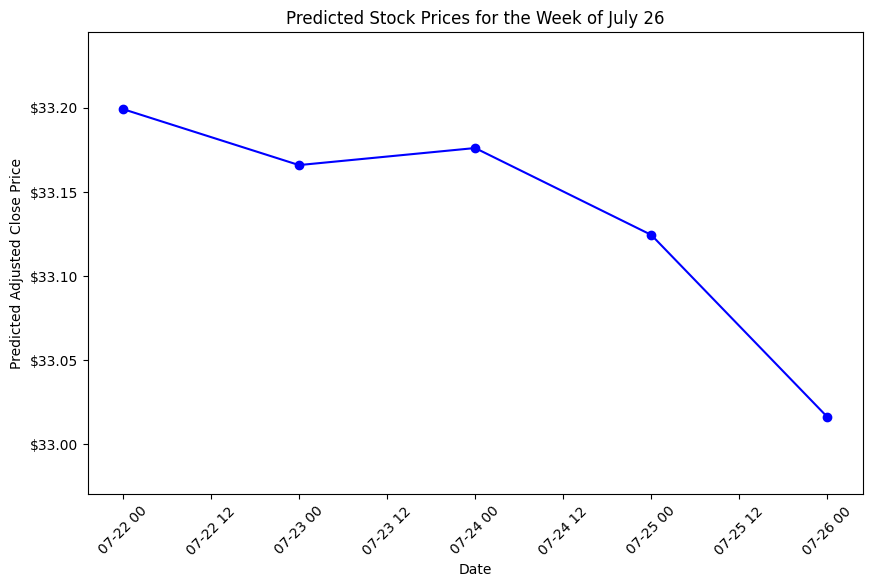

In [169]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [170]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores (misleading)
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std()) 

Mean cross-validation MSE score: 9.70556989301297
Standard deviation of cross-validation MSE scores: 10.530020425480025

Mean cross-validation R-squared score: 0.4206253971197483
Standard deviation of cross-validation R-squared scores: 0.9948539929958634


* EL Analysis

In [171]:
#create cleaned EL subset
EL_df_clean = df_clean[df_clean['Symbol'] == 'EL'].copy()
EL_df_clean.head()

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
203420 2020-01-31     EL     185.80 195.16 198.79 194.67 197.60 1620600.00   
203421 2020-02-03     EL     186.79 196.20 199.31 195.04 195.68 2301600.00   
203422 2020-02-04     EL     190.81 200.42 202.22 198.46 199.40 2252200.00   
203423 2020-02-05     EL     191.67 201.32 204.25 200.55 203.60 2293800.00   
203424 2020-02-06     EL     201.39 211.53 213.45 205.11 210.98 4056300.00   

          Date_dt   lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
203420 2020-01-31 189.14  ... 52.54 -123.71       12018.01   308108494.76   
203421 2020-02-03 185.80  ... 50.67 -105.88       12204.39   436402278.25   
203422 2020-02-04 186.79  ... 49.21  -65.56       12962.64   427452387.96   
203423 2020-02-05 190.81  ... 48.04  -46.32       13124.87   436009319.11   
203424 2020-02-06 191.67  ... 47.69   24.74       14878.18   778084145.83   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
203420        -942.76             1               0            0   
203421        -738.31             0               0            0   
203422         -43.42             0               0            0   
203423          97.85             0               0            0   
203424        1676.56             0               0            0   

                 VPT            OBV  
203420 1266729337.64 21529168459.00  
203421 1266741603.02 21531470059.00  
203422 1266790044.58 21533722259.00  
203423 1266800345.14 21536016059.00  
203424 1267006061.53 21540072359.00  

[5 rows x 58 columns]

In [172]:
#perform select_best_vars function on EL data
ranked_vars = select_best_vars(EL_df_clean, target_variable = 'forward21')

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: EMA_12
Feature Rankings:
             Feature  Importance
5             EMA_12        0.38
3      Bollinger_Low        0.31
20               OBV        0.31
12  Adj Close/Volume        0.00
19               VPT        0.00


In [173]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = EL_df_clean[selected_vars]
y = EL_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                      MSE
Linear Regression  668.32
Gradient Boosting  672.03
Random Forest      758.30
XGBoost            777.14
Decision Tree      909.23
KNN (Euclidean)   1467.62
KNN (Manhattan)   1468.48
SVR               6027.68


In [174]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = EL_df_clean[selected_vars]
y = EL_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = EL_df[EL_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22               105.83
1 2024-07-23               107.09
2 2024-07-24               107.76
3 2024-07-25               106.67
4 2024-07-26               105.77


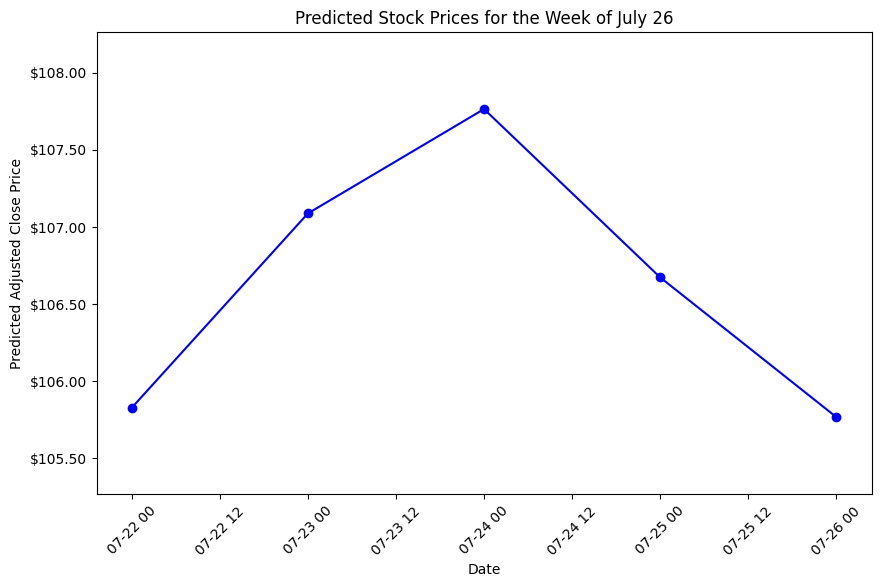

In [175]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [176]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores (misleading)
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std()) 


Mean cross-validation MSE score: 668.3154439857977
Standard deviation of cross-validation MSE scores: 230.72842813096926

Mean cross-validation R-squared score: 0.29176847165811826
Standard deviation of cross-validation R-squared scores: 0.9284521170363035


* EXPE Analysis

In [177]:
#create cleaned EXPE subset
EXPE_df_clean = df_clean[df_clean['Symbol'] == 'EXPE'].copy()
EXPE_df_clean.head()

Date Symbol  Adj Close  Close   High    Low   Open     Volume  \
210200 2020-01-31   EXPE     108.05 108.45 109.36 107.04 109.08 3281400.00   
210201 2020-02-03   EXPE     107.40 107.80 110.05 107.38 108.96 2970800.00   
210202 2020-02-04   EXPE     110.25 110.66 111.34 108.80 109.03 1825900.00   
210203 2020-02-05   EXPE     110.69 111.10 111.96 109.76 111.78 1238700.00   
210204 2020-02-06   EXPE     111.34 111.75 112.23 110.79 111.41 1233200.00   

          Date_dt   lag1  ...   ADX     CCI  RSI*Adj_Close  EMA_12*Volume  \
210200 2020-01-31 108.70  ... 28.33 -112.94        3833.58   360953414.15   
210201 2020-02-03 108.05  ... 28.40  -98.24        3660.95   325599671.26   
210202 2020-02-04 107.40  ... 27.80   10.40        4898.25   200301330.47   
210203 2020-02-05 110.25  ... 26.94   49.22        5073.58   136073871.78   
210204 2020-02-06 110.69  ... 26.01   82.92        5336.91   135751266.81   

        Stoch_Osc*ADX  is_month_end  is_quarter_end  is_year_end  \
210200         626.31             1               0            0   
210201         397.88             0               0            0   
210202        1379.71             0               0            0   
210203        1484.80             0               0            0   
210204        1644.04             0               0            0   

                 VPT            OBV  
210200 1309216860.23 22317051075.00  
210201 1309199054.90 22314080275.00  
210202 1309247497.11 22315906175.00  
210203 1309252422.34 22317144875.00  
210204 1309259637.25 22318378075.00  

[5 rows x 58 columns]

In [178]:
#perform select_best_vars function on EXPE data
ranked_vars = select_best_vars(EXPE_df_clean, target_variable = 'forward21')

# Print the top variable
print("Top variable based on importance:", ranked_vars.iloc[0]['Feature'])

# Print feature rankings
print("Feature Rankings:")
print(ranked_vars[:5])

Top variable based on importance: VPT
Feature Rankings:
             Feature  Importance
19               VPT        1.00
0             Volume        0.00
11  Adj Close*Volume        0.00
18     Stoch_Osc*ADX        0.00
17     EMA_12*Volume        0.00


In [179]:
#assign variables
selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = EXPE_df_clean[selected_vars]
y = EXPE_df_clean['forward21']

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
    'SVR': SVR(),
    'KNN (Euclidean)': KNeighborsRegressor(n_neighbors=5, metric='euclidean'),
    'KNN (Manhattan)': KNeighborsRegressor(n_neighbors=5, metric='manhattan'),
    }

# Evaluate each model using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = -scores.mean()  # Take the negative to get positive MSE

# Display the results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')

print("Model evaluation results (sorted by MSE):")
print(results_df)

Model evaluation results (sorted by MSE):
                     MSE
Linear Regression 603.81
Gradient Boosting 691.48
XGBoost           719.74
SVR               788.62
Random Forest     793.89
KNN (Euclidean)   797.16
KNN (Manhattan)   797.16
Decision Tree     840.17


In [180]:
## Assign variables
# Dates for predictions
projection_dates = pd.date_range(end='2024-06-26', periods=5, freq='B')
future_dates = pd.date_range(start='2024-07-22', periods=5, freq='B')

selected_vars = ranked_vars[ranked_vars['Importance'] > 0]['Feature'].tolist()
X = EXPE_df_clean[selected_vars]
y = EXPE_df_clean['forward21']

# Define the best model
best_model_name = 'Linear Regression'
best_model = models[best_model_name]

# Train the best model on the entire dataset
best_model.fit(X, y)

# Prepare to store predictions
predictions = []

# Iterate over each future date and make predictions
for i, future_date in enumerate(future_dates):
    # Extract the data for the corresponding projection date
    input_date = projection_dates[i]
    input_data = EXPE_df[EXPE_df['Date'] == input_date][selected_vars]
    
    if input_data.empty:
        raise ValueError(f"No data available for projection date: {input_date}")
    
    # Make the prediction
    predicted_price = best_model.predict(input_data)[0]
        
    # Store the prediction
    predictions.append((future_date, predicted_price))

# Create a DataFrame to hold predictions
predictions_df = pd.DataFrame(predictions, columns=['Date', 'Predicted_Adj_Close'])

# Print the predictions
print("Predicted stock prices for the week of July 26:")
print(predictions_df)

Predicted stock prices for the week of July 26:
        Date  Predicted_Adj_Close
0 2024-07-22                85.39
1 2024-07-23                86.12
2 2024-07-24                86.19
3 2024-07-25                86.44
4 2024-07-26                86.10


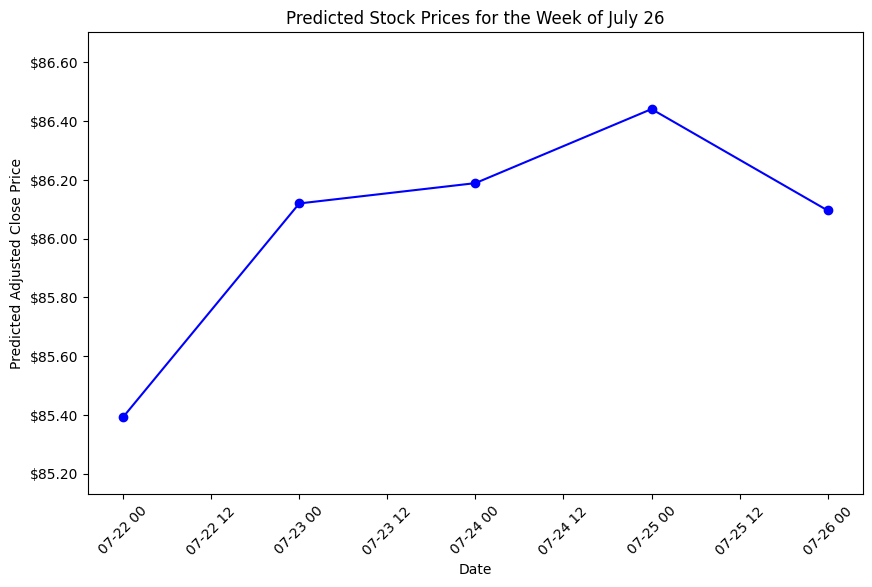

In [181]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(predictions_df['Date'], predictions_df['Predicted_Adj_Close'], marker='o', linestyle='-', color='b')
plt.title('Predicted Stock Prices for the Week of July 26')
plt.xlabel('Date')
plt.ylabel('Predicted Adjusted Close Price')
plt.xticks(rotation=45)

# Set y-axis formatter
# Function to format y-axis labels
def currency(x, pos):
    return f'${x:.2f}'

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

# Extend the y-axis range
y_min = predictions_df['Predicted_Adj_Close'].min()
y_max = predictions_df['Predicted_Adj_Close'].max()
y_range = y_max - y_min
plt.ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.show()

In [182]:
#perform cross-validation
cv_MSE = -cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(best_model, X, y, cv=5, scoring='r2')

# Print the cross-validation MSE scores
print("Mean cross-validation MSE score:", cv_MSE.mean())
print("Standard deviation of cross-validation MSE scores:", cv_MSE.std())
print('')

# Print the cross-validation r-squared scores (very misleading)
print("Mean cross-validation R-squared score:", abs(cv_r2.mean()))
print("Standard deviation of cross-validation R-squared scores:", cv_r2.std()) 

Mean cross-validation MSE score: 603.8094235951188
Standard deviation of cross-validation MSE scores: 149.1166745061087

Mean cross-validation R-squared score: 1.9375949916034565
Standard deviation of cross-validation R-squared scores: 3.004686148550277
